# Overlap Detection

> We now try to detect potentially overlapping pings using a buffer on a particular day.

__Notes:__

1. Running on DBR 16.1+ for PySpark bindings.
1. Running on a "classic" cluster (vs Serverless) as we are applying Spark configs.
1. Reach out to your sales team to join the spatial sql private preview (aka you need the proper config to apply in the cell currently showing `%run ../common/classic_enable_spatial_preview.py`)

---
__Original Author:__ Timo Roest | __Maintainer:__ Michael Johns | _Last Updated:_ 06 FEB 2025 

## Setup

In [0]:
%pip install -U "databricks-spatial[viz] @ git+https://github.com/databrickslabs/mosaic.git@spatial-utils-v1" --quiet

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
spark.conf.set("spark.databricks.optimizer.adaptive.enabled", False) # <-- turn off AQE
spark.conf.set("spark.sql.shuffle.partitions", 1_024)                # <-- default is 200

# -- import databricks + spark functions
from pyspark.databricks.sql import functions as dbf
from pyspark.sql import functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *

# --other imports
import os
import warnings

warnings.simplefilter("ignore")

In [0]:
# - VIZ
from spatial.viz.keplergl import *
from spatial.viz.helpers import *

kviz = KeplerViz(spark)

In [0]:
%run ../common/classic_enable_spatial_preview.py

__Configure Database__

> Adjust this to settings from the Data Prep notebook.

In [0]:
catalog_name = "geospatial_docs"
db_name = "ship2ship"

sql(f"use catalog {catalog_name}")
sql(f"use schema {db_name}")

DataFrame[]

In [0]:
cargos_indexed = spark.read.table("cargos_indexed").filter(
    col("BaseDateTime").between(
        "2018-01-31T00:00:00.000+0000", "2018-01-31T23:59:00.000+0000"
    )
)
print(f"count? {cargos_indexed.count():,}")
cargos_indexed.limit(5).display() # <- limiting for ipynb only

count? 521,430


cellid,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass,point_geom,sog_kmph
617733124345036799,367353660,2018-01-31T01:37:52Z,40.78783,-73.91983,0.1,96.0,35.0,RED HOOK,IMO9501916,WDE4476,70,0,107,16,4.9,80,A,AQEAAABN+KV+3npSwGJnCp3XZERA,0.19
617733124345036799,367353660,2018-01-31T01:36:42Z,40.78783,-73.91983,0.2,320.0,35.0,RED HOOK,IMO9501916,WDE4476,70,0,107,16,4.9,80,A,AQEAAABN+KV+3npSwGJnCp3XZERA,0.37
617733124345036799,367353660,2018-01-31T01:34:11Z,40.78783,-73.91983,0.2,167.0,35.0,RED HOOK,IMO9501916,WDE4476,70,0,107,16,4.9,80,A,AQEAAABN+KV+3npSwGJnCp3XZERA,0.37
617733124345036799,367353660,2018-01-31T01:31:51Z,40.78783,-73.91983,0.0,170.0,34.0,RED HOOK,IMO9501916,WDE4476,70,0,107,16,4.9,80,A,AQEAAABN+KV+3npSwGJnCp3XZERA,0.0
617733124345036799,367353660,2018-01-31T01:33:02Z,40.78783,-73.91983,0.1,125.0,35.0,RED HOOK,IMO9501916,WDE4476,70,0,107,16,4.9,80,A,AQEAAABN+KV+3npSwGJnCp3XZERA,0.19


## Buffering

<p/>

1. Convert the point into a polygon by buffering it with a certain area to turn this into a circle.
2. Index the polygon to leverage more performant querying.

> Since our projection is not in metres, we convert from decimal degrees, with `(0.00001 - 0.000001)` as being equal to one metre at the equator. Here we choose an buffer of roughly 100 metres, ref http://wiki.gis.com/wiki/index.php/Decimal_degrees.

In [0]:
one_meter = 0.00001 - 0.000001
buffer = 100 * one_meter

(
    cargos_indexed
    .repartition(sc.defaultParallelism * 20) # <- repartition is important!
    .drop("cellid")
    .withColumn("buffer_geom", dbf.st_asbinary(dbf.st_buffer("point_geom", buffer)))
    .select(F.expr("inline(h3_tessellateaswkb(buffer_geom, 9))"), "*")
    .write.mode("overwrite")
    .saveAsTable("cargos_buffered")
)

_We will optimize our table to colocate data and make querying faster._

In [0]:
%sql
ALTER TABLE cargos_buffered CLUSTER BY (cellid, BaseDateTime);

OPTIMIZE cargos_buffered;

SELECT * FROM cargos_buffered LIMIT 5;

cellid,core,chip,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass,point_geom,sog_kmph,buffer_geom
618194251675074559,false,AQMAAAABAAAAFAAAAJJZx/4velbAWXOsoj/kPUCbgx5sHHpWwFhcJgeP5D1AB7BT6Rl6VsAJ12QNjeQ9QJTGfZoYelbAUYdmrYbkPUCt0ac9F3pWwHiw5Xp85D1AF/LXZhZ6VsD2ClZqceQ9QGB2Tx4WelbAMSWS6GXkPUAX8tc= (truncated),209109000,2018-01-31T05:04:37Z,29.89218,-89.9085,0.0,170.8,349.0,UBC SALAVERRY,IMO9426881,5BDP3,70,1,171,28,10.6,null,A,AQEAAACgGi/dJHpWwDElkuhl5D1A,0.0,AQMAAAABAAAAIQAAAGB2Tx4WelbAMSWS6GXkPUAX8tdmFnpWwGw/zmZa5D1ArdGnPRd6VsDqmT5WT+Q9QJTGfZoYelbAEcO9I0XkPUDU/fFvGnpWwP+xnTM85D1AGAL6qxx6VsAC1czdNOQ9QM43mjgfelbAZgF1ai/kPUAvIb4= (truncated)
618194250319527935,false,AQMAAAABAAAAIQAAAAjJAiZwgVbAHtydtdvGPUC/RItucIFWwFn22TPQxj1AVSRbRXGBVsDXUEojxcY9QDwZMaJygVbA/nnJ8LrGPUB8UKV3dIFWwOxoqQCyxj1AwFSts3aBVsDvi9iqqsY9QHaKTUB5gVbAU7iAN6XGPUDXc3E= (truncated),210066000,2018-01-31T07:45:04Z,29.77679,-90.02337,0.0,32.0,14.0,DIMITRIS APESAKIS,IMO9398656,5BJW2,70,1,229,32,14.4,0,A,AQEAAABIbeLkfoFWwB7cnbXbxj1A,0.0,AQMAAAABAAAAIQAAAAjJAiZwgVbAHtydtdvGPUC/RItucIFWwFn22TPQxj1AVSRbRXGBVsDXUEojxcY9QDwZMaJygVbA/nnJ8LrGPUB8UKV3dIFWwOxoqQCyxj1AwFSts3aBVsDvi9iqqsY9QHaKTUB5gVbAU7iAN6XGPUDXc3E= (truncated)
618194251214225407,false,AQMAAAABAAAAIQAAAKGhf4KLkVbAc6JdhZT3PUBYHQjLi5FWwK68mQOJ9z1A7vzXoYyRVsAsFwrzffc9QNXxrf6NkVbAU0CJwHP3PUAVKSLUj5FWwEEvadBq9z1AWS0qEJKRVsBEUph6Y/c9QA9jypyUkVbAqH5AB173PUBwTO4= (truncated),212533000,2018-01-31T02:14:22Z,29.96711,-90.27504,0.1,207.3,255.0,BRIGITTE,IMO9730270,5BLA4,70,1,null,null,null,null,A,AQEAAADhRV9BmpFWwHOiXYWU9z1A,0.19,AQMAAAABAAAAIQAAAKGhf4KLkVbAc6JdhZT3PUBYHQjLi5FWwK68mQOJ9z1A7vzXoYyRVsAsFwrzffc9QNXxrf6NkVbAU0CJwHP3PUAVKSLUj5FWwEEvadBq9z1AWS0qEJKRVsBEUph6Y/c9QA9jypyUkVbAqH5AB173PUBwTO4= (truncated)
618191123395117055,false,AQMAAAABAAAACgAAAO1HeP3l21TAO0IxvsdnO0AeiSCZ8dtUwAXgXTbTZztA2MhgsPPbVMCFkdmK72c7QGwTxv/w21TAMz6Qe+5nO0ALKqI77ttUwNq/UCDrZztAVfQBr+vbVMA+7Pis5Wc7QBHw+XLp21TAQQ8oV95nO0DRuIU= (truncated),212960000,2018-01-31T08:33:01Z,27.4051,-83.43676,11.1,66.0,62.0,QUEEN B,IMO9318929,5BHY4,70,0,132,19,7.2,null,A,AQEAAADdDDfg89tUwA+cM6K0ZztA,20.56,AQMAAAABAAAAIQAAAJ1oVyHl21TAD5wzorRnO0BU5N9p5dtUwEq2byCpZztA6sOvQObbVMDIEOAPnmc7QNG4hZ3n21TA7zlf3ZNnO0AR8Ply6dtUwN0oP+2KZztAVfQBr+vbVMDgS26Xg2c7QAsqojvu21TARHgWJH5nO0BsE8Y= (truncated)
618191123396427775,false,AQMAAAABAAAADwAAANjIYLDz21TAhZHZiu9nO0AeiSCZ8dtUwAXgXTbTZztAeP6yqwDcVMC9HAzdl2c7QNBVvn8B3FTAyBDgD55nO0BmNY5WAtxUwEq2byCpZztAHbEWnwLcVMAPnDOitGc7QGY1jlYC3FTA1IH3I8BnO0DQVb4= (truncated),212960000,2018-01-31T08:33:01Z,27.4051,-83.43676,11.1,66.0,62.0,QUEEN B,IMO9318929,5BHY4,70,0,132,19,7.2,null,A,AQEAAADdDDfg89tUwA+cM6K0ZztA,20.56,AQMAAAABAAAAIQAAAJ1oVyHl21TAD5wzorRnO0BU5N9p5dtUwEq2byCpZztA6sOvQObbVMDIEOAPnmc7QNG4hZ3n21TA7zlf3ZNnO0AR8Ply6dtUwN0oP+2KZztAVfQBr+vbVMDgS26Xg2c7QAsqojvu21TARHgWJH5nO0BsE8Y= (truncated)


## Implement Algorithm

In [0]:
buffered_events = (
    spark.read.table("cargos_buffered")
        .repartition(512) # <- repartition is important!
)

def ts_diff(ts1, ts2):
    """Output the difference between two timestamps in seconds.

    Args:
        ts1 (Timestamp): First Timestamp
        ts2 (Timestamp): Second Timestamp

    Returns:
        long: The difference between two timestamps in seconds.
    """
    return F.abs(col(ts1).cast("long") - col(ts2).cast("long"))


def time_window(sog1, sog2, heading1, heading2, radius):
    """Create dynamic time window based on speed, buffer radius and heading.

    Args:
        sog1 (double): vessel 1's speed over ground, in knots
        sog2 (double): vessel 2's speed over ground, in knots
        heading1 (double): vessel 1's heading angle in degrees
        heading2 (double): vessel 2's heading angle in degrees
        radius (double): buffer radius in degrees

    Returns:
        double: dynamic time window in seconds based on the speed and radius
    """
    v_x1 = col(sog1) * F.cos(col(heading1))
    v_y1 = col(sog1) * F.sin(col(heading1))
    v_x2 = col(sog2) * F.cos(col(heading2))
    v_y2 = col(sog2) * F.sin(col(heading2))

    # compute relative vectors speed based x and y partial speeds
    v_relative = F.sqrt((v_x1 + v_x2) * (v_x1 + v_x2) + (v_y1 + v_y2) * (v_y1 + v_y2))
    # convert to m/s and determine ratio between speed and radius
    return v_relative * F.lit(1000) / F.lit(radius) / F.lit(3600)


candidates = (
    buffered_events.alias("a")
    .join(
        buffered_events.alias("b"),
        [
            col("a.cellid")
            == col("b.cellid"),  # to only compare across efficient indices
            col("a.mmsi")
            < col("b.mmsi"),  # to prevent comparing candidates bidirectionally
            ts_diff("a.BaseDateTime", "b.BaseDateTime")
            < time_window("a.sog_kmph", "b.sog_kmph", "a.heading", "b.heading", buffer),
        ],
    )
    .where(
        (
            col("a.core") | col("b.core")
        )  # if either candidate fully covers an index, no further comparison is needed
        | dbf.st_intersects("a.chip", "b.chip")
    )  # limit geospatial querying to cases where indices alone cannot give certainty
    .select(
        col("a.vesselName").alias("vessel_1"),
        col("b.vesselName").alias("vessel_2"),
        col("a.BaseDateTime").alias("timestamp_1"),
        col("b.BaseDateTime").alias("timestamp_2"),
        col("a.cellid").alias("cellid"),
    )
)

In [0]:
(candidates.write.mode("overwrite").saveAsTable("overlap_candidates"))

In [0]:
%sql
SELECT * FROM overlap_candidates limit 5

vessel_1,vessel_2,timestamp_1,timestamp_2,cellid
ECOPRIDE G O,SANTA VIOLA,2018-01-31T14:28:18Z,2018-01-31T11:06:41Z,618197342917492735
MITIQ,SANTA VIOLA,2018-01-31T14:03:12Z,2018-01-31T11:06:41Z,618197342917492735
IVS KINGLET,SANTA VIOLA,2018-01-31T12:31:07Z,2018-01-31T11:06:41Z,618197342917492735
MSC VITTORIA,INTERLINK ACUITY,2018-01-31T03:46:12Z,2018-01-31T05:23:38Z,618194250280206335
THERESA JILIN,INTERLINK ACUITY,2018-01-31T08:05:36Z,2018-01-31T05:23:38Z,618194250280206335


In [0]:
%sql
CREATE OR REPLACE TEMPORARY VIEW agg_overlap AS
SELECT cellid, count(*) AS count
FROM overlap_candidates
GROUP BY cellid, vessel_1, vessel_2
ORDER BY count DESC;

SELECT * FROM agg_overlap LIMIT 10;

cellid,count
617744282199785471,1622
617744282200047615,1622
617744282199261183,1622
617748934640271359,893
617748934703972351,893
617748934640271359,867
617700170145202175,624
617743619083993087,487
618194245957976063,435
618194245959286783,435


In [0]:
%sql
select format_number(count(1),0) as count from agg_overlap;

count
"55,359"


## Plot Common Overlaps


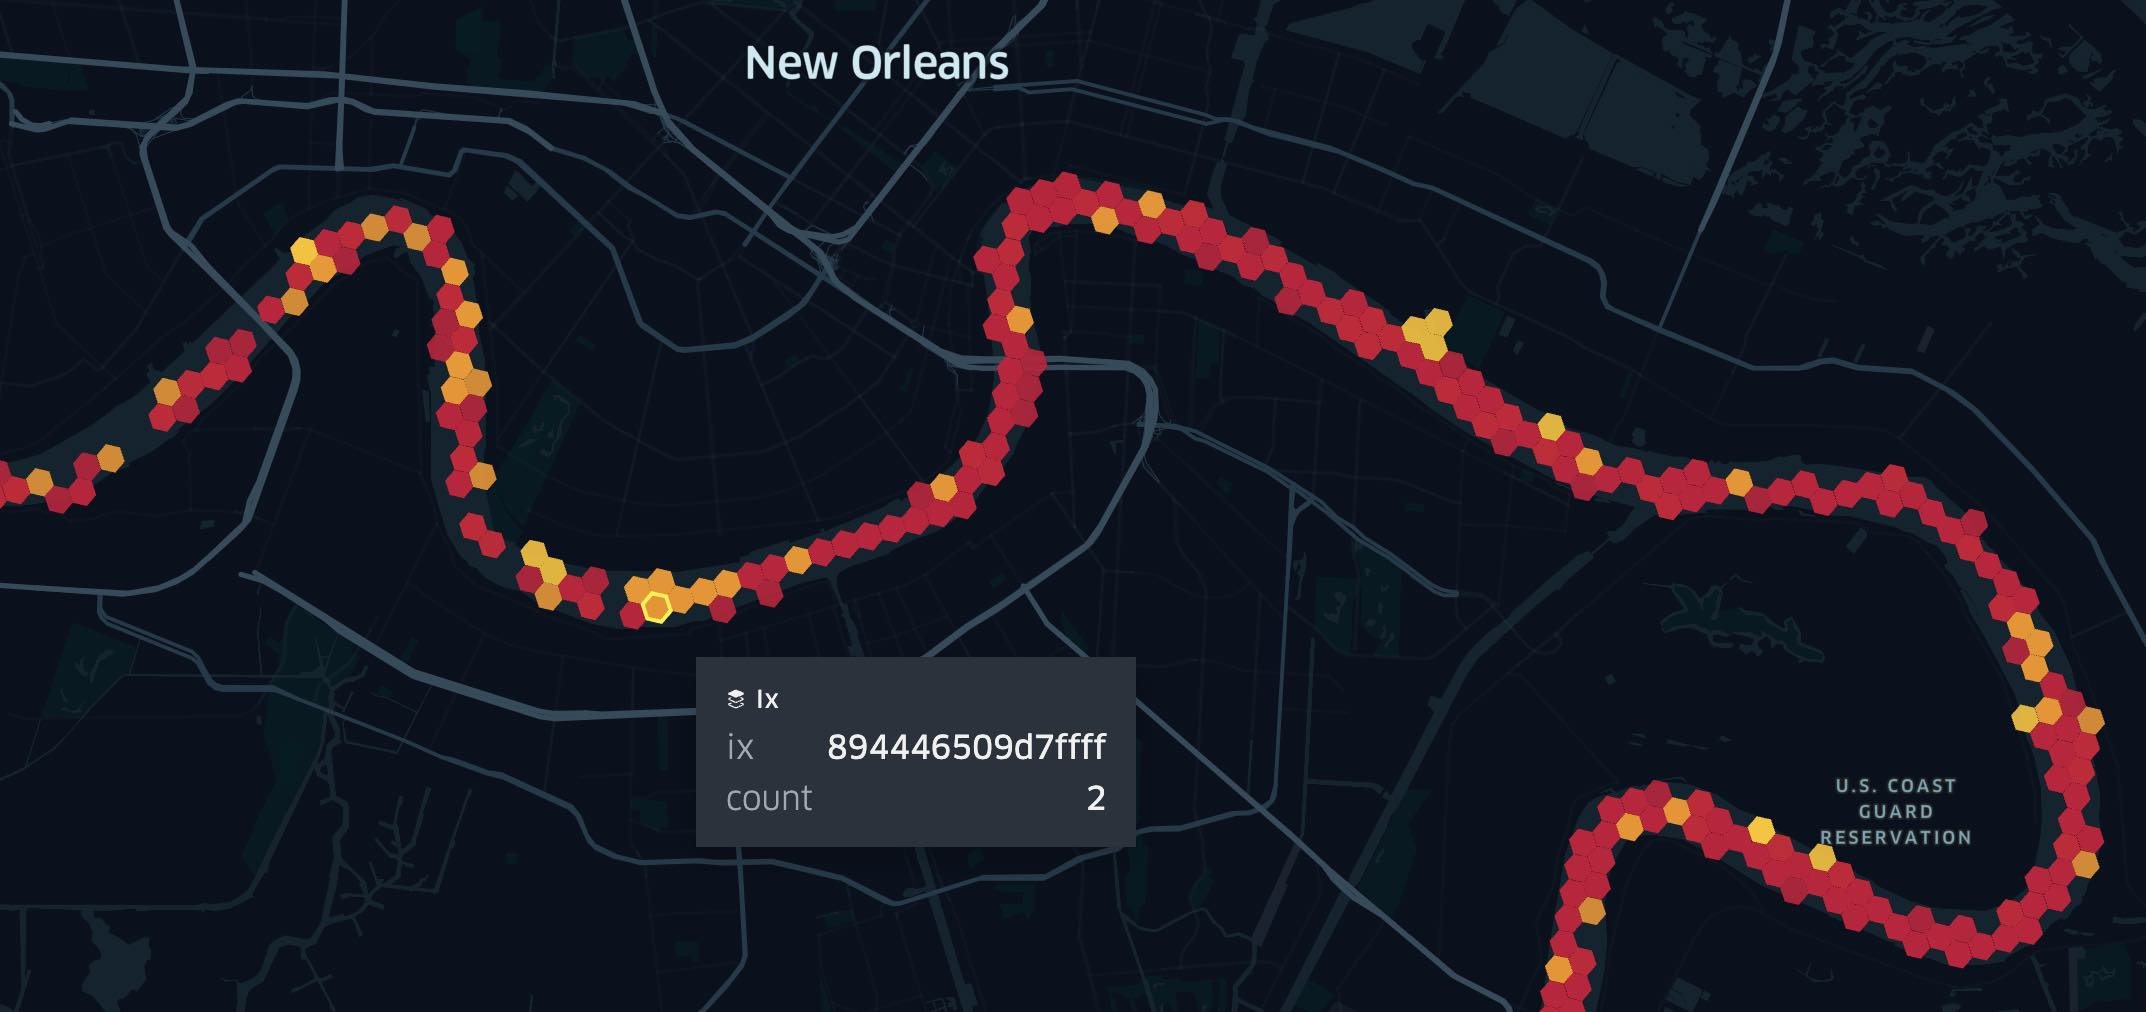

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAACGKgAwAEAAAAAQAAA/SkBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wALABYACgARACNhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/AABEIA/QIYgMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAcHBwcHBwsHBwsQCwsLEBYQEBAQFhwWFhYWFhwhHBwcHBwcISEhISEhISEoKCgoKCgvLy8vLzQ0NDQ0NDQ0NDT/2wBDAQgJCQ0MDRcMDBc3JR4lNzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzf/3QAEAIf/2gAMAwEAAhEDEQA/APAMml3GkIwcUlbmY7caXdTKKAH7vajcKZRQBKCpFN+WmjrRQA7C0YWmUUAP2j1o20yloAdtpNppMmjJoAcoINDKQaTcaezEgGgCPBoxTtxo3e1ADKKfuHpRuX0oAZVywk8q8jbsTg/jxVbK0oKggjgigRv61HmJJR/Ccfn/APqrnK7C5AurFiP4k3D+dcltHrTYo7DKKft96NlIoZRT9hpNpoAbRS7TRg0AKtNpyg5pKAEooooAKKKKACiiigAp38NJSnoKAG0UUUAaWkj/AE1fYH+VWdbP72Mf7J/nUGjjN59FNS60f9IQf7H9TVdCPtGNRRRUlhRRRQAU7p9aOn1ptABRRRQAUUUUAFFFFABRRRQAUU4KTUgUCglySIqSnN1ptBSCiiigAooooAd1H0ptOHpTaACp7f75+lQVPDxub0FAmQ9eaSiigYUUUUAFFFFABV/TZvJu0J6N8p/H/wCvVClBIOR1FAM6jV4fMtfMHWM5/A8GuWrtY2W7tQT0kXB/rXGOhR2RuqnB/CqZEew2nL1ptOXrUlg3Wm0/aSaXCDqc0AR04Ixpd+PujFNLE9TQA7ao6mjco6CmUUATK6jqKkLgcjOPaqtODEfSgVifzR6mkLBurVEVB5WmUCsixgdmo2n2qvS5oDlJ9ppMH0qHcfWnb2HegXKSglTkVKrK/D4zVbzGp6uerAYoDlY5lwSM8VNHhhjHTvUKsskmCMD0qSV/LGB1NMLEE+fMPoKhp4b1oK9xSLGUUUUASr0paiBIpdxoIaZJRUe40bjQHKySmPSbjSE560DSHJ3PpTKeOEJplBQUUUUASxgufLHJbpWwBHY2+Tyx/U1HaQLBGZ5eCR37CqFzMZ239hwBVbEbsgd2kYuxyTTKKKksePu0ynj7pplABRRRQAUUUUAFFFFAD0702nICTgck009aAErS06ya5kEjj92p5z39qLCwa6be/EY6n19hXQXFxBYwjjGOFUd6aRLfRCX9yLa3ZgcO3C/X/wCtXHVPcXElzIZJDk9h2AqChsIqwUUUUiiZPuNUNSITgio6ACpZOAF9KYoyQKGOWNADaKKKACiiigApcmkpR1oAk3DgYprBc8UfxUygB2002lpcmgBtKDg5pcj0pwTcMg0AI45z60yptjFcEfSoulACjuabTv4abQAUUUUAFWbcdTVar0Qwg9+aBMlqpJM2Sq8AVYdtqlvSs+mJIKKKKRQUUUUAFFFPEbt0FADKKsC3P8RxUogQdeaBXKVTLCzdeBVsKB0GKdQK5XFuvcmpVRF6Cn0UxXCiiigQUUUUAFFFFABRRRQAUUUUANZtqlvSs8nJyasXDdE/Gq1ItBRRRQMejlGyKuI4cZFUKmik2HB6GgTRdqpMS77F5xUxlXYWU5oiTaMnqetMlaCRxBOTyaeyK4w1PooEUXiZOeo9airSqvJB3T8qRSZVopenBpKCgooooAeZHIxmmUUUAFFFFABRRRQAUUUUAFFFFAE0ce7LN0FRttDHacirCTKseD1Haq3U8DrQISip0gJBLcelIYHHTBoC5DRSkEcHikoGFFFFABRRRQAUUUUAFFFFAEsMfmzJH/eYCup1N/LsnA/iwo/z9Kw9Kj33in+4C39P61f1uTCRxepLfl/+uqWxD3OeoooqSwooooAKKci72C1b/dxfX9aBNlMDPAq8iBV2/nSBYy+5cEinFtvUHHrTE2V52Awg7c1HG+1ueh4NNc5cn3p4jDKSrZI7UhlwKoXaOlUfmjb3FWIHyNh7U+SMOPQ0xbFInJJ9amSHK7ifwFOW3OfmPHtT5WKKAvFIL9iq20H5c496njEJAGMmoGYsct1qxCMIWPGe9A2TbE/uilJVepxVUBiu+Rjt/nUJIJyBimKxbM6Zxzj1pjbOAg3MfWoVRnOBV5VCgAdqQPQRFKqFPOKRpEU4J5qOaQghUPPeqlMEi59oT0NAnQ9ciqgBPQZqZYcfNJwKQWRaVlYZXmo5Ig/I4NMMwA2xioGeTPzE0wSGkEHB60lPVGc4WmkEHB60ihKKKKACiiigAooooAKKKKACiiigAooooAKsRS4+VunY1XooA0qWqUUpXhun8qudeRTIaFooooEf/9DwJ+cN60ypByn0qOtzMKKKKACiiigApx9abTuq/SgBtFFFABRRRQAUUUUAFPXlSKZTlODQA2inMMGm0AFFFFABRRRQB1mlyeZZqDztJU1zE8flTPF/dYitnRJOZIj7MP5Gq2rx7LveOjgH8RxVPYhbmVS5NJRUli5NG40lFADtxpd5plFAEgfmgtz0pg60HrQA7cPSlJQ44qOigB/yUfKOlMooAfz60c+tMooAf81Kd2BUdOPQUAL83pSZPpSZNGTQBr6PzdNx/Af5ik1r/j6X/cH8zTtFybhz/sf1FR6wc3f0Uf1quhH2jKoooqSwpw9aSlPpQAh5pKKKACiiigAooooAKKKKACpQoFRVPQRNhRRRQZkZUk0m01JRQXdkRGKSnvTKC0wooooGLSkd6bSg9jQAlTxf6t/pUJGKmX/UN9aBMgooooGFFFFABRRTgrHtQA2ipBG1LsA6mgVzf0WbdE8J6ocj6Gs/VYCl2XUcSDP49DTdOnWG7THR/lP4/wD161tXiLWwkXqh/Q1XQnZnN7QPvGn8KMxjNQVIhxk1JTGlietNqUhW6cGoyMdaBiUUUUAFFFFABRRRQAoJFP4b61HRQApBFJTwc8GkK+lADaKKcozQAKM/SlY54HShj2FMoAUEg5HarYKzptPBFU6UEg5HWgTQrKVODQCRVpWWZdrdagkjKH1HrQFxCAeRUdKDin8N9aBkdFKQR1pKACiiigAooooAeeEAplPfqB6UygArRsbbzG85x8o6e5qtbW5nk2/wjqa0LycQp9ni4OO3YU13Jb6Ir3tz5jeUn3V6+5qkhz8p70yikNKwpGDikp7cgMKZQMevQ0ynr3plABRRRQAUUUUAFFFFAFy3G0K3dm/QVcstMMx82fhPTuamsrFpGWSTiNBjHqe/861Lu7js48nlj91fWqSM2+wXNzDYxDgZxhVH+elcnPPJcSGSU5J/SkmmknkMspyTUVJspKwUUUUigooooAenemU9OtNIOaAHJ3PpTKkIKpz3qOgAooooAKKKKACnD1ptO/hoAOxNNpx6AU2gAooooAKKKKAHh2HepHcMQSOoqCnn7goAcQh6HFMKkcU2lzQAlFO3Gj5T14oAFIBBYZFaAxjjpVHahOAa0AqgYBpksrXBwoX1qpUsu7ec8+lRUhoKeqO3QUigFgGOBWgCCPl6UA2VFt2P3jipRAg681PRTJuNCqvQYp1FFAgooooAKKKKACiiigAooooAKKKKACiiigAoqjJIS5IPA6U9ZyOG5oHYt0nTk01XV/umo52wmO5oEVWbcxb1ptFFI0CiiigAooooAliTc3PQVeqONNi47nrUlMhsKKKKBBRRRQBE8av7H1qoyMhw1aFIQGGDyKBpmbRU7wleV5FRIu5gtIu42ippl2tkdDUNABRRRQAUUUUAFFFFAE0IUthqdJDgFl6DtUKttYMO1TpP2f8AOgTuVq0ECAZToarGBv4eRTfJk9KAepb8xM7c8imiVWbaO/eqmwqwDjANXdi5DY5FMloVlVh83SqL7d3ydKuSLuQgVR6UhoSiiigoKKKKACiiigAooooA39Ej/wBbKfZR/M1U1eTfd7f7igf1rZ0qPZZqe7ktXNXUnm3Mj+rHH0qnsQtyvRUkQDOAasNAh6cVJVynRUrQuvuPaoqBiglTkdRQSWOTyTUkbIpywzU58uEbgM56UCuNiiI5buOlWKotI7HJOPpSb3P8RoFYtmJGJJ70zaYVYrzmqwLL8w496tJMrDng0wI0VwjccmkPmlcMpJHQ1bpaBXM8+YTtOfpVhWlPDLkVPS0BchKAniP+lK0ZcYJwOwFS0UBcryxswAXoKYkB6vxVuigLiAADA4qF3LHy4+vc+lSMm4gk9O1KFVSSByaAGJGqe59aXZGozgD61HJOF4Tn3qszMxyxzQOzLJlydsQzSYVTmVsn0qAO2No4+lSLAx5Y4pBYVp+MIMUiQs/zNwKnWJF7Z+tS0xX7DQAowOBVeZo2HXJHpTnidv4s+1RyRhEBHXvQNEFFFFIoKKKKACiiigAop6MFPIyDwaGXHKnKnvQAyiiigAooooAKKKKACpopdnB6VDRQBpZHrRketZtFMnlP/9HwJDzj1ppGDigcHNOfrn1rczGUUUUAFFFFABTh1xTaKACinHrTaACiiigAooooAKKKKAHtyAaZTxypFMoAKKKKACiiigDQ0yTy7xPRsr+f/wBetTWo90KSj+E4/A//AKq55GKOrjqpB/Kuwu0FxZuF5yu4fhyKpbEPR3OMoooqSwooooAKKKKACnN1ptOagBtFFFABRRRQAUUUUAFOPam049qAG0UUUAbeiD97If8AZH86r6sf9Mb2Aq1og+eU+w/rVPVT/pz+2P5Cq6EfaM6iindPrUli42jPemU7tTaACiiigAooooAKKKKACiiigAqeoamoM5hRRRQQJRRRQUMemU5utNoNFsFFFFAwooooAcuDwelTlSsHHOTVarDMRCoHrQJkIVj2pwQ55OKaWY96F60ASeWo6mlwg7ZpKKCLsdnHQUm40lFAgooooAjOVbI+tdkhW8tAT0kXn61yNdDpEu6JoT1Q5H0NNA2c0ylGKt1BwaVO9X9Vh8q7LDpIN3+NUV6Ui3sMPU08ENw1MPWkoKHFSKbTw3Y9KCvcUAMooooAKKKKACiiigApwbHWm10OheFdb8SCVtIgEogxvJZVxuzj7xHpQBhbd3SkY4+UVf1HT77RryTT7+IwzxnDKf0II4IPrVA4IoEMorqdU8GeItG05dV1C2EduxUbt6k/N0yASa5agYUUUUAKCQQR1q5McRYPU4qCFdz57Ckmfc3HQUC6kVFFFAx4IPBpCpFNp4bsaAGUU8r3FdHovg7xHr6ebptozRZx5jEIn4FsZ/CgLnM05eSK9If4TeL1QsI4WP8AdEgz+uB+tcXqWj6podyLfVbZ4HPI3Dg/Qjg/hQK6MtuWNLGjSOEQZJppzmtq2iS1iM0vDEc+3tTQN2HM0djBtXlj+prEZizFmOSetTSO91OM8biAPavQvFXw4uPC+kjVZL1bgeYqFAhXG7POcmhsS03PNaKKKRQ9Dn5T3ppGDikqdiNobHWgCNaaetPVuaaWOaAEwaMGjJo5oAMGl2mk5owaAF21sabp5kIuJh8g+6PX/wCtSafp3mETXAwnZfX/AOtW3c3MVrHkkA9hVJESfRDpriO3X5uuMge1cnczNcS75DzjFOluGmkLE9Tz6moHAz1pNjirDPlo+WjA9aPlpFBkelGR6UfLRkelABn2o3GjI9KM+1ADkY5ppJzTlb5qUEl6AEkJ4B7VHT2ck880nFADaKdgdjSYNACUUUUAFOPYUg607uTQA09aSiigAooooAKKKKACnvwAKRRkihjlqAG0UUUAPjXewWrfkx+lR268FvwqzTJbIRAoIIJ4qaikJwCT2oJIJ+ADjrVb5T7UMxY5NNpFodj0pORyOKSlyaBkizOvfP1qUXH94flVfI7ijA9aBWLoljPf86fWfg0AsvQkUxcpo0VSE7jrzUq3Cn7wxQKxYopgdG6Gn0CCiiigAooooAKKKKACo5W2oT3PFRzuygBeM1UoKSCiilAJOBSKLNuvVvwqKVtzn24qyx8qPA+lUaBLuFFFFAwooooAKmhTc2T0FQ1cjyFCoPqTQJkoJJPoKdSAYGKWmQFFFFABRRRQAUUUUAFRPEr89D61LRQBRkWReH5HrUVaXXg1A8APKce1IpMqUUpUqcEYpKCgooooAKKKKACnKCxCjvTakiOJBQBbRNi4zmpKKKZmRSoXXA9c1J04pjB85U/gaTzMcOCv8qBktQyxhlJA5pD5uSVIIPSoBJKO/SgEhHjKAZ71HTmYudxqaBMnee1IojdCmPcVHWkQDweaoyKFchaATI6KKKBhS4PHHWkrUsf30saY6EZ/CgTdjoG/0azP/TNP5CuLrq9Wl8u0Kd3IH9a5SqZMSxbj5iat1BAMJn1NT0gZDMxVOO/FUquTkbMepqvGnmHGcUhrYREZzgVYkASLb1oij2sSGyKZcNlgvpQHUr0UUUFFtAsaYkPXnFR+aq8RL+dQVbhjI+ZutBI0RyScucCpljROg59afUEk4HCcn1pi3J+nJqMzRjvUUJdmLMSRUyxIvIFADPPTPQ1IJEPQimTIzD5cf1qJd4AUpkD1FAWLVHTk1XKDGWjI+hpvmBMKFOB60BYshlPAIpkiyNwpAFMEzHkIaN056KBQFiF0C4UHLd6kFvx8xxTfIc8kiniAqdwbkUh3JUjVOnX1qSkGe9LTJCiozLGO9AljJwD1oCxJULxs/wDFx6U15WjbHUdafHIJB6H0oGReQB/FSM6BPLHzY708wZbJbrTxEgGMZoHco1N5RYbkORURxk46UAkHI4pFAVKnBGKSpZDuCt3xg1GFLdBmgBKepIOAMg9qPLf+6alVdh2ry5/SgVyORAjYBzUdX1jULtPOetVZIinI5FAJkVFFFAwooooAKKKKACiiigD/0vHzoi/wykfUf/XpjaNLtwsinHqMVWGpXg/jz9QP8KlGrXQ67T9RXToc12MOjXY6FD+J/wAKiOlXo6ID9CKuDWJv4kU/TNSjWf70X5H/AOtRoPmZkmwvF6xN+HNRG2uF+9E4/wCAmugGsQ/xIw+mKkGq2p67h9RRZBzM5Yqy/eBH1ptdgNRs2/5afmD/AIUvn2EnVoz9cf1osPnOQ6j6U2ux8rT36LEfpj+lNOnWL/8ALMfgT/jRYOc5CiurOkWZ6Bh9DUJ0W3P3Xcfl/hSsPmRzVFdAdEX+GUj6j/69RHRJf4ZFP1BFFmHMjEorWOjXY6FD+J/wqI6VejogP0IosO6KCnmkIwatmwvF6xN+HNMktrgcmNx+BpBcrUU4qy/eBH1ptAwooooAK7DTpPNs4yew2n8K4+ui0STKSRHsQw/H/wDVTRMtjDuI/JneP+6xH4VDWrrEey63jo6g/iOKyqTGtgooooGFFFFABTj0FNpx6CgBtFFFABRRRQAUUUUAFOam05utADaKKKAN/Qx/rj/u/wBaz9T5vpPw/kK09EGElPqRWXqDf6ZLj1/pVdCF8RT6fWm0UVJY7+Gm07+Gm0AFFFFABRRRQAUUUUAFFFFABUgf1qOigTVybNLmolJzipKCGrBRRRQIiPU0lPYDrTKDRBRRRQMKKKKACp5eET6VDVidSAn0xQIrU5etNp69aAew+iiigzCiiigAooooAOlXdNnEV0vPD/Kfx6frWex7U0EggjgigpR0Ol1mHfbrKOsZ5+hrnU9K7Abby09pE/I//WNcYQVYg8EcVTBaqwlFFFSWFOBIptFAEhAbkVHSg4p+Q3XrQBHRSkEdaSgAoopetAABmvf/AIKjFtqg/wBuL+TV4GflGB1r3v4Kf8euqf78X8moInsdB8TPCP8Abum/2pZJm9s1JwOskfUr9R1H5V8wd6+nfD/jQt4t1Pw1qb9blxbMeny8bPxxkV5t8TfB50XUf7XsUxZXbZIHSOQ9R9D1H5UMUXbRnpnxL/5ET/gUH8xXzfpul32r3sen6dGZZpTgKP1JPYDua+j/AImf8iJ/wKD+YrnfgxpqeRf6u4BcssCH0AG5vzyPyo6hF2jczrH4L3skIfUNQSGQ/wAEaFwPxJX+Vcz4n+GuseHLdr9JFvLVPvugIZB6spzx7gmtfxne+Or7XrlbSO9jtYZCkKwBwu1eN2V6k9a9N+H9zrmpaHPZeJ4ZSyN5YadSGeNhyDnk49aAu1qeMeEvAtz4ss57i2u0txC+wqyliSRnPBrhb21lsLyayn4kgkaNvqpwa9s+F8w0rxTq/h4t8uW2e5hcr/I1xvjzSHXx3PZxD/j9kjZPrLgH/wAezQNPWxq6b8JtT1HSIdUF3HG08QlWIqScEZAznqRXlJRg5jI+YHGPevtVb22sr+00JSAzW7Mo9o9oH6Zr5nutCx8Rjo4HyPfAgf7DNv8A/QTQ0EZX3JvEXw6u/DmirrF1do+SimIKQQW7ZzzivOq+gPjRqG210/S1PLu0zD2UbR/M18/0Di7rU6nwZoi+IfEVrp0v+pJLy4/uIMkfj0/Gvo7xf4rtPBWmwJbwK8snyQQj5VAXqTjsOK8m+DUSt4gu5D1S1OPxdam+M8jf23Yx9ltyR9S5z/Kgl6ysMg+MuuLMGubO3eLPKruU49iSf5V63qVnpvjzwoJI1yLiPzIGP3kkHT8jwa+R+GHvX1H8KHZ/CESt/BNIo+mc/wBaaCStqjwnwn4VuvE2pSWUUqwPAhdi4J6HHQe5retfhz4g1TVLjTt6x29q5Rp2ztJH90dSa6z4eosXjzXIV6IJgP8Av6K1fiR44u/DssekaLtjuJV82WTAJUHIAAPGTjOTSC7voeY+K/A7+EJ7FzdC5Fy+B8m3BUjPc+tewfFn/kT2/wCu8f8AWvnq917WNcurdtWuXuDEw2bscZIz0Ar6F+LP/Int/wBd4/60A91c+btJ0nUNbvU0/TYjLM/boAO5J7Aeteu2fwWu3hDX2opFIR92NC4H4kr/ACrZ+DOmJHpt5qzAb5pRCp7hUAJ/Mn9K47xVe+Pb/XLl4Y76KCORlhWEOFCg4B+Xgk4zmgbbbsjK8UfDrWPDMJvty3doDhpEBBXPTcp6D3yayfCvhW/8W3UtrZyRxCFQ7tITwCcDAAOa+g/BEur6z4bmsfFEMm/LQ5mXDPGw6kHnI5Ga+cbS+1jQdSubTRppI5mZoCYxlmCt24znjtQCbeh6zH8Fj5Y8zVMP/sxcf+hVwvivwBq/heIXjut1aE4MqAjaT03KemfXJqWOx+JhIvY11LP3slnz+RP9K90uBeap4Am/tmMpcvZOZVYYIdVJyR2OQDQK7R4B4R8EXni6G5mt7hIBbEDDAnJYEjp06V0+kfCDWLyMTapcpZA9EC73/HkAfnXR/BX/AI8dT/66x/yNcZ438aeJP+EivLK2vJLaC1laNEhOzhTjJI5JNA7tuyLPiD4T6vpVq97p0630cQ3MgUrJgdSBkg/nXm1jbtM4YqX5Cqo5LMegr6T+F/iLUdf0e4XVJPOltZAgkPVlYZGfUjmvMNKhstO+IqWkuFgivZEQHoDltn64oFd7M6PT/hdrN3Esuo3aWhYZ8tVLsPryB+prG8RfCrUdMsZ9Uiv0uVgQu6spRtq8nHJH8q9E+JFh4tvLa3bw48nlJu86OFtshPGDwQSPYV4Bda54qtoZtKv7q6VJBtkimLcj0w3IpsI33OcHWnvTBT27UjQZRRRQAoGTinMoApF605ulBL3I6KKKChy9af0yajHUVJIeMCgCKiiigApcmkooAdu9aPlptFADwO4owQKTotKSRgUAMop2fWj5T7UANop2PSkwaAEooooAen3qaetKpwwNDfeNADaKKXpzQBfRdqgU+qguG7gGp45BJ04xTIaJKrztgBfWrFUJG3OT+FAIjooopFhRRRQAUUUUALS5NNooAdkGlKcA5600cnFOfrj0oAbg05XdehpuTS59aAJhcMOozUyyo3fB96p4B6UhBFArGlRWesjp0PHpVhZ1P3himTYsUUgIPIOaWgRHIgdcd+1USCDg1pVBLEG+YcGgaZTqeBctuPaomXaxXOcU5JWQYHSkUx0zlmx0AqGnu5c5NMoGgooooAKKKmhTc2ewoAmSFV5bk1NS0UzMKKKKACiiigAooooAKKKKACiiigAooooAayhhhhmqrwEH5OauUwkAFz0oGmUCCpwRikq6uZB+8X6VE8BHKc0irleil6cGkoGFKCQcjtSUUAWVnJYBuBVms2poS28AdO9BLRdpOtV5HfftQ1YGcc0yRnljqp2/SmsGKlWGQe4/wqaqTyMHYKTigaBIS4yD3q2AFAA7VSjL7gqnGauZYdRn6UDY+qs6AfOO/FWQQelRzDMZoEijT9jYDY61JDsyd36055uNsfT1pFXK1bejIzSM/wDCgx+JrF5J9Sa7CxgFraqrcHG5vrTQpPQxtZm33CxDpGP1NY9SzSGaZ5T/ABEmoqTGlZGhGMIB7VVkkfcRnGDVpHDjI/KopYix3L170yVvqVKXJHSlZGX7wxSdaRYAkcg4qeNC+Wfoe9MAEeC4yfSmtIzcHp6CgQ6SJk56j1qMAk4FPicI2T0qyhizlMZNAXsJHCF+ZutTUtVp5MfIPxpk7kcshY7R0pI4y59qaiFzgVdJWNfQCkN6aDgAowOAKZ5qYyTVXLzNioqYWLpnjHTmkE6E85FU6KQ7GkCCMjmiqUJIcAd6uAEZyc0yWh1FNZgoyelAYMNwPFAh1FQmdB7/AEpHmAUFOc0DsSO20ZyB9aiMsbjkkD09arMxY5Y5ptIdiaR1I2oMAURx7huJwBUNLk9PWgZckiEhznFRiBlOQ2Md6SFyAV74yKQs0n3kz9KBajzKkY2pzTxMrMFHfvVMgg4PFH0oHYlMMmeBUbKVOD1q5vbyt/Q471TZix3HvQCG1OjSBcpyPSoKcrFTlTigZbLtwg+8evtT0QIMD8TVaA/vOfSrlMhhTcjdsPpS1B5oRmDc89qAIpYtnI6VDVuVleLOfpVSkUgooooGFFFFABRRRQB//9PwWiiitzmCiiigAooooAKKKKAEpwJHTim9xS0AL586H5ZGH0JqQX12vSVvxOarsO9MoNFqjQGp3w/5aZ+oH+FSjWLsddp+orKop3CyNoa1P/FGp+mRUo1z+9D+Tf8A1qwKKLsXKjpBrcH8UbD6YNSjWLQ9dw+orlqKLhyo64anYt/y0x9Qf8Kd9p0+Tq0Z+uP61x9FO4uRHYeVpsnQRH6Y/pSHTrF+fLH4E/41yFKCR0ouHL5nVnSrI/wEfiamt7GC1cvFkEjHJrkhPMv3ZGH0JrY0mW4mnbzJGZVXoTnmhMTT7mrd2UV4F8wkbc4x71ROiQdpG/SotTvJ4bgRwvtAUZ+tZ/8Aad9/z1/Qf4UNoEnY0zokfaU/lTToY7Tf+O//AF6yvt95knzW596f/aF6MYlP6UrodpGgdDPab/x3/wCvTToknaUflVMapfD/AJafoP8ACnDVr0fxA/gKegWkWDok/aRf1pDo1zjAdPzP+FRjWLsf3T+FPGs3WMlUP4H/ABo0D3hp0a79UP4n/CmnSLz0U/jUw1ufvGv604a2/eIfnRoHvFU6Ve/3R+Ypp0u+/wCef6j/ABq+Nc9Yf/Hv/rU8a2neI/nRoF5GWdNvR/yyP5j/ABppsLwf8smrYGtQd42/SnjWrXurj8B/jRZBdmF9iux/yyf8qc1pcZ/1Tj8DW8NYtD/eH4U7+1bLuxH4GiyC77HNtbyKMlH/ACNQnjjGK60anYn/AJafof8AClN/YvwZFP1FFg5n2Keif6mQ/wC1/Ssa+ObuX/eNdbA0DqWt9pXPO31qu9jZTMzMgLE8kE9fzotoJPW5x9FdS2j2h6bl+h/xqBtEjP3ZSPqM/wCFKxXMjn/4abW42iyYwkgP1GP8agbR7sdNrfQ/40WY+ZGVRV5tNvV6xE/Qg1A1rcp96Jx+BpBcgopSCvBGKSgYUUUUAFFFFABRRRQA9R3p9NXpTqDN7hRRRQIa3So6cwOabQaIKKKKBhS9aSpAuKBN2FwKkmchtp5HWmUkpDFSDniglCZWgEdqjooLJ+vIpKYrYp5IxmghoKKTcKCcDNArC0UgIPNMJzQCQE5ptFFBodLo026FoT1Q5H0P/wBesvVIfKu2I6P8w/Hr+tJpk3lXag9H+U/j0/WtXWYd0KzDqhwfoaroRtI5qiiipLCiiigAooooAeGzw1IVxz2ptOVscUANqThB71IUCruHU1AeetABXv3wU/49dU/34v5NXgFe1/CTW9I0mDUY9Tu4rYyNGV8xguQA2cZoJlseeeLZJIfF+pTRMVdLt2Vh1BDZBFfQfhXW7Dx74daz1JVeeMBLiP1I+64+uM/WvnLxTcwXfiPUbq2cSRSXEjIy9CC3BFO8MeIbrwzq8WpW+So+WVOzoeo/w96Aauj6F+KihPBkqL0WWID8DWN8GbqN9FvbMH54rjeR7OoA/wDQTUXxD8U6BrHhAx6feRyyyyRsIwfnABycr1GK8r8D+K28KasbmRTJbTrsmUdcZyGHuKOpCXunfeIfiX4o0jXbzS0ht1SCVlXejElf4TncOorFb4veKeQEtf8Avhv/AIqvTrmb4c+NFW6upoGlAA3O/kygehyVJ/Wsa70b4U6NbSvJJBI5QgDzTK2cdgCefwpgrdjyfwnrk0XjW11a6bDXFwRKRwP32Qfwya9w8Q6Cbzx9oWohcoEcufeH5l/Vq+YFbY4eM4ZDlT9OlfWll408K3VnbX9zf26TiIEqzAMpYDcMdeopIcu6POvEXiAwfFSyKv8Au7Ux2zfST73/AKF+ldvceG/M+IsOugfu0tgx/wB/DJ/LFfNutam1/r13qsZ5luGkQ+275f0xX1PZ+NvC81pDdS6jbpI8allZwGBxkgjrwaEKSseEfFbUPtviySBTlbSNIh9cbj+rV5tWnrV8dT1e81AnP2iZ3H0J4/Ssyg0S0PUvhFeLb+KWt3OPtMDoPqCG/kDXQfGjT5vtFhqiqTHsaFj6EHcM/XJrxnT7650y+h1C0bZNA4dT7j+h719N6T468J+KdPFrqzQwyOAJILnG0n/ZLcEenegmWjufLSqWbaK+tPh5YvpXhG1FwNhffMd3GAxyM/hg1BHoXw4sX+1qlipXnLSBh+TMRXJeO/iTp39ny6P4fk86WddjzJwiKeoU9yRxxwKZLfNojM+F1wLzxjq92vSaOSQfRpQa5n4sEnxhL7Qxfyqb4Vatp2k63cSalcJbpJblFaQ4GdwOM/hWZ8SNQstU8UTXenzLPD5ca70ORkDnmkV9o4m2/wCPiL/fH86+nPiz/wAie3/XeP8ArXzFAwSeNm4AYE/nX0F8TPEmhal4X+y6few3ErTRkJGwJwM5OBQEt0aHweuo5fDc1qD88FwxI9mAI/ka5HXPij4p0vV7vTvJt1EErIAyMTgHg/eHUc1yHgTxd/wiepO9wpktLkBZVXqMdGHrjJ4r2q7/AOFb+M8XlzNbtLgAsX8mTHoclSfxzQJqz1PMD8X/ABTjHl2oP+43/wAVXbfCbTYZrS88TXKh7q4nZQ2OVAwzY9Mk1HqWk/CvRrC4+eCSZo2CYlMr7scYAJxzXMfDDxpp+hrPpGryeVDM/mRyHlVbGCD6A4HNAPVaEeo/FzxE99KLBIYYFYhFZNxwPUk9fyr2CDU59Z8ByandKEluLKVmC8DO1hx9cVyWo+HvhaZ21i5u4lVzvMcc42sevCrk8+grQfxx4UvPDV/b2c6WyxwyQRQt8rEbMKVX0OaZL12Rh/BX/jx1P/rrH/I15L4vjeXxfqkaDJN1J/OvRPhLrukaTbahDqV1HbNI6MvmNtyACDjNcfqsltdeItTvrdhIk07sjjoVJ7UIrZtnqHweiENjqKDtKmT/AMBNeMeMHb/hK9TIOCt1JjHb5jXqXwx8Q6LpsWoxahdxW5eRSvmNtyACDjNeeyX+jzeO5dQvWEmnyXbuzAZBRiecelJgt2zc0L4sa9piJb6gq38KcZf5ZMf7w6/iK9gK6F8SPDTXHkkZDKrOAHikUdj+XsRXOt4T+F2qn7VbXMUatziO4Cj/AL5Y8fpU2reLfCng7Qn0rw7JHLNtZY0ibeAzfxO3P880xOz2PmtlKMUPVTilboKZkk5Penn7tI1GUUUUAL0pSxNNooAKKKcFY9ATQAg60+Q5OB2pyxS/eKNge1RHrQAlFFFABRRRQAUUUo60AKeoFIetKOpNNoAKKKKAClyaSigB2fUUfLTaKAHY9Kc46Uwdac5yfpQAyiiigAq1bjq34VVq/ENqD86BMcx2qT6VnVcnOEx6mqdAkFFFFBQUUUUAFFFFABRRRQA9Bzn0ppOTmnDhCfWmUAFFFFABS5NJRQA4YY46UFSD60q8Zam5PWgABKnIOKnWdh94ZqHOetGPSgLF1ZEfofwodto3en86o0pZiME5FBNhtFFFBQUUUUAFFFOVS5wKAFRC5wKvKoUYFCqFGBTqZDYUUUUCCiiigAooooAKKKKACiiigAooooAKKKKAEPp61E/zMI/xP0qTPVj0FMjGcuerfyoGSUtFFAhjxq/X86qvCy8jkVco6UDTM2irzxK/PQ1VeNk69PWkUmR05WKnI7U2igZZjYvLuA471arNBKkEdqtC4XHINMlomY7QT6VnVK8zOCvGDUVIaRchjAUMRyanqhGzBgAfwq/TJYhAPWmO2xc9fY1JVa4PAWgEM2xv9w7T6GjyHxn9KhwR1FPR3U4U/hSKNDTbcSzAsOnJ/CtfVZ/Jtig+9J8v4d6fp0RSHzG+8/8AKsLU5/OuiB92P5R/Wq2RC1ZnUUU9FLsAKk0CMkOMVfpgiQHIFSUyGymszFxk8ZpxVkYvGAQaSWLB3KODVhECLgUDKBJJJbrSVobE64FLtUdhSDmM8Ak4HNWooip3N1qbAGT0qNmLfLGee5phe45m52L1/lVeRRvCIOe9KziMbYzk9zUsSY+dvvGgNhyII1/maps7P1PFSzSZ+Reneq9IaRPAcPj1FWDFGTkioOIlKn7xHbtUKsVO4daBWuTSxgEbF+tRrGzDK81ILg9xmkNwx6ACgeoqssI9WNRM7OfmNMooCxJGNzBSeDVgzovAzx6VUpKAsWHeNl2qMGmuFRfLzk5yahqRyrYI645oAjooooGFFP8ALbZv6CmUAOVipDDtU4uP7w/Kq1FArFwyROMN+tAaNT8i5+gqnShivIOKAsWplJG/PA7VUp7Oz/eOaZQCCrUMaldx5NVaesjqNoPFAMdInltx07VYjlDjng1TJJ5NJQFjSzWcSWOe5qRFjIy5x7U8yD7sK/jQJaERQqMtx7UypvJkJyf1qWKLadz9e1A7lZlZcbuM02nudzk5zzTKBhRRRQAUUUUAf//U8Tu7PYDLDnHcelZu41etLxkIik5U8Z9KS+thEwkThW7ehroMV2ZUDetLketRUUg5SaioaKBcpNRUWT60bjQHKSd80tR7jRuNAcrHkZFRU7cabQNKwUUUUFBRRRQAUUUUAFFFFABRRRQAV0mix4hkk/vNj8v/ANdc3XYaegiso88cbj+PNNEy2Od1J997IfQgfkKo1LO4kmkkHIZifzNRUhoKcegptO7UDG0UUUAFP2t5e/tnH40qR7huY7V9f8KlZg0BVRgKwx68g0CK1FFFAwooooAKKKKAFHWg9aB1oPWgBKKXGaXA7mgDptGH+iH3c/yFc9ck/aZSP77fzro9IGLT6sa5uXBlc56sf51T2IW7BbidPuyMPoTU66jer0lP44P86qY96Me9SVY011e7UAna31H+FTLrco+/Gp+hx/jWQV+Uc03aad2FkdCutxH78bD6HP8AhU66xZt13L9R/hXLbTRg0XFyo68ahYvx5g/EEfzpf+JfL/zyb8q4/Bowadxcp150+yfnyx+BI/lULaRZt03L9D/jXMKXXkEr9KnW6uV+7M35mi6Dlfc2jokP8MjD64NRHQ/7s35r/wDXqguo3y9Jc/UA/wBKlGq3o6lT9RRoFpEp0Sb+GRT9c1GdGux0KH6E/wCFSDWbkfeRD9M/41KNbb+KHP0P/wBajQPeKf8AZl6vGwH6EU02F2OsZ/DmtIa1F/FGw+hzUo1m0PUOPwH+NFkJ3MQ2tyvWJ/yNRmORfvKR9RXSDVbI9XI+oNSi/s26Sr+PFFhanJ0V2Hn2sn/LRG/EGl8m2f8AgRvwBosK5x1JgeldebK0PWJfwGKjOm2Z/wCWePoTRYLnKYFLXStpNqehYfQ//WqFtGjP3ZCPqM/4UrDuc6x7Uyt1tEk6rKD9Rj/GoG0a7HQofx/+tRZlpoyaK0G0u9X/AJZ5+hFQNZ3a9Yn/AAGaVh3RWpwPY0rRyL95SPqKZQMeVyeKCQfl9KRWxSsO9ADelJTs54NIRigBKKKKAFBKkEcEV2R23ln/ANdE/X/6xrjK6XRpw0LQE8ocj6H/AOvTRMu5zZBBweopK0NTg8m6YgfK/wAw/Hr+tZ9IpBRRRQAUUUUAFSAbRk9aAABk0wkk5NAC7jnNO4bp1qOigBSMUlSAhuDTSCKAG0UUUAFFFFAEvyiL3NRU4DI4602gQU8EHhqZRQMcVxTacGxweRSle69KAGUUUUAFalnaDZ50vAPT6etQWdt5z72HyL+vtU99c5/cR9B97/Cmu5LfRFKeRXc7OFHSoKKKRQUoOKSigB5AbkUgGOTQvXNP4k9qAGDnk0h5pW44ptABRRRQAVJGFJ2ucCo60tOsvtTl3yI06+59KBMu6fYrIPOddq/wjufc1JfTpbRtFB948E1dvbtbOH5QNx4UVzrXrsc7QP8AGq2IV3qUwjHoCaeLeY/wN+VTG8lPXFRm4c9l/wC+RU6F6lhNOmZQxYDNSjTG7yD8qiXUJUUKFXj2/wAKQ6hcH+6Pwp6E+8WRpi93P5U82ECrl2bA/wA+lUDfXJ/ix+AqWO+mQZf5x709AtIk8rTl6vn8f8KM6avbP504vYTjfINjd/8AIpudNXoM/nQAefp69I8/h/jR9stR92H9BR59gvSPP4f40fbbZfuw/oBQFg/tFR92L9f/AK1L9vmb7sX8zSf2kB92LH4//Wpp1KTsgouFvId9vmHLKB7c0v2y1l/10eD69f8A69L9ujYATx5/X+dJs0+bodh/L+fFAfIPs1lN/qpNp9M/0PNRPp0y/cIb9Ke2nEjMThh71F5d7b/d3Y9uRQHoys8Msf31IqKtFNRmXiRQ36GpPtFlN/rU2n1x/UUh3ZlU4dzWn9jtpeYJPw61C9hOo+XDfSiw+ZFL+Gm1JIjpgOpH1qOkMKKKKACiiigAooooAenX6U08mnJ1xTT1oASiiigByjLAetaHSqcAy+fSrtMllWdyDsH41XAzSucuT702kNC4NJS5pxJwBQMZRTuKMDsaAG0UuDSUAFFFOUZIFACtwAtMpzHLGm0AFFFFABRRTlGT9KAHNwAtR0pOTmkoAKKKKAHZpDjtSUUAFFFFABRRSgFjgdaAFVSxwKvIgQYFMC+VGSOTSLOrEDBBNMl6k9FFFBIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU0nA96dTep+lADH6CMd/5VJ04qNPmYv8AgPpUtABRRRQAUUUUAFJS0UAQPArcrwaqsjIcMK0aidwuAwyp70DTKNFWWhDDdGarkFTgjFIq4lFFFAyaD7/4VdrPRtjbutXUfeu7GKZLH1UZg8qkdOlTNMinGc/SlXYclecnNAth9RJBvuESM4LHp6e9Nllx8qde5rT0aDJe5b/dH9aA2VzVupha2rOONowv16CuN68mt7VmaWRYF4VeT9T/APWrLCRR8scmhhHRESQs3J4FWlRUGFpWYKu7tVUTtuyenpQPVlymswUZY4phmQLuBz7VUd2c5agSROJgSS3AHQUv2hPQ1UpyqWOFpFWROBM56kD16VOWReCaiMnlrtzuaqzMWbce9ArXJyqMNzOSAaYXLfJGMCmKC7Bc1YJSBcDk0AOjiCcnk02aTb8i9TUO6WQ8Z/CkVgnQfN79qAsSpACMv1NR5WNzj5sdKaZHP8RpvXk0DAkk5PWkoooGFFFFABRRRQAUUUUAFFFFABRVsRAx9MNiqlArlsqJsYOAB0qqRgkHtTkco2R+NLKwZ8rQBHRRRQMKKKKACiiigAoop4R26CgBlFSGJ17flUdABViHYSOzD9agAJOB1o5BoA0aqyy5+Venc0wyuV2n86ioJSCiiigoKKKKACiiigD/1fn+tuY+bY7264B/GsSt+GF57MRJjJXvXQjGRgUVNPBJbyGKUYIqGkUFFFFABRRRQAUUUUAFFFSeW+3djjrQBHRRRQAUUUUAFFFFABRRRQAUU5UZzhRmtqx0xJMTTZK9h2P/ANanYTdiLT9OM5E0wxH2H97/AOtWlqs4gtvJTgycADsB1/wq1dXUdpEW6kdF/lXIzTSTyGSU5JpvQlau5FRRSgEnA5JqSxKegLHaoyT2FaltpE0uGm/dr6d//rVuw21tZrlAFx1Y9fzp2Jckc/DpN1JgviMe/X8q1I9HtlH7ws5/KmXOsRR5W3G9vU9P/r1iTXlzMcvIfoOB+VPRC1Z0T6XavjO4YGBg0xdIt0ztd8Hgg4wf0rl8nOc81KLidfuyMPoTRcOV9zdfRYj9yRl+ozUJ0Rv4ZQfqP/r1mLe3a9JW/E5/nUw1O+H/AC0z9QP8KNAtIsnRbjs6H8/8KjOj3Y6bT9DQusXY67T9R/hUq63N/FGp+mRRoHvFY6XfD+DP0IqM6feDrEfw5rTXXB/FD+Tf/WqUa1b/AMSOPpg/1o0C8jGSxu2YDymH1GKvR6NMxzKwUe3Jq62s2wGVVifTAFU5NalP+qjC/Xn/AAo0C8i/HpNqgG/L/XgfpVk21lGMtHGB6kD+tczJqF5J1kIH+zx/KqjMzHLEk+9Fw5X1Z28Pk+WDBt2dtvT9KryWNnNyYxz3Xj+VN035bCP6E/qa5JWZTlSQfam2JI3bjRuN1s3/AAFv8axZYZYG2yqVPvWpa6vLHhLgb19e/wD9etxJLa8j+UiRT1B/wpWTHdrc4qiujuNGjY7rdtnseRVM6LdDoyH8T/hSsPmRkUuTWkdJvB0Cn6Gozpl8P+Wf5Ef40WHdFHJoyatGxux1ib8Bmojb3C/eicfgaQ7kNFSiGQ5yNoHUngUvkufu4b6EGgCGinMjLwwI+tNoAXJoyaSigBcmlz602igB2AelJgikpckUAJS1Kse9GfONtR8D3oAkEsq9JGH0JqVbu6XpM34mqlFAGguo3w6S5+oH+FSjVrxepU/UVlUU7isjZGtXH8SIfpkf1qUa4f4ovyb/AOtWDRRdi5UdGNbi/ijYfQg1KNYtD1Dj6j/69cvRRcOVHXLqlkf48fUGl+1afJ950P1/+vXIUU7i5Edf5emydBEfpj+lJ/Z1i/Kp+RP+NcjS9KLhy+Z1DaPat0Lj6H/61QtosZ4WUj6jP+FYSTzJ912H0JqcXl2OVlb8Tn+dK6Cz7l9tEkH3ZVP1GP8AGq0uk3cY3AB/90/40+LWLpOJAHH5H9K0odYtn4kBjPvyP0p6B7yOZZWQ7XBU+h4q1YSmG6R+x4P0rrFeCdflZXHtzVd7CNmDI7IR2zkfrRYOYh1W38628xeWj5H071ytdxDG6QiOUhyBjPqK5C7gNtcPF2ByPoelDCL6FaiiipLCnqAPmNCjuelIzZoAQnJpKKKACiiigAp4bsaZRQA8r3HSmU4MRTiu7laAI6KKKACnZz1ptFACkYpKUHFOG00CGUoJHSgjBxSUDJMBuR1p0MLzSCNfxPoKjUMzBV5J6VuKEs4ct94/qaaRLdhlzMlpEIYuGI49vesSpJWd3LvyTUdDY0rBRRRSGFKBmkp3QYoAD6CjpwOtA45ptADwQeGpCpFNp4bselADKKeV7jpSKrOwRRkk4AoAlt7d7mURJ36n0HrXWEw2Ft6Kg49Sf8TUdlapZQZfG4jLn/PpXP394buX5eI1+6P61WxHxMgmuJLiRnkP3u3p7VBSU48jNSWNooooAKKKKACnj7tMp6/dNADKKKKACiiigApQMmkp6dc0AI55ptKaSgByu6HKMR9Ktpf3CdSG+tUqKBWNUX0MnE8f9aPKsJvuNsP1x/OsqincXL2NJtOkHMbhv0pv+nQH+LA/EVTjkkQ/IxH0q2l/Ov3sMPejQLMkXUX6SIGHtxTvM0+b7y7D+X8qPtltL/r4/wAetH2exm/1T7T6Z/xpiENhHIMwSZ/X+VVnsbhP4dw9qmbT5kOY2B/Q03zb6D727HvyPzoC/ZlJlZThgQfem1prqAYYmjBHt/gadjT5v9g/l/8AWpWHfuZVFabaduGYZAR7/wCIqq9pcJ1Qke3NFh3RXXqKVvvGlUHdg9qaTk5pDEooooAt24wpPrU5OBmmoNqgUSHCN9KZBn0UUUixR1oPWlHrTaACiiigBcml3etNooAd8p9qeg6sKiqQ8J9aAGYNJS5NLn1FADaKdgHpSEEUAJUnRfrTAMnFOc5P0oAZRRRQAUUUUAFFFFABRRSgZ4FAAAScCpyRCuB940oAhXceWNVySTk9aBbi7mznJzSAkHI7UlFAyytx2cflVhXVvunNZ1L0oFY0qKpLO68HmrCyo3fB96ZNiWiiigQUUUUAFFFFABRRRQAUUUUANJwM01shQo6nil6tj0pB8zFuw4H9aBjwABgdqWiigQUUUUAFFFFABRRRQAUhAPBpaKAGBFU5XjNOIB4IzS1Xml2/IvX1oGRSrGpwvWoaKKRYU7c2NueKbRQAUoJByDikooAUAswA5JNdnEiWdqAeka5P171z+kwebc+Yfux8/j2rR1mfZCsCnlzk/Qf/AF6pdyJauxgSzyTOzsfvHNNXyx97JqOipLJy5kAjUYpwtz3NOgUAbu5qVmC9e9Mm/YiMMajLE1WbGTt6Vb2GTmQ49AKgaFxnuB3pAmQ0/fhNq9+tMpQMnAoKAAngU5kZAC3en5EQ45f+VMV2U56g9RQIfCMvn0qd1jQmRhnNJG8ZOFGCainfLbR0FAuov2gjovFQsxYlj1NNq0sA6saB6Iq0VaeAHlOPakSDu/5UBcrUVLLsDYT8aioGFFFFAE0qKgXb3qGpBIThX5WnGI8FPmB6UCIaUgjqOtTrARy5AAqYuvUEYHPvQFyvMu3aB0xUXSnO5c5NMoBDtzepptFFAwpRjPNSpCzcngVYWOOPk/maBXGNCm0kZyBVSr/moW25qiRgkHtQCEooooGFSxoHJJ4AphVgcEHmpGHlpt7t1+lAiUNAvSka4GPlH51VooCxOs7D73NTsqSLkd+9UakjkKH2oBrsKkbMeOMGnTg7s4wPWrAAPzoev5VCYpSMEjGc0CuVqKuLAByeT+lQNG7EnbjHpQO5FRRRQMKKKKACiiigD//W+f66CGZoLNZV6qvSufrqbZrGa0WJiOFAYHg5roRjIdPFFqdqJI/vfwn0Poa5maCWB9kqlTXVQ2QtyWtpCoPVT8wNWpIkmTZMoYelVa5KlY4aiuobR7Q9C4+h/wDrVLHpdnH1Uuf9o/5FTYrmRyVKAT0rrpdOtpHDBAuOuB/kfpSNJYWQwSoI7Dk/kKdhcxzkNjdTHCoQPVuBU50m9HRQfoRWi2txhsJGSPUnH+NKNbh/ijYfTFGgXkZJ029HWI/gQf60G3vQuwwsR06Gtoazanqrj8B/jUg1ayPViPwNFkF32OYME6/ejYfUGoyCOoxXXjUrI/8ALUfkf8KeL2zb/lqv4miwcz7HGUV2nmWb/wAUbfiDS/ZrR/8Almh/AUWDnOKorsjp9mesS/hxUZ0uxP8Ayzx+J/xosHOjkasRwFhvc7F9+/0rpv7Mth9wFfpjP5kGki0yCOUTEs5HTcc0WDmILXT0IDSD5eoX1+vr/nirtzciBdqDc+OB2/GrLhipCHaexxnFZT6bIxz5uTnOSOaZHqYzefOzmT5i+ORyBjp07VB9nlzt4J9MjP8AOttNFQsWkfgnoo/qa0UitrNcltvux/xpWL5uxhW+k3EpzN+7X8z+VbkVtaWSbwAuOrN1/OqFzrCLlbYbj/ePSsKa4muG3SsWP6UaILN7m9caxGny243n1PA/xrDmuZ7ht0zE+3YfhVeilcpJIU9aSnN1ptIYUUUUAFFFFABRRRQAUUUUAKOtB60DrRQAlFFFAHYWny6en+5muPrsI/l05f8Arln9K4+qZEeoU5WZDuQlT6im0VJZoxapeRdW3j/aGf8A69WBrU/8SKfpmsg9BTadxWRvDW2/iiB+jf8A1qkGtx/xREfQ1ztFF2LlR0w1q27o4/L/ABqVdWs2OMsPwrlKs2kTSTAgcKcmndicUdS1/aL998fUGm/a7B+rofr/APXrknYu5Y9SaZRcOQ7MSWJGFaP8xSG2sZP4EP0x/SuNoouHKdedMsT/AMs8fQn/ABqI6RZnoGH0NcuGZehIqQXE6/dkcfQmi6Dlfc6A6Lbdncfl/hUZ0SP+GUj6iscXt2Okrfic1INSvR0lP4gf4UXQWZoHRG/hlB+q/wD16iOiz/wuh+uahGrXo6sD9QKkGs3Q6qh/A/40aB7w59JuhGqIVPJJ5qs2l3qjOzOPQirY1uX+KNT9Casw61EzYmQoPUHNGge8c4VKkqwwR2NJXZvDaXqbiA47MOv51jXGjyJlrc7x6Hg0rDUjFopSCpKsMEdQaSkUFFFFABRRRQAUUUUAFFFFABSg4pKKAHkZptAOKd1oARWZDuUkH1FXE1K8TGJMgdiBVLpSUBY6iz1Iz8SKARgHHvU99BBInmSgfL39vrXNWcnlzr6NwfxrrYXEseDzjgirRk1ZnOPp6sN0D5Hv/iKpNBJGf3ikCtK8tJLOXzoCRG3p29qbHfo/yTrwe/b8RSKuzKZs/Sm1ryWMUo327AZ7dRWZJFJEdsi4pWKTuR0UUUhhRRRQAUUUUAFSD5aQDvSE9qAHHD+xphBHWkp4YHhqAGUU4rim0AFFFFAC59aMUlaFjbeY3mv90fqaBPQsWcAhT7RLwccZ7CqFzcGeTP8ACOgqze3PmHyUPyjqfU1nYNN9hLuxwbs3IoK45HIplODEUihtFSEBuVpoHc0AA4GaB6mjqaQmgAJzSUUUAFFFFADgxFdHplkEAuZB8zfdB7D1qhplj57+dKP3angep/wrU1K9+zJ5UZ/eN+g9apdyG+iKOq328m2iPyj7x9T6Vh1Jw/1phBHWkykrCU4elNopDF6UlOPIzTaACinhGPQUbD3oAZT16GjaO5qWMR87jQBXop/yUZT0oAZRT9y+lG/2oAZUg4XNJvPpTzIdoGKAIaKkyp6ik2g9DQAyinFDSYoASiiigBw6E0fw0HoBQfSgBtFFFAEqTSx/cYirSajMv3wG/SqFFFxWRq/arSb/AF0eD6//AFxzR9ltJf8AUyYPp/8AWPNZVFO4rdjRNjcxnMTZ+hwaT7Rewf6wEj/aH9aqpPNH9xyKtpqMo++ob9KAsyVb2KUfv4+PXrSGzgmG62f8Ov8A9enfaLOQZlTaevT/AApv223j/wBTFz+Apk+hF/Z0/qv5n/Cj+z5wQflI9jSPqE7fdwtOgurhidzZA9hS0HqStG69VNVZ2AXb3NaIvNozIOB3FIVs7vkEbvbg07CXmYdFaMunSrzGQw/I1SeKWP76kVNi00N6L9abTj6U2gYUUUUAFFFFAC05+uPShB830ppOTmgBKKKKAClBNJRQBKuMFulMINK3AC03OKAEop2QetIcdqAEooooAKKKKAClBIORxSUUAKSTyeaSiigAooooAKKKKACiiigCRZXXoePQ1YWdTw3FU6KBWNIHPIpazlZlOVOKsLcdnH4imTYs0U1WVvunNOoEFFFFABSE4GTS0w8sF9OTQAnKr/tH+ZpwG0ACk6t/u/zp9ABRRRQAUUUUAFFFFABRRRQAVG6sSpU4A60+kDBhkdKAHVUmQht/UGrdJ14NA0zNoqaWPYcjoahpFhRRRQAUUVbsoPtFykZ+71b6CgDo9Ng8i1XP3n+Y/j0/Sucvp/tFy8g+70X6Cuk1KfyLVscM/wAo/H/61chVPsRHuKAScCp44cjL8UiRFk3A4OatjOBnrUjbKMkZjI5zmrMSYAc8k1XkfzG46dquKMKAewoB7DqgnfC7R1NOkkCD3qkSWOTyaYJCU9CFcE9KQqw6jFPSJi2GGPWkUEwxIffmoqmd0bggjHAqGgSJImKt8oyTU0gi53cN7UQxkEOaWZF2l+9Auo2Ipnaoz7mrJIAyeKggXC7vWi4BwD2pi6k9QTsQAB3psDPnb1H8qbO4Y7R2oGlqQUUUUigooooAKcGYdCRTaKAJWlZ1Cn8feoqKKACiinojOeKAGVYiSNhzyfSlMKkYRssKiQFZBnjBoEXApGADwO1UCSTk9atSysh2gdqqUCQUUUUFBU8aIV3v2qCl9qALRnXsM1GQJTlT83of6VBSgkHIoFYCCDg9aSnO29tx702gYUUoBPAqdICeW4FABBvzx93vVrOOTQAAMDpRTIZCZ09DUbSuwJUYHrUjhFO7aSevtVd5C+BjAHakNEdFFFBQoBPQZoII61JCwV+e/FXSAwweRQJszaKt/Z19TR9nX1NAXP/X+f6kP3cU3A6ZpzjArczFjmmi/wBW7L9DV+PVrtPvEOPcf4Vl0UXFY6FdbXHzRHPsaY+ttj93EAfUnP8ASsGindi5UXJr+6n4dyB6LwKp0UUigooooAKKKKACiilAJ6UAJSgkHI4NO2NTSCOtAFuO4L/u5mOOzdx+NWonuI1ZQ7Ng9QT+P0rJrRtopJ7iMISA4BYg44HB/wA+9NEtG3ZR3DfvZ3bHZSf1P+FOvb5bZdqfM54Apb65+zxbVOCR19B/j6VzD3EjH5flHTj/AB61TdiUrmgNQvl5ldV+oGfyHNOOszAYUBj6kY/QH+tYtFTcvlRfl1O8l/j2j0Xj/wCvVJmZjliSfU02ikOwUUUUAFFFFADj0FNp38NNoAKKKKACiiigAooooAKKKKAHL1ptOUZNG00ANopcGjBoA7B/l04j0i/9lrjq7K6+WxkHomP0rjapkRCiiipLHHtTace1NoAKKKKACtW3/wBHs3m7t0/kKzEUu4QdScVpag4RUt16AZ/oKaJfYy6KKKRQUUUUAFFFFABRRRQAUUUUAFFFFAEsU0sDb4mKn2rbttZBwtyuP9pf6iufop3E0mdbc2dvfxiVCNxHDD+tczPby2z+XKMHt6H6VJa3kto2U5U9VPQ10iSWupQ7SM+oPUGnuTqjkKK0LzT5bU7h88fr6fWs+pLTCiiigAooooAKKKKACiiigApQcUlFAD+CKbjtQDipBjGaAHZEagpyx6n0+laUE8ojE6D5weQf4h3NZceQ47/Wr0j7sESCNlPHIPH4U0Szo45IbuHIwysMEVzF9ZNaSccxt90/0q1bTGJvMhKszHlQcAj6HkGtz9zewlWGVPBB6g/41W5OzOOjlkiOYzitOO+ilHl3CgZ79RVK7tXtJTG3IP3T6iqtTsXZM1pdPVhvt269u34Gsx43jba4INPinlhOYzj27VpJeQXA2XCgH36f/Wo0FqjHorUm0/jdAcj0P9DWayMh2uCD70WGncbTgKQDNOPApDAntTKKKACiiigBwbHB6UpXuKZSgkUAJRUmA3I60iIzuEUZJoAlt4Gnk2jgDqa0budYIxBFwSPyFSEpYW+Byx/U1iMzOxZjkmnsTuxtODY4NNopFWJCoPIpnSgHFScMKCdiMEjpUmfM46GmFSKd9we5oGIwKHbTKeGzw1IVI+lAxtFFFABVuztWu5Qg4UcsfQVBFE80gjjGWauvt4IrK3xnoMs3qaaRMnYJ5YrG2yBgKMKPU1yEkjyyNJIcsxyas31213LkcIOFFUqGwirBTwQeGplFIocVIptPDdj0oK9xzQAijJx6084j470n3B7mmdaAF3N602iigAp6daZT060ANpKU9aSgAooooAKcetA60lACUUUUAKCRTt5780yigB+UPtS7AehqOigCUo27HpUZ60odh0NLv9RQAyin/IfajZ6GgBlFOKkU2gAooooAKUcnFJT0HzUAD9celMpScnNJQAVdgGEz61Sq8jrsBPH1oEyK4bov41Wp7tuctTKARaivJ4uA24eh5rQj1GJuJBtP5isWincHFHQmG1nG4BT7j/61Vn01D/q2I+vNZKsynKkg+1WUvbhP4tw96d0TZrYc9hcL0Ab6VVaN0OHUr9a001L/AJ6J+VWlvLaTgtj2biiyC7W5z9FdC1rbSjIUfVeP5VVfTV/5Zvj60rD5kZg4Un1qOr0llcIoAXcB6VTZWQ4YEH3pDTG0UUUDCnoOc+lMqQ/KuPWgBhOTmkoooAKKKKACiilHWgApKcWz1owD0oAbRS4IpKACiiigAooooAKKKKACiiigAooooAKKKKAFBIORxUyzsPvc1BRQBfWRH6Hn0qSsypBI4GM0ybFxnVc5PSmxtlS5GKpZ5zU3nsVKsM5GKAsWgMCnVFE4dcDqOtS0EhRRRQAUUUUAFFFFABRRRQAUnTpS0UAFFFFAFa4BwD6VVq5cfcH1qnSLQUUUUDCul0aDZE07Dl+B9B/9eueijaWRYl6scV2MjpZ2pI6Rrgf0qkRJ9Dn9Wn8248sH5Y+Px71lUrEsSzck8mkqSkrD1dkOVpzTOwx0qKigdhyNtbdjNTtcdkH51WooFYUkk5PWnIzK2VpoJU5FS+cQOFAPrQBI0qiTlc44zTDOxBAGKgooCw4qRg+tSRxMxBIwKVTIq4QHnvVoZIBPWgTYtNdd67TT6KZIgGBgUjMq/eOKjm37cr264qmBngUDSL3mKVJU5wM1Qqf7O/qKY8bJyaRSI6KKKBhRRRQAUUUUAFPVGc4FPjiL8ngVOzLEuAOfSgTYzyY0GXNKJUJ2AcHiojJ5hAfge1KsiJ9xc+5oFYULLESVGRU5Ztm4Dn0qJJV3Yxjd70TI5bcuSKYEcjhwD0I4IqIgjg8VId+QXXOO9XOGwevpSC9jPAJ6DNBBHUYrRooDmM2nhHboKvbF64FOoDmKPkyelO+zv6irlFMVyoLdu5FOFuO5qzRQF2NVFX7oxSF1UhSeTSkkdBmonaI4Ljn070ATAg8ioJJiDtQc+tMEjyHavyj2p0spVsL17mgLEqLgA5PTml2hvvKKr/aDtIxzUW9+u40DsXSECkEACqLbdx29KuRvvTLdutVZCrN8owKQIjqxFLj5W6djVeigo06Kzt7jgE/nS73/ALx/OmTyn//Q8BPWlfrijsD6UP1zW5mMooooAKKUAnpTgjUAMop+0DqaPkHvQAylAJ6CpNwxwKZvagBdjUbVHU03JNJQBIDGO2ak3godvFV6ehweaBDcmnnlQaYetOXkFT3oGMro9FwYpOOQev1rnSCDg1vaJIMyRd+GH8qa3JlsQay7G4VD90KCP1rHrc1tMSRSeoI/L/8AXWHQ9xx2CiiikMKKKKACiiigAooooAcOhptOWm0AFFFFABRRRQAUUUUAFFFFADl602nLTaAFpRkkD1ptSRDMqD1YfzoA6++/485f92uMrtrsbrWUf7DfyriaqREAoooqSxx7U2nNTaACiiigDQ0+PdKZD0QfqaqzyebMz9iePpWgP9GsPRpP6/8A1qyabJW9wooopFBRRRQAVctrRrj5icKO9U63T/otngcNj9TTRLZXbTP7sn5iom06cdCpqp50oYkO351Kt7cr/Hn60aBZg1lcr/Bn6EVC0Mq/eRh+FXF1KYfeVTU66mv8SEfQ0aBdmRRW39utX++CPqM0/wAi0uFygH1Xg0WDm7mDRWhNp8qcx/OP1qgQVOGGCOxpDTuJUkcskLiSMlWHcVHRQM6m01KG4Xy58I+Oc9DVKawt5GLW7YB6Y5FYdOV2Q5QkH2p3J5exbksJ05ADD2qoyspwwIPvVuO/nThiGHvVtb+CQbZkx9eRRoF2Y9FbP2Wzn5ibB9j/AEqlPZSxcr86+o/wosNSRTooopDCiiigAooooAKcuc8UgGTgU8naMCgB5IAwv41CRigHBzUjAMu5aAIq0rPUHt2HmfMvT3xWbRQJq52UkdvqFv1yp5BHUGuXurSW0fbIMg9GHQ0Wt3LavujPB6qehrp4prbUISMBh/Ep6j/PrVbk6xOOorTvtOktiZI/mj/UfWsypKTuWIbmWD7h49D0rSW5trobJgAff+hrFp6juadwaNGWwZctCdw9D1rNYMCQwwR2NWIruWE4Byvoa0BNa3g2yDDe/X8DRuK7W5i0VoTafInzRfOPTvVAgg4PBpDTuJRRRQMKKKKAFrbtohBEZpeGx+QqrY228+c4+UdPc0y9ufNby0Pyr+pprTUl66EFxK00hdunYegqvTw3Y0hXHI6UihtFFFABSg4pKcq55PSgCVemTTWGTmmM2Tx2pwb1oJatsMIx1pQ2OO1SEZ61GVxQCYpXPK1OoWFQ7qGd/uqegHqarAlTkV0Gn2pnYXk46fdH9aaG3Yv2VuYo/MkG12HKjoKxdSvzO5hiP7tevuf8Ku6rfeWPs0R+Y/ePoPSucpt9CYrqwoqRRjmgrmpHzEdFL0pKCgqVDt+Y0xRnk9KGOT7UAOb5/mFR0oJHSn8P7GgCOilII4NJQAU5PvU2nL1oAQ9aSnN1ptABRRRQA4dDTacegFNoAKKKKACiiigAooooAKKKKACiiigBwYil3A9RTKKAH4Q+1Gw9uaZS0ABBFPXhSaaHNSFhtAIoAhop+FPQ0bD25oAZU0vBCD+EU1AQwJHA5NNY7mJ9aBDaKKKBhRRRQAUUUUAFFFFADlZkOVJB9qtx3twpALbh71Sp6cZb0oE0aq6kucOh+oqwt1ayjBYfRv8A69c/RTuLlRvSWVvKMqNvutZ8thNHynzj26/lVRXdDlGK/SrcV/Mn3/nHv1o0CzRTCndgjFDHJraE9rcj94ACfXj9agl07vC34H/Giwc3cyqKkkhkiOJFIqOkUFFFFABTug+tIOaD1oASiiigBcml4PtTaKAFwaSlyRS5B60ANop2PSm0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFOAzQA+JwjZPerisrfdOazqUEjkUCaNKiqazsPvc1YWVG6HB96ZNiSiiigQUUUUAFFFFABRRRQAUUUUANKhhgjNU5I/LPqDV6q9x90H3oGipRRS9eBSLNrRoN0jXDdE4H1P8A9apNan+5bL/vN/StS1iW0tVRuNoyx9+prkriYzzPKf4j+naqeiIWruQ0UU5VLnAqSxtL061cWJEIPeq0rbnJ6UCuR0U9Y3flRSMrKcMMUDG0UUUAKKtKiY3R/MaqVLEjMwI6DvQJkqJKWy7EfjVmiimQFNZgo3GlJAGTxVSSbJKrytA0h5uB/CPzqOAgPz3qIAk4HWrMcJUhm7dqRWiJJZNg46mgMkoKio5YmZty85p8UWzk9aZOhTIwSD2pKkkYM+RUdIsWkqVf9U3oMVFQAVNCgZsnoKiAJOBVsnyY8dSaBMmJA6nFV3hLN8p57k1WJJOT1qXeVjxnJP6UCtYiIAJAOaSiigoKsCchRxk96r0UAXUmVyBjBqB/MQnkgZ4pIRmQe1XSMjBpk7FAPIeATVyMMEG7OfekjjEee5NSZFAmxaSml1XqRTJJAuBjOfyoEP3qTgcn2pgmQnB4qLzlGdi4qvQVYuzKWTjtVRWZT8pqyjeWqhv4v0p22JW44agBkzuAozgnrioNjbd3anyxlTnOc0rArEFbrmkMliZMbV64yaqdeTViEbQZG6VAxUn5BgUAhtFFTRRliGPSgYsLABs9MZqJipPyjApMnn3pKBBRRRQMKKKKAP/R8BXnipNoKZJxUe45pw6kVuZifIPU0bgOgptJQA8u1NJJ60lFABRRRQA4daSkpx9aAG0UUUAFFFFADj602ndRTaAHhuMMM1bsZ/JukboCcH6GqNFArHWarD5toxHVPm/xrk67W2kFzaq7c71wf5GuOmjMUrRHqpIqmTHsR0UUVJYUUUUAFFFFABRRRQAo60HrRQetACUUUUAFFSxRSTNtjGa1o4ILNfMlOW9T/SnYTdihHYzyckbR71P/AGbJ/fFJLqMjcRDaPU8mqv2q4/56GjQWpZ/s2X+8v60n9mz/AN5f1/wqD7Zc/wB80v225/v/AKCjQNSYafOO6/nTf7PuPQfnSC+uefm/QUfb7n1H5UaB7wn2C5/uj8xUsFlcCeMsvAYZ5HrTP7QuPb8qcupXCkEBePb/AOvRoGp1ci7o2X1BFcb9kuf7hrRfWLg/dVR+dVv7Sl/ur+tN2Ek0Vfstx/zzak+zz/8APNvyNXf7Sf8AuCl/tNv+eY/OloO7Kn2W4Y8Ifx4/nUy6fcHrhfqamOpEdI/1/wDrVC2oTt93C/Qf40aB7xMumf33/IU86amQQ5x7is5rmd/vOf5UxZZV+65H0NGgWfc17y3mmK+Xjao6VmtaXC9UP4c/ypy3tyv8WfqKnXUpR95QfpxRoJXRnsrLwwI+tNrYXUojw6EfrTvN0+X7wAPuMUWHd9jFora+yWUn3G/I1G2mD+B/zFFg5kU7OPzZ1B6Lyfwq3qMnKxjtyasIkNjGXY5Y/r9KyJpDLIXPejZCWruQ0UUUiwooooAKcrMh3KSD6im0UAalvftkJP0/vf41bubVbhdw4YdDWQINyA9DVi1u2gPlS/d/lVJ9yGuqKTo0bFHGCKZXQzwR3SAg89mFYMkbxOUcYIpNDTuMooopFBRRRQAoJByKvQ38sfyyfOP1qhRQJq5tGO0vBuQ7X/X8RWfNaSw8kZX1FVgSDkcGtG3v2U7Z/mX170xWa2M2itqazinXzIcAnnjoayHR42KOMEUNDTuMpQM0U/hB70hgcKMDrUdFFABSgkHNJRQA8gEblplOBINKwGNwoAZUkUskLiSI7WFR0UAdbZX8d2ux8LJ3XsfpVG+0rrLaj6p/h/hWCCVIZTgjoRXSWOpiXEVxw3Zux+tVe+5DVtUc4FOee1DHsK6m909LgF4vlk/Q/WuXkjeJykgKsOxpNFJ3GUUUUhluG8mh4J3L6GtANaXoweH/ACP/ANesSinclovTWMsfzJ86+3WqNXob6WPh/nX36/nV3FpejI4f8j/9eiwXa3MSrNrbmeTH8I6mpZLCZWAX5gT1/wAa0GMdjb4Xk9vc0WBvsRXs4hTyIuCRzjsKxqczF2LMck9abQxpWCnBsU2ikMeVB5WmUoJHSn4D9OtADAMnFOY/winEbBjvUVABRRRQA4NjrUlQ1YtoZLiURR9+vsPWglot2Nl9qky3CL19/at67uUtIgoIViMKD0H5dhTyYbC2z0VB+JP+Jrkrid7mUyydT0HoPSq2JSuEm4sfN6nnPrTAmDk0qyYGxxuX09PpUm0AAqcqehqSmMpyLuPtTakRwoxj8aCBjLuJwKi2nOKtk/NnPA54qGR8fU0FIjY4+UUyiigsKKKKAHhgeGpCpFNp4bHB6UAMpR1pxXuOlNHWgBW602nv1plABSijBpyg9aAGnrSgZ9q0NP06S+c5OxF6t7+lX5fD86/6mRXHvwf61DqRTs2dlPA16kPaQjdGBtNJirVxZXVoAZ0KgnAPUZ/CquTVJp6o5pwlB8s1ZiUU7I7ijA7GmQNop2002gAooooAKKKKACiiigAooooAUcnFOfrj0oTrn0pp5NACUoznApKngXLZ9KAZaVQvTriqkgRW21crPY7mJ9aZKF2qehpChptKCR0pFBikp+89+aMoeoxQAyin7QehpCrCgBtFFFABT+ifWmU9+oHpQAyiiigApQMnFJT07t6UAD+npUkVzND9xuPQ9Kh60lAGxHqEbjbOuM/iKc1nbTjfCcfTkflWLTld0O5CQfanfuTy9izLZTx9tw9RVStKLUXXiUbh6jg1a22l5yMbvyNFuwXa3MUcc02tGawlQZj+cfrWeQVOCMEUhp3EooooGFFFFABRRRQAU7PrTaKAHYB6UmCKSlyaAEop3B9qQgigBKKKKACiiigAooooAKKKKACpPurj1pqjJoY5NADaKKKACiiigCRZXXoePerCzqeG4qnRQKxob0/vD86cCD0NZ6sVORj8asLMjffGDTE0WaKiLbRuzkU4sFALcZoJH0UnXkUtABSUtJQAtU5ydwB6dqt1TeUsSOq9qBohrR0uDzroEj5Y/mP9Kzq6vSoPJtg5+9J834dqEOTshurz+Vb+UD80nH4DrXLgEnA5rUvmNzdsTwqfKKiVVQfKKGJaIijhG35xzUyqqcKMUySTZjjJNQfaH9BQGrJ5EL4AOAKrzbQQo6jqamWTEYZznJpGeIHJGcjOf0oGiqGKnIOKmMwbqufxppjyN0fIP6VFSGFFFFAwqxAGzkHAqFVLHAq8oVFx0AoE2Poqu06j7vNOVy6EqMGmTYrStuc+g6UioznC03pwatxIUQk9T2pFbAkYi+ZyM0plBBK9u5qozFzk0nOOaAsTmZx3B/OlWUuCGO30NOiCPHtI6VUoAm2Rg4ZvypQkRP36gqZUAUSMcc8UAWVVQpXHHv3pDDGe1Qb0zkljUwkQtnd+FMkVIlQ5HWmSyIRtz+VSHEqkKaqSIEOAc0DQ9o12B4+R3qClBI6HFWFSIAB+p5pD2K1KAWOB1q35CEhgeKRisOSOWNAXGG3bsRTDDIO2aZvbduzzU6SuzBeKA1JIoygJPU1LRUErkJju38qZO4CVSxLHA7CkaZAcqMn1qtg1IkRb5jwtIqxGTkknvUiuNhRhkdqJAgPyGoqACiiigZZkw0Y2kHHWo+XTPdePwqKigVidZRjLjJHSmO+9sngVHRQFhzHcc02iigYU4uxxk9OlNooAKKKKACiiigAooooA/9L5/p4PQ0ynDoRW5mDDBptPblQaZQAUUUUAFFFFABTuo+lNpw9KAG0UUUAFFFFACjrRSU4+tADaKKKAOi0WbMbwH+E7h+NVNYh2XAlHSQfqKradN5N2hPRvlP4//Xrd1aHzbQsOsZ3fh3quhG0jlKKKKksKKKKACiiigAooooAKce1NqVI3lIVBk0ARVft7F5cPJ8q/qatw2kVuvmzkEj16Cq1xfNJlIvlX17mnbuTe+xaluYbRfKhALDt/jWRJK8rbpDk1HRQ2NKwUUUUhhRRRQA4dDTacOhptABRRRQA9ulMp7dKZQAUUuDS49aAButNp52k8Gkx70ANop200mDQAlFLikoAKKKKACpFlkT7rEfQ1HRQBI0jytmRi2PWmGl6D602gAooooAKKKKACpI03tjt3qOraxEKGXhqBMn6VFLHvGR1FPVg3sR1FPpkENrcvA3lsCVJ6en0rWmhjuU5/A1m7RndjmmpeNFJgDK9xTTB66oqywvC+xx/9eoq6Jlhu4vUHoe4rDmgeB9r/AIH1pNFJ3IaKKKRQUUUUAFFFFAFm3uZIDxyvcVrYgvY8/wD6xWBU0btCd6nBppktEs1u9tyeQehqr1rbhvIZ12S4Ungg9DVefTz96Dn/AGT/AEot2BPuZdFKQVJVhgjsaSkUFFFFABT09PWmUo4oADwaSnv/AHvWmUAL1qQ/IuO9NXjn8qRjk0Aa1jqbQ4iuCWTse4/+tW1cWsF9GCfT5WFcbV+zv5bQ4+9Geq/4VSfchx6ohubWW1fZIOOx7Gq1dqDb30HZ0b8wf6GucvdOktiXT54/XuPrSaGpdzNooopFBSgkHIpK0LG38xvNf7q9Pc0CbsaMLPFb77huRzz2FZE8v2l93T0BqS9ufOby0PyL+pqjTbEl1FII60lPDEcHkUu1W+7SKI6KUgjrSUAFSrhBk9aRFHU9qazbjmgB27f96mlSKbTw3Y0AMop5XuKZQA5VZ2CqMk8AV1tlaLZw5fG88sf8+lU9KsfLUXMo+Y/dHoPWodVvtxNrEeB98/0qlpqQ3d2RS1C8N3Lhf9WvQevvWfRRUloKljk25VuVP8+xqKigCc+tJSA4XmlU85PQUENCk7BnvUJOeaVmLHNNoKSsFFFFAwooooAKKKKAHBiKkCqfn9Kt6fYPey7Rwi/ePp/9etabw8TzBL+DD+o/wqHUinZnbSwFerD2lOOhzrSKei1e06xe/lI+7Gv3mH8qsrodysirJjaTjcOg/rXVwQRW0QhhGFFZ1KqS907cBlc51L11ZL8Tn5fD7dYZs+zDH6j/AAqoui3nmiNwAp6uDkY+ldjSHOOKwVaR7E8nw0ndJr5kUMEVvGIohtUVNSAgjIpaxPWiklaOxS1CAXFo6HqBuHOOlcWYV7V6B05rnZtIuQxaEBlJyBnBx75xXTRmlpI+eznBzqONWlG72Zz5g9MU0W7swVVJLHAArRktriI4kjYfhx+db+m2PkL58o/eMOB6D/Gt51FFXPEwmBq1qvs2mu5gSaHfIAVAfjPB6fnWfJbXMP8ArY2X6givRaRgGBU9Dwa51XfU+gqZHSf8OTX4nmuPUUmK0Z7ZYpWiPG0kVAYfQ12HyUrxbiypg0lWTEw/+tV2HR9Tubc3VvbSSxA4LKpbkfSplJR1kxxu9EjJoqaSJ4mKSqUYdQwwfyNR49DVANopcGkoAkHCZ9ajpx7Cm0AFXIBhM+tU60VG1QPSgljZDtQmqFW7j7g+tVKBoKKKKBhRRRQAU4MR3ptFAD9/qM0fIfamUUATIgLcGmMDkmmU4MRQA2in7weopcKenFAEdSNwoWhUOfamscnNADaKKKACiiigApy9c+lNp3QfWgC3FfTR8N849+v51eE1pdjbIAD78H8DWJRTuS4mnLpzDmE59jVJ7edPvIadHczxDCNx6Hmraak4++gP04o0DUzKK2Rd2k3Eq4PuM0PYwTDfA2PpyKLBzdzGoqeW2mh++vHqOlQUigooooAKKKKAClBxSUUAOwD0ptFOznrQA2ilIxSUAFFFFABRRTlGTQA77q/Wo6cxyabQAUUUUAFFFFABRRRQAUUUUAKCQcipvN3bQ44HWoKKALwVesZx7dRTt2PvDH05rPqQSyDv+dBNi6GU9CDUMzlcBTg9agaVm6gflTCSevNAJErTMy7enrUNFFBRYtYDcXCRdiefp3rqr2YW1szLwfur9TWdo0GFa4YdflX6d6XUpRJIIuoTr9TVLYzerM3cqkL69KRcty4xg8CnkA9aAQRkdKQDDIqttNQTRkEuOlRu5LlgfpTCSeSc0i0gJJAB7UlFFAyVZNkZA6k1FRRQAVLHHvyT0FRUuTjHagCwskaDCg/WmSyLIBgHIqGnDaOozQKwgGeBVkIcqg4xyah8w9gAemRSiaQDGaALT7F+dhzVYzvnI6elRFi3JOaSgEiYFXPCcn3qNmLHJqWDO/gcYpj/AOsO7jntQA9G8uMt3PSoQQDyM1JK4YgL0HSoqARNujC5UfN71GWZupzTakSJn6dPWgCOiriRRj/aNK0KN04NAXKySMnSkdy5yaeYJPTNIYpAMkdKA0IwcEHrSsxc7jTaKBigkdDilIIAJ6mnIm489B1NSKBJIW/hWgQyRNiqD1Oc1LbrwW/CiR43YDr/ACqcAKAooE3oRMcuu0ZwcE015XRzkZHapwABhRilIDDB5FMVxiSI/Q8+lJKGKELVR12MVo3v/eNA7D0iYsNwwKDIm0hVxmoyzHgkmm0hhRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9P5/pR1pKK3MyQdxUdPB5BpGGDQA2iiigAooooAKKKKAHHrTad1H0ptABRRRQAU7qPpTacOtADaKWkoAUEg5FdrC63VsrHkSLz/ACNcTXS6NLmFoT1Q5H0NUiJLQ56SMxSNG3VSR+VR1raxD5dyJB0kGfxHFZNSykwooooGFFFFABRTlVnIVRkntWrBYpGPMuCOO3YfWnYTdipb2ck/zH5U9fX6VoPLBZJsQZb07/jVe4v8/JBwP73+FZoOSc96NhWb3JJp5J23OfoOwqGlpKRQUUUUAFFOCk0EYoFcbRRRQMcOhptOA4NGMdaAG04A0Z9KSgB7bfWm5A6ChUZvujNWFgHVj+FArkSo8nTpUgtz3NWQMcClpk3K/wBnTHU002/oatUUBdlIwSDpzTCjqcEGtCrzaZeBA3l5BGcDGfyqW0t2a06dSpfki3bsYJDr94UnB9q0mieP5WUr7EYqu0Ct04NMh3TsyoQaSpWjdPce1MyD1oGNop2PSgepoAD6U2iigAooooAKKKKACrUUuflbr2NVaKBNFqZlBGPvD0qSOQOPeqNKCQcjg0BYtTS7flXr3NVKKKASLFvcPbtleQeora/c3kXqD+YNc7U0MzwPvT8R600xNXHXFu9u2Dyp6Gq9dEjw3cWOoPUdxWPc2z27eqnoaGgT6Mq0UUUigooqRRj5jQAAYGTTCcnNPY7znvUdABVmG7mh4ByvoarUUAbIltbwbZBtft6/gapT2UkPzL8y+o/rVOr1vfSRfK/zr+op3Js1sUaK2Xt7e7XzICFb/PUVlywyQnEgx79qLDTuRUUUUhki8qRTAMmlU4NPYYNADSe9MpSc0lABRRRQBYt7mW1k8yI/UdjXVWl5FeJ8vDD7yn/PSuNp6SPEweMlWHQimmS1c277SsZmtR7lP8P8KwuldTY6klziOX5ZP0P0ovtNS5zJF8sn6H602uwk7aM5uCFp5Ai/ifQVoXkywxi2h4459h/9epdq6fB8w/eN/P8AwFZJ/eEtnk9aWw9yKilKletJSKCiiigB4fseRTggb7tRgZOKeTtGBQAjntTKeG7NzRtB5WgBlFL0pVBZgo7nFACocHJ6Vq6fZLcyee4/dqenqaggtxdyiCNdqp95v8+tdDPNFYW2QMBRhV9TVJEN9EV9Svfs0flxn9436D1rluvJqaSVrhzJIfmNQkEdaTZSVhKKKKQwpQMmin9BgdTQAp+bCjtTWPYdKUnaMDr3qOgAooooAKKKKACiilAzQAAZqeCIzzJAnVzjJqLqcLVuOPy3WQH5lIP4ih+Q4uKkubY7e1to7SFYY+g6n1PrVio4pFljWRejDNSV5jvfU/RYKKilDYawJBA60KQyhh0IzTqYAy+4yTSKH0U0sAcH/wCt+dLgk57CgYzLjqpP5f8A1qXevfj6jHvUlFAWFVc8mn01emPTinVDGgIBGDUK8Db/AHeP85qapIrS5nLNBE7gYyQCeen+fzo5ktxNpasr0U50eJtkilG9CMGmE84HWrWuwXOe1S1kafzolLAgbsc4I/8ArYrHKspwwIPvXcgBRgU1445BiRQw9xmuiFeys0eDismjVm6kZWbMbw9oUutXgUgrbxnMr9OPQH1Ne4QwRW8SwQKEjQYVR0ArnvC7xrYvbIoURPnAGOG5/nmumr5vMcTOrVcXsiMPg1h04vcrXFpa3S7bqFJh6Oob+deGeMdKj0rWWW3TZBMokQAYA7ED8Rn8a98rhPHtj5+nRXqjJt3w3B+6/H8wOv8A+ussruFdRb0ehlj6SlScktUeKZNLu9auNEjdsfSojbn+E5r64+buVycnNJXdaTpi2cXmSjMzjn2Hp/jVybTbGfO+FcnuBg/pXK8TFO1j3YZLVlTUuaz7HnQOCD6VogggEd6v6vpMVpGs1sGIJwwPOPSsmBuCh7V0QmpK6PJxOHnQn7Oe4s4yn0NU60iARg96z2UqxU9qo50NooooKCiiigAooooAKKKKACiiigAooooAersvSlyp68VHRQA8r6U3GKASKdu9aAGUU/APSkKkUAIOTQTk0o4GabQAUUUUAFFFFADhxzSpI8Z3IxB9qQ+lNoA1YtR/hnH4j/CpmtrW5G+IgH2/qKxKcrMh3KSD7U7k8vYszWc0XONw9RVStOLUHUATDcPUdasmO0uxlcbvbg/lRbsF2tzDoq9NYTR8p849uv5VSIIODSGmJRRRQMKKKKAFBxS4B6U2nKOfpQAhBHWkqzsYjkZpphbGQKBXIKkHyrn1poU5waVjk49KBjKKKKACilwaSgAooooAKKKKACiiigAooooAKKKKACiiigApyI0jhF5LHAptbGjweZOZm6Rjj6mgTdjdGyztv9mNfz//AF1yLXErOXJySSfzrb1m4wq2y9W+Zvp2rnapkxXUsGYsjA8H2qNZGVSvY1HRUlWCiip44t43HgUDIKKkKhZNpPFStb/3T+dArlainvGyYz3poBPIHSgYlFFFABRRRQAUUUUAFFKACcE4q2sSR/OxzigTYECOLGdv0qoSSeTn61PK8b+v1qvQCCnpGz9KZTt7/wB4/nQMs7I4hl+TTfMaRgq8CkAMkRyclTUAJHTigRaaRYxsTrVbcxO7PNNooCxKJpB3z9anSbedpGKrpGz9OnrUxKQ8AZagTHtCjdOPpTRbgHk5qRJFfp19KViwGVGfamK7GOi45OFHagKrR4TgGqjNuOcn8adGGZsKcUh2EKEPs96vimqgB3Hk+tPpibCiiigRXnTK7h1FVcGtKigaZSWBzyeKd9nbPUVapaAuVmhRRuJOBVWtKs9wFYgHNIaZOpBHChh9OaSWNVG5ePamo4+VSMYPBFXCAwwelMNjNop7oUbB6dqZSKCiiigAooooAKKKKACiiigAooooA//U+f6KKK3Mx6gkYFK44BpqnBp4AKkGgCKiiigAooooAKKKKAHD0ptKKD1oASilpcetADaWl4HvRk0AKV70nA96Oo+lNoAdu9Kv6ZN5V2oJ4f5T+PT9azqUEqQw4I5FAM6nVofMtd46xnP4dDXK126Mt1bgnpIvP4iuLkQxu0bdVJB/CqZEewyiiipLCrNvayTnI4X1p1pB58vP3V5P+FX7u68j91EAGx+VNIlvoh+bexTjlj+ZrKnuZJz8xwOwHSoGYsSzHJPekobBIKKKKRQ7qKbSg4oIoASpAoHWo6kU5GKCZDqawyKdR9aCURdaXAHWjPYU2g0Hbj0FNoooAKnii3Hc3SkjiLcngVcAxwKCWwAA4FLRV9dMvHiEqp15xnB/Wk5JbsunRqVLqnFv0KFFTS208PMsbKPUjj867Twn4f8APcanep+6X/VKf4j/AHiPQdvesq1eFKDqSLp4ec5+ztZmGvhnWnt1uUtyyuNwGRuwfbOayLi0urQ4uoniJOBvUjP517/SFVYYYAj0NeHHN5p+9FHqyyyFvdkeMaXp4OLqYe6D+tdBVu+gFtdyQqMKDlfoeRVSux1fae+fS4PDwoUlGAhAYYYZB7GuJuYvJuJIv7rcfTt+ldvWFqtjcTSCe3ieQBcPtBO30Jx0z/St6E1GVmefnVDnoqa3Rz1V5osjco5qwQQcHqKntrd7mURJ9SfQetd7aSuz5CEJSkoxV2zLSCeRS8aMwXqQCcVHuI4NejwQpbxLFH0H6+9JLbwTDEsav9Rmub6xrsfSf2E+VPn1POcA9KbWxrNnHaTp5K7UdenPUdayevBreMrq6PCr0ZUajpy3Q2iiiqMQooooAKKKKACiiigAooooAKKKKAJIpXhcOhwa3YZoruMgj6qa56no7xsHQ4IppktXLN1atAdy8oe/p9ap10EE6XKbXA3Y5FZ9zZmE715T+VDXYSl0ZTRQT83FI+c4NIxzSggja1IsZTuv1oKlTTaACinj5hz2plABRRRQA9HeNtyHBFakV7HKPLuQOe/asiincTVzVm0/PzQHg9j/AI1UayuV/gz9CKbFczQjCNx6GrK6lKPvKp/SjQWpXS2nJ+4fx4q2LCVlAchf1pG1NyPkQD6nP+FQG9uHPLYHtRoGpdXToVGZGJ/QUpj04fKSv51kOzs3zkn60yi4Wfc2W0+B1zExHpzkVlywyQttkGPftTUd423IcGtWK8inXyrgAZ79j/hRow1Rj0VpT2DL88HzD071ndODSGncAcciun0+7kaHNyeB0Y+nvXP20BnkC/wjkn2q3fTgYto+AOv9BTXcT10Ogu7SK7Ta/DDow6iuVubWW1k2SD6EdDWvpV9nFrKf9w/0/wAK2pYo5kMco3Kae5N2tDiRIejcilKqRlD+FXL3T5LU71+aP19PrWeDjpSLQlFSZDcNwfWl27eTSGJ90e9R0pOTmkoAKXp0pKKAH7geGFPjheVwkXJJ4qGuq02y+zR+ZIP3jfoPSmtRN2LcMSWsXOM9WI7muVvLprubeeFHCj0FXtQvxLJ5UZ+RDnPqR/SsuRQWLJ0JzTbJiurIqeGB4amUVJY4rim04Njg1II8jcKAGgYGTR90ZPU0v+0egqMnJzQAlFFFABRRRQAUUUUAL1pT6CjoPepoY8/MelAmySGPaNxqeit7StPDYuphx/AP61M5qCuzfC4aeIqKnA0bCGeK2RJevXHcA9qtE4OCD+Wf5VNRXmObbufoFKkqcFBPYhUhuR0p1BGCR+NFM0CmINo28YB4x6U+q09zDbFfObbu47n9KaTeiInOMFzTdkWaKhjnhl/1bq2ewPP5Uy6uUtojI/XsPU0Wd7CdWCg6jeg6W6gtiPOfbuHHU9PYVOk0Mv8Aq3Vvoc1xEsrzSGSQ5JqKun6smtz5p59JTdoe7+J6ZY2Ut9OIY+B/E3ZRXoVvbw2sQhhXao/X3PvXn/gG/MgubGRizDEiknJx0Pvxx+f5+j18zmMpqq6T2R6McV9YgprYY8cci7JFDKexGRXEeILNLa5SWFAiSr0UYGV69PYiu6rE1+2E9g0mPmhO8HHOO/4d/wAKwwlTkqrsa0pcskcDRSAgjIoJAGTX0Z6Zs6Hdra36hyAso2E46E9P1r0GvJMBsE8jt/jViG4ntzmCRo/90kDt2/AV5+JwftZc8XZnLVoub5kepMwUFmOAOSTXC6xqRvZTDEf3CdP9o+p9vSqM2q388XkTTbkJ54Az6Dgc1TqMPg/ZvmnuFGjyu8itLZWs3+siU+44P5ioIdPtbecSoDk8AE8A+3etCmuCVOOo5HTt9a9Hnla1y5Yak3zuCuvIkopAcjNLUG5UvYftFrJGOTjI+o5FcRgZzXfOxBCr1Pf0rMk0uzkJIUqT/dP+NddCpyqzPDzPLp4mSnS3RytVZ06OPxro59HaNGkjk3bQTgjnisWu2M1LY+Wr4arh5JVVYzaKuvCrcjg1WaN06jj1pmKZHRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKcGNNooAlJVuKaV9KZSgkUAGMUlPBB60uE9aAI6cKXCetOwpX5TzQBHSUUUAFKBmkp3QUAITmgEg5BwaSigDQh1CVOJPnH61dzaXgwcbvyNYVFO5LiaM2nSLzEdw9O9UGVlO1gQfQ1bhvpo+G+ce/X860FntbsbXAz6N1/A0aBdrcwqK1ZtOPWE/gf8azXjeM7XBB96LDTTGVKvGCKipQSOlIGi0XVvvA59qE+98h475quG9aeOelBBI7Afdqvwfalc5OKZQWkO2mjIHSm0UDFyaXg+1NooAUg0lKCRS5B60ANop2PSm0AFFFFABRRRQAUUUUAFFFFABXX2ca2dmC/GBuaue063+0XSg/dX5j+Faus3O1FtlPLct9O1Uu5EtXYwp5mnmaVurGoaKKksKKKKAJI9mcOOKurjHy9KzqKBNGlkZx3pazcnOc81PHNtG1unrTFYtEBhg8imhVjBIGKVWVvunNMmOIzQIpE5JJ70lFFIsUAk4HWntEyLub1p8Cktv7CrEihkOTjvQJsoUUUUDFUgEE1ZlkVo/lPWqtFArBRRSgEnA60DHKjP92mkEcGplhkHzA4IqUbZflcYYUCuVkco2RTScnNTNA46c0wxyD+E0AR05RuYL60mCOoqWEHeCRxQMkkfYPLSqtOZtzFvWk60CQdORVuKTeNrdRUSQE8twKsrGqHK0CbG+UhOTyTTwoXoMU6imSFFRmRAcEimNOg6c0DsT00sFGWOKqGd854p3lu53v0xnigLE3mBgdpwB3ppeQk7ACPWq7vu4HCjoKngOVI7j+tA7BHKXJBxntUZeV8bRjHpSGKRPmHb0pGmdht6fSkHoMLMeCSabUsZU/I/Q9PrTXUo200FDKuxSbxg9RVKlBKkEdqBNFyZSy8dqpVfSRX6dfSlKIeo60xJ2M+irTW/wDdP51AyMv3hSHcZRRRQMUYJ54FOkTY2OtMqZsSKCo5XgigRDRS4x1qRYXYZ6CgZFRVj7O3qKPs7eooFdH/1fn+iiitzMKf3z60ynDp9KAA8802n9/rTaAEoop2PWgBtLg0uQKTJoAXHrSnGPWmU4elACZNJRRQAUUUUAOHpTaKcetADaKKKAOl0e4VoTbk/MhJA9v/ANdQatZNv+0xDIP3gP51ixSvDIssZwy119pdx3ce5eGH3l9Kpa6EPR3OMpVUsQqjJPSunvNLjmzJDhH9Ox/wqhZ2bwuXnXDDgD+tKw+ZWJlVLK3yeo5PuawnZnYu3JPNXb+fzJPLU/Kv86oUMIrqFFFFIoKKKKACnD0ptFABSg4OaXqM0lAEo5qNmz06UpOBtplBKVgoorr9N8D+INV09dStIVMbk7FZgrMB3AOBj0yf0rOpVhTV6jsjSMJS0ijkQCTgVajhA5fk+lbl14c1nS1LXdlKijAL7SV5/wBoZH60mnWP2lvNlH7sfqf8KFVg48yd0aUcPUq1FSitSKPTrqWISoow3QZwSPWq0lvPFzIjKPUjj867aisFiH2PpJZFScVyyaZzumaeZmFxKP3Y6D1I/pXTUxMAbRwB6Cn1zVJubuz1cHhIYanyR+bCuy0aYS2Kx8Zi+TA9B0/SuNrW0nULeykdLqVYkkAwXOBkfXjvXDiqbnT03KxUVycz6HY0UyOWOZQ8TB1PdTkfpVe9vbfT7Z7u6baifmT2A9zXjqLb5UtTy3JJXZg+I/JiaGd3VS2U+YgZxyMD8Tn8K59WVxlSCPUVyeqapcatdNc3HA6Kg6KPQf1qgjvGdyMVPqDivqaGDlGmoyepxQzvkfLyXR6FbwSXMqwxDLN+Q9zXc2trHaQiKP8AE9ya4jwTftM9xazHc+A6k9cDg8/UivQK8XHykqnsnsj0PraxEVKOxWns7S6GLmFJf99Qf51x+p6XaaZKv2KLy0lXnGSMr7knsRx/9eu5rH1yESWDSd4SH79Oh6exz6fzrHC1pRmlfQdLljUU2jjKKKK909kxtcg82yMg6xHd+HQ1xVdZql6soNtEcr/ER39q5Z0KNtNd1FNR1Pis2q06mIbp9NxDyM02nD0ptbHlBRRRQAUUUUAFFFFABRRRQAUUUUAFSKO9R09M59qBMmUlTvBxjpWrbXSXA2Nw3p61iM2eBTQSDkHBFNMnlL93ZmPMkXK9x6Vn1t2l4JR5cv3/AOdV7uy25lhHHcen0oa7DT6MzwwxtbpSMpFNp4bselIoUcqVqOpAuDleRTWGDQA2iiigAooooAKKKKACiiigCRuQDUdPXn5aaeKAEooooAt295JB8v3l9D/StApbXy7lOH/X8axK17GAIpuJOOOPp600TJdSQhbG2O3lj396xSSTk8k1sJfxSMY5RhT0J6Y96jnsARvtz+H+FN+Qk7bmWCQciuis9WRgI7n5WHG7sfr6VzpUqSrDBHakpXKaud58rr2ZT+INY1zo6MS9sdp/unp+FYkN3cW/ETlR6dR+RrobLU0uMRy4ST9DTumRZrYxhpl2G+dMD1GD/KmSF4/laEhR/eBzXYHgZqBbq3dtokAYdjwfyNFg5jkfLjk/1TYP91v8ahZGQ4YYNdu0EEn341b6gVE1lasu0oMelFh8xxdWbe0nuTiJcjuT0FdP9msbcZ8ofkW/xqXzJGGIIyPduAPw60WDmKlppcMBDyfO459h+FQ6pfeWptoj87fePoPT8auXt2LSHOcyNwo/rXIszOxdjkk5Joegkr6sbSgkdKSipNCTcG+9SFSORyKZSgkdKAFAzTt5XgU9mGzGMGoKAJmIk6cVERijpT8huDQBHRSkEUlABRRRQAU4DA3UgGTgU58A4HagAVdzYq+AAMCqkJAPPerlMhhXTaLLut2iP/LM8fQ//XzXM1q6O0i3R2qWUqQ2O1Y143gz0sqquniY+eh1VFRmaMfeO3/e4/nTLi4jtojNIeO3ufSvNSb0PuZVIxTk3oiO5nht2RpWC7sjv0+gpsV5az8RSqxPYHn8q4++upJ2aZzy3A9h6VlV2rD6avU+ZlnklUfLG8fxPRbu6is4TNKfoO5PoK4i4v5rmUyuBk9B6D0qsXdlCuxKjoCeBmm7iela06agcGPzCWJtG1o9iQzSnkcfSmvJLIAJGZtvTJzign5eTTMj1NanmJ20QbGxmkwadxtOKbk0Ab3hm/8A7M1u2uXOIy2xzjPytwT+HWvoVHWRQ6MGU9CDkGvlzJqzb3t3aPvtZXib1Qkfy+leXjcv+sSU07M9DC4z2KcWro+nK8g8XeKxeTPpVk3+jIcSOOd7A9B/sj9TXON4t197V7SS6LJIu0kgbgPZgM81zvy1hgss9lPnq622NMVjvaR5Kenc1IrmRR+6kYD2JrWstRnaZIp23Kxxnoc9v1rlRxypqxHPLGwYckHINezKCkjkw+Jq0Zpxk7dj0SiooZVmiSZejgH86lrzT9ATTV0Ic4ODg9qkU7lDdMjNUby7S0j3Hlj90etc4mo3kZJWTqScYGOa0jRlNXR5uKzKjh5qE9X5dDsqRjgY9a5yPW5R/rY1b6cf41vg7gGByDyKiVKUfiOjDYyliE/ZPYUfKMLwBQXZVJPOB6f4UUVNkdVg579aKQdMenHrS0xhXFXMQhuJIh0VuPp1H6V2tZ9zpsd23msxRsY45GPp61tSqKD1PJzXByxFNez3RylABJAHU1ryaLcryjK/6GrVjYGA+bOP3nYen/166XWja6Z81SyvESqKE42Xcp/2Ejxgs5SQ9cDIqlLod0nMTLIPyP611tFc/tZH0Msrw7VrfiedOjxOY5BhlOCKZXQ6var9o8zpvHUeo4rDeJk56j1rri7q58riKXsqsqfYioooqjEKKKKACiiigAooooAKKKKACiiigAooooAKKKKAClBwc0lFAD2H8QplPU/wnvTSMHFAAOTQTk04Ahd1MoAKKKKACiiigAooooAtQ3k0PAO5fQ1pJd29wNkoAJ7N0/OsOinclxRsS6cjfNCcex6VmSwSwnEike/anxXM0P3G49D0rSiv4ZBtlG0n15FGjFqjFqReAWrXlsIZBuiO3PpyKzp7eWLqvyjuOlFhpplWiiikUFFFFABRRRQAUUUUALS5z1ptFAD9uRkUyinZ9aAG0U7APSkIIoASiiigAoopyKXcIvUnFAHSaUiQWZuHIG7JJ9AKwLmY3E7zH+I8fTtV6+k8uNLVDwBk/wBKyqb7EruFFFFIoKKKKACiiigApQCelJUijAoE3YZkg8cGlZmb7xzUmAetMK+lAuYZRSkEdaSgocHZQQDwasM58jpjPFV1GTirRkXyycewFAmU6KKKBhRRUnlny/MoAjooooAf5j4xuNSCchQMZI7moKKBWL6yK3Q8+lSVmVKsrr3z9aYrF6kqt9oP92k+0N2AoFZlrAPUUgVRyABTY2dhlhj0pjThSQBkigLE9ISByajEnygv8uelQzLJ94nIoCw55wOE59zTVZpvlJxiq9WIUbduIwBSKtYidNjbc5q15SBeRmkEYQlyc1A0rs2c49qBbilBksRtX9aN0rn5cgdsVbUkjJGKZJIU6Ln3oC5EIGY5c04ukQ2ryaiaWTODxTcPIc4yfWgLdy1uZ48rwTVIgg4PBq5FGU6n8KhnB35PQ9KARLHCF+ZuTUrKrcMM1VM7YwBimrM6nk5+tMLMla3GflOKZ9nf1FTrMjdTg+9SA55FArsp+TIDxVmPzMfPipKKAuFJSFlHBIFOoEQtCjex9qgaB16cirhBI4OKBnvQO5nYPSpokkDBsYHvVs4HzHtVKWTeeOgpDvckljH3gTkmnJmJcyH6CoFkdeM8e9MJLHJ5oHYs/aP9n9aT7R/s/rVaigLI/9b5/ooorczClHWkpQDQA7t9KUgA80Ec/Wmt1oAM+lNoooAKKKKAClHWkooAU9aSnHkA02gAooooAKd1H0ptOHpQA2iiigAqWGaSCQSRHBFRUUAdlZ3kd3HleHH3l/z2qeQI/wC6c4JBx6/hXHQSvbsJkOCK6a2uYr+Pn5ZF5I7g+oq0zJxsc7e2b2km08qfumqddrPAtzEYpfwI9fUVyE8L28pikHI/X3qWi4u5DRRRSKCiiigAoopetAAOtOOF4FJ04FNoAKKswlWBjYe9Btzng8UCudv4G8Ivrt2L+9TFhA3IP/LVh/CPYfxfl34+ilVUUIgCqowAOAAK8t+F19nT7nS2OWgcSLx/C/BH4EfrXqdfDZvVqSxDhPZbHu4SMVTTj1CvLPF9mLfUxcKMLcLu4GPmHB9s9D+P5+p1zHiyxa805WiGZInBA7sCMEAdz3/CufAVfZ1k3s9D08NPlqI8pop7xyRnbIrIfRgQf1qMnAye1fWp32Pav1GlgjgnHPFSq6OMoQfpUBOTmmkA9RmhxuRzNPQnmmjgjMkpworjLq5e6mMr9OgHoK2NWjYwK4Jwh5GeOa54kAZPFdeHppLm6nyudYqpKfsNo7+pLFNNC2+F2RvVSQf0qe5v728RUup3lVDkByTj86zWnUfd5qBpnbvj6V0OMb3a1PCTla1y4zqv3jimCaM8ZqjVyBcJn1qhNHQeH737Dq1vMThS2xuM8Nx+nWvba+cmnUHA5rXtdW1Kzx9muXQemcj8jx3ry8bgXXkpxdmd+ExnsU4yWh7tXMazqed1lAeOjt/Mf41x1t4v1YkQzsrhzjftAYZxyMYH6Vcrz6WAlSleqfSYCdOunNdBMDGOn0qpfGZbWRojyF/HHc/lVymsoZSrDIIwRXoJ2dz1KsOeDina6OHqKVdyH1HSrEsZikaM9VJFMr1D84acXZmaDg0pGOexpZF2OR2poOKRQlFPZccjpTKACiiigAooooAKKKKACiilAzQAoGaVj2FBOOBTKACiiigBela9pe78RTH5ux9ax6KaYmrmreWYwZoh7kf1rKrcsZTLEUc5K8fhWTLEY5mj9D+lDEn0Y1OPm7Clc7/nprH+EdBSK2KRQ2ipMK33eKYQR1oASiiigAooooAKKKKAFBwc05x39aZUg5UigCOiilAzQBJCEMi+Z93PNX725UqIYjkHqR/Ks7tntTKdxWCrMF1JAcDlfQ1WopDNz/Rr5fRh+YrNntJYOT8y+oqsCVIZTgjvWpBf5+S4/wC+v8ae5NmtjKorYmsUkHmW5Az27H6VkujRttcYI9aLDTubVjqhTENycr0Ddx9a0ruxivF3g4fHDDv9a5GtqxvHhjRCdwJ7+np9e9NMlrqiri4sW/eMykdFB4Pv9Knh1S8ySzKVHUsP8K3p4IryHa46jg9wa5WeCS3URMOScn+QoegJpmumtRk4aM/gaV9VfYWVAo7Z5JrFWJlXeR2z+FRO7MRz04pXHyolmkkuH8x23N71XII60uTShs8NzSKGUU/aDytN6UAPUYGaXaDUYJFSBsigmzuMY802iigoKKKKAHhuxoZMcimj1pQxzQA2ipCu7laZ0oAVeOfSm048DFOiieaRYoxlmOAKBpNuyLVpby3EgjiXccZ+lXJLS5i/1kbDHfGR+YrprGxjsotq8ufvN/ntV6uV4jXTY+jpZEnTTqSakcRFFJNIIoxlmOK7GztEtIhGvLH7zepp+FVxJgA9Cfr/APXqesatVy0PRwGWwwzcm7sKx9YgBthKgAKMM/Q8VsVHLGJomibowI/OsoS5ZJnbiqKrUpU+6PPphmM+1VgAB7mrkw2KwbqOKpcbQTXqn54uwmCetGccCgsTTaBjuxptOHQ02gB38NNp38NNoAKKKKACiiigAp6E5plPTrQBbi1G9t/lilIUdAeR+taUXiG5XiWNX+nB/rWBSVDhF7o66WNr09ITZcuL6e5mMznr0HYD0pFnU/eGKqUVa00Ryzk5ycpbs0gc8iur0ubzbVVJ5T5T/SuFV2T7prUstSe2J2Yw3UN0rOrDmjZHdl2KWGrc0tnudvRWFFrQ/wCW0f4qf6H/ABrTiuUuU3xZ25xXFKnKO6Pr6OOoVtKcrskLPkkHjsCKVXbo4H1H+FJRSNrslTLYY8D075/A1LUMR5I9eamrKW5rHYKryAiT2Iz09Pf/AD/hYqGVd2CuNy9M+9OO4pq6I6KCGHUflSAgsFHU9v8AP1rQyKt3aG8TYhAZTnJrFl0u8j/g3j1U5/8Ar11oAAwKWqjWlHRHFicso15c87p+R5pPFJDIVlQxn0IxUNd1rMAltg+M+Wf0Ncc8HdPyrspz543Plcbhvq1X2d9CtRSkEHB4pK0OMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACplwwyeoqGlBwc0AKzFqbT2HcdDTKACiiigAooooAKKKKACilHNP8AlT3NACBSeelGz3ppJPWkoAsxTSQZKN+Har8Woo3yzDafUdKx6KdxNJm69pbzjenBPdelZs1lNFzjcvqKgjlkiO6NiDWlDqPaYfiP8KejJ1Rk0VvtDbXQ3DBPqvWs+awlTlPnHt1pWGpIoUUpBBweDSUigooooAKKKKACiiigApcmkooAdwfakwaSlzigBK0dPjBdpm6IKoZz1rVmH2azEI+8/X+v+FNEvsZs0hllaQ9zx9KipaSkUFFFFABRRRQAUUUUAKBk1LUQOKfuFBMkx1FM3UuSPvUE2Y6o2xninbhTOtA4oSiiigsKdsPUcj2ptL05FACVNHJsBVhkGmb8/fGffvTtit9w/gaBDZNm75OlMp+x84waZQMKKKKACiiigAooooAk8x9oUHAFPjjyN7dB0pqICN78KKa77jx07CgQu4M+6TpVtXSQECqFW4EGN56mgTJBGinIFNkl2cAc0NLtk2npUEsm87R0BpgkM3ue55qeNAg3vwfeq6tsbcO1DOznLGkM0AQwyOlBIHJOKzwzKMA4pCSeTTFyl3y0J3nnNI8qpwOTUTMfIGD3xTIyuSr9DQFhfPf2qNnZzljT5I9hG3kHpTdjn+E0h6DKKcVK9eKbQMKUEjkUlFAEglkHQ0/z39qgooFYeCC2Xyc1eXBGQcis6rNu3VD9aBNFqiiimSJVSSIhvlGQatc59qdQNOxnFWHUEUKjN0FaNFIfMVfs/vR9n96s0UxXZ//X+f6KKK3MxR1pWJJoHHNNoAcOn0pW9aRcZ5pWIwAO1ADKKKKACiiigAooooAcO4ptKOtB60AJRRRQAUtJRQA49abTuoxSUAJTlGTTak+6vuaAGscnAp0cjwuJIzhh0NR0UAdfZXyXaYPyyDqP6ii/s1u4uOJF+6f6VyaO8bh0OGHQiursb9LtdrfLIByPX3FUnczatqjk2VkYowwRwQabXU6jp4uR5sQ/eD9f/r1y5BBIIwRSaLTuJRRSjmkMAM0uccCgkDgU2gAoop6IXOB0oAdEhZuOMVepqqFGBT1VnYIgyScAUyN3ZHVeC9TTSteinmJEUitHIQCSARkcDnqBX0Fb39ldnFtPHIfRWBPHt1rwHT7FbSPLcyN94+nsK0K+czDCQxNTnTsz7DBZbKFFe0dm/wAD3d2VFLt0Ayax5p2mbJ4A6CvO9H1C4hvIYXlcwuQmzd8vPC8Hjg46YP8AKu9rwauFdCVm7mrounKzEZVdSrgMD1B5Fcp4h0u3W0+1W0QRo2y2wADB4Jx/nvXWVDcQJcwPA4BV1I55qqNV05qSKi7O55HRT5EaN2jbqhKn6jg1HmvrDvIrmITQPF/eHH17frXAuzu3zcY7eldVquofZl8mI/vGHJ9B/jXJkk110U0tT5bOKlOVRRjutwwO5o4ptFbnijsg8Gl3OF254plKD2NACVfiOUH5VRIxT432N7HrQJovV2drL59ukvdhz9e/61xnXkVahvLmBdkT4X0wDWdWnzrQ9HLcasNNuezOxqe2tpbuZYIRlmPvge5x0FcvHrMo/wBagb6cf41634bitjpsN7DhnnXLN6c8r+BGK8nGTlh4czR9RTzGjVVqT1K83g/RZ4wskbeZ3kViGJ+nT9K5+6+HyHJsrsj0WRc/+PDH8q9Iorw4Y/EQ2mcNXC0qjblHU+bL6zkguJLeTiSFih+oOKzCCDg16H44shbax9oUfLcoG/4EOD/IH8a4GfPmc/hX2FCr7WnGp3PmKsPZ1HDsMLHApCO4o/hpAcVsQJRTiM8im0AFFFFABRRSgZoAAM08naMCgkKMDrUdABRRRQAUUUUAFFFFAFyxk8ucA9G4q1qKbcSjv8prNTj5/StxwLq0yOrDI+oqkQ9Hc5+iiipLCnhyODyKZRQBJhT0OKQoR70ylBI6UAFJT9wPDUFe45FADKKKKACnKcGkAJ6U/AXryaAAoc57UhKjgU4sXX6VFQA8Pxg9KCvdaZSgkdKAEoqTIbrwaaVIoAbRRRQBYguZID8hyO4PStVZLe9Xaww3p3/CsKlBIORTuJouXFlJD8y/Mvr3FV45THkEBlPUGr1vqBX5Z+R/e71PNZxTr5kJAJ9Ohot2FfozTsZ1dFUHgjjPWpbmHcQ+MjuD+lYMCzwkJgqwbAP6j8ODXTAiWP6jFUjN6HOXCxqrsCQSQcf596yTya070pG7xtywPSs3bkZFSzRDaKXGKSkUL0p27PDUyigB+0H7ppwBAOaiqYMQtAENFSZU9RSbVPQ0AMopxQ0mDQAv8NNpzelNoAcpwc1IoWRhnio+1KvHNAA/3jV7Sp/s99Gx6Mdp/Hj+dUtwPDUFWXDL+YpNXVjSlUdOcZroelUVTtLyK5hRtw3kDK5Gc1crzWraM/Q4TjOKlF6CMMgjpmpFYN0/KouGyO3+eKXAxjHHpUtFEtYmq34jU20J+Y/eI7D0rUZcg7SQTn9fauJcMHYP94E5z61vQppu7PFzjF1KNNQh9rqV5ziPHrVKrdx9wfWqldx8egooooGOWm0o60UAKegptOPQU2gAooooAKKKKACnp3plPXoaAGUUUUAFFFFABRRRQA5WZfunFdBodyTK8D/xDI/Cuf2mpraV7adJ1GSpzj19amavFo6MLWVKtGoz0CisOLXLZuJVaM/mKtPqtksRlWQNjovQn8OtcThJdD7GOMoSXMpos3N4lmAx+Zj0Wki1i0f7+5PqP8M1y0k5uZGlJyT+lNrf6vFrU8CpnVZVG6duXszuUuIZRmJ1c+x/n6U7rXI6fN5N2hPAb5T+NddXPUp8jse/l+N+tU3NqzQU0kgqwz1wfxp1NbAUljgY5NZnoPYloqjHqVm4GZAp754/+t+tXQysMqQR7VLi1ujOnVhU1hJMZMqPEyPgKwwc+9cc9ldR/eib8Bn+Vdlndz2oranUcDixuXwxVnJ2aOCdA3DCqrwsvK8iu/uLaK4jZXUEkHB7g/WuMIKkg9RXZTqc58rjsDLCNa3TM3BPSkrR2jO4dajeFW5HBrQ8+5Sop7xsnUfjTKCgooooAKKKKACiiigAooooAKKKKACiiigB6nI2mmkYOKSpD8wz3FAEdFFFABRRRQAUUUUAPXj5j2pp5pzcALTKACiiigAooooAKKKKAHK7IdyEg+1aMOosOJhkeo61mUUXE1c6DFtdrnhv0IrMubN4fmT5k9e4+tVUd42DIcEVtWt2LgbHGGx+BqtydUYVFWruDyJSB91uRVWpLCiiigAooooAKKKKACiiigC3ZxebOM9F5NF7L5s5x0XgVbg/0azaY/efp/T/ABrJpkrV3HZ9aMA9KbRSKFIIpKUEilyD14oAbRTselNoAKKKKACiiigByjJoY5Oad91cdzUdABRRRQAUUUUAFFFFABRRRQBKkrJx1FKYw5JjIPtUNFArDirL94YptSrK44PI96Rijcj5T6dqAI6KKKBhRRRQBalIMSkVVpcnGKSgSCno7J0plFAxSSTk0lFFABRRRQAUUVND9/GM0AR5JAUetPERb7vapmaNHLdT6VEJtowi4+tAiYF41Jc5xwBVUszdTmpmzKm4ckdRVegEFFFFAwooooAKKKKACnKSrBh2ptFAF2KTeMHrU1ZlWIpcfK/T1pktFuqskRzvT8qtUUEmdvf+8fzpfMfGNxq28Svz0PrTPs6+ppFXRUoq39nX1NH2dfU0Duf/0Pn+iiitzMcegFNpzdabQAU4+tNp3UfSgBtFFFABRRRQAUUUUAFO6/Wm0UAFFO6/Wm0AFFFFABTuvBptLQA5Rzk9qaTk09jgbajoAKKKKACnI7RsHQ4Ycgim0UAdbYX63S7W4kHUevuKh1HTxODNCMSDqP73/wBeuaR2jYOhww5BFdXYX63S7H4kHUevuKpO5m1bVHJ4IOD1penArpdR0/zQZ4B+87j1/wDr1zJ44NJotO4lFFSxxlz7UhiJGXPtV1VCjApQAowKWmQ2FXNPlEN5Gx6E7T+PFU6ASDkcEUpK6sXSqOnONRdGd/RUFtMJ4El7soJ/l/Op68hqzsfpMJKcVKOzD6V6haXC3dtHOv8AEASPQ9xXjuo3y2qeWnMrDj2HrXMQ3NxbyebBK8b/AN5WIP5is6uAeIine1jwsxzGnSmqaV31PpGuJ8YeJ00eD7FaP/pko7fwKe/1Pb8/TPnUPjXXrT5Y7jzV/wCmoDevfr39f0rmJ55rqZ7q5cySSEszHqSaxw2UONTmrNNI8uvmKlC1NWbHfa7kuXR2Uk5JBPJ9/WraavexjBcP9QKyyTSV77inujzadepT+CTQ93eRy7ncx5JNMooqjJu+rCiiigQUUUUAKDilwD0ptFAFmB8HYfwq1WdnDAjtWgDkAjvTJYter+Ab0S2M1ix+aB9w/wB1/wDAg/nXlFdV4Zku9Pna/iwAy7NrDIYEg+o9K4MwpKrQcevQ78tU3XSgrntVFcrF4mHAng7clD9Oxx79/wD62b4g8Wpb2Qj08Ms82RuYY2AdT3BJ7enX0z8tDBVpTULbn0td+xg5zWiMbx1qdpczx6fCA8lsSXf0LAfKP615jK25z7cVfJJOTVGYYkPvX2GHoKjTVOPQ+Rq1nVqObGfw02nDoabW5mKDilxnkU2l6UAJRTuvIpKADrT/ALo96Puj3pnWgBKKKKACiiigAooooAKUDJxSVIfkGO5oARj2HQVqabJlWiPbkVkVYtZPKnVu3Q/Q00JrQddx+VOwHQ8j8aq1s6jFujEo6qefoaxqGEXdBRRRSGFFFFABSgkdKSigCT5W9jTvKYDc3AqGpHJ4FACFscLTKKKAHoRnB6GkYYOKbT25ANADKKKKACnhscHkUyigB5UHlaZTlODTzg9aAIqKcVIptABU0M8kDZQ/UdjUNXrKDzZN7fdX+dAmbSEsiswwSOnpU1szrKQxyrdPasS/uMt5KHgdfrTbe/ePCy/MPXuKu5nyu1zS1a0LgXKD7ow309a55hjiuzguI7hOCDn9ayLzSyuZLYZHUr/hSaHGXRmGCaUhe1BG0nPBHY0ypNB20ikIIopKAFpzdMUi9aG60ANooooAUEinqxzzzUdOHQmgBxKE8jFJtB6GmUo60APZSABSdMCjJz1p3mHPPNAEZ61IGIjIFJlGPIxTiqhDg96BDA7KcitaO6uIwPLkYD0zxWNWhGcoD7UWT3KU5Qd4Ox3EEglhSQfxDPpz3qasfR5t0LQk8ocj6GtivOnHlk0foGEre2oxqd0FctqsPl3RYdJBn8e9dLLKkMZkkOFWuSu7pruXeeAOFHoK1oJ3ueTnlSn7FU5fFuijIMow9qoVoP8Acb6Gs+uw+SiFFFFBQo60HrSVKznNADD0FNqUv04pu8elADKKfuX0oyvpQAyin5T0o+SgBlPX7po+SngJtPNAENFP2r60bV9aAGUVJsB70wjBxQAlFFFAEo6UtM3Uu4UGdmNbrTaUnJzSUFoXpUqzuvXkVDRQM0I5A3zKcEV1sGpWsiqHcK+BnPHP16VwYJU5HFW1nUj5uDUTgp7nZg8bUwrbgrpnoCurjKEMPbmuf1O+3k20J+UfeI7n0+lYyPg7kbnpkGiohRUXdnZi84nWp+zjG19wpyO8ZyhIptFbniJtO6O4jkWWNZF6MAfzp9ZOkzhrbY5xsJAye3X/ABrWrzJRs2j9Fw1ZVqUai6oK5PUYDHdOVHyt82frXVE84HJpelVTnyO5jjcHHFQ5G7WOFors5LS2lz5kanPfGD+Yrl763FtcGNfu4BH0rrhVUnY+UxuWVMNHnbuin14NVJIivK9P5VcorY8tMzKKuPCG5Xg1UKlTgjFIpMSiiigYUUUUAFFFFABRRRQAUUUUAFOU4NNooAcwweOlNp6kEbTTSCDg0AJRRRQAU9B3PamVIflXbQAwnJzSUUUAFFFFABRRRQAUUUUAFFFFABUkTmORXHY1HRQBvX6B7ct3XBrBroGP+hZb/nn/AErn6bJiFFFFIoKKKKACiiigAqWGMyyLGO5qKtOwQIj3L9AMD+tNCbG6hINywr0QVnU93Mjl26k5plJglYKKKKBhRRRQAtLn1ptFADsA9KTGKSlyaAEpyjJo+Wn/ACqvuaAGMcnNNpcUlABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUASRNtcHtSylC+V/GoqKACiiigAooooAKKKKACiiigAooooAsRS4+VunY1brMqaORtwXPFBLRdopKWmSFFFFAH//R+f6UdaSnL1rczEPWkoooAKcPSm0tACUU49abQAUUUUAFFFFABRRRQAU7r9abRQAtJTuvBpKAEp6jA3GmgZOKcx7DoKAGk55pKKKACiiigAoopQM0AHWnq7RsGQ4Yd6aTjgU2gDrLC/W6XY/Eg6j19xVfUtO83NxAPn/iHr/9eudVmRg6HBHIIrrLC9+1Jh+JB+vuKpO+hm1bVHLRxFzzwBV0AAYHSti8s92ZoRz3A7+9ZFKwXuFGD1q3Z2j3UmBwg+8a6wRRhBEFG0cAdqxqVVF2PXwWVzxMXNuy6eZxFdB4f0OTWLnL5W3j5dvX/ZHuf0/Kr0mnWcnWML/u8fy4r0LQ0gj0yFIFCBRggd2HBPPPPWuDGY1wp+4tWdCyidKadVpovi1thCtv5SmNBtCkAgAduaoy6NYyj5VMZPdT/Q5H6Vq0V81GpJapnqRbj8J4LqMUsF9PDOdzo5Un1wetZU0v8C/jXbePLZre/ju0GFuUwT/tJwf0xXAgdzX2WHq+0pRmj5WvTcaskwA7mkJzQTmkrcyCiiigAooooAKKKKACiiigAooooAc3WrUDZXb6VVbrSo5Q5FAmb+nWgu58McKvJ967AAAAAYA6CuL0u48u5jfoH+U/j/8AXrtK4cTfmPrsjUPYtxWt9f0CsvV4fNtC46xnP4d61KelrJen7NGpYyAjA9DXNGfI+Znr4mkqtKVN9Uee1UuB8wPtXe3PgXWoSfI8ucdtrYP5NgfrXKalpOpWS7rq2ljCkjcVO38+lehTxNKp8Ekz8+lQqQfvRZjrTaVetJW5AUUUUAKKk4AyetIAFGTTCcmgAJzSUUUAFFFFABRRRQAUUU5RuOKAFUYG400nJzTmOeB0FMoAKKKKAOghYXNqA3cbT9awWUqxU9QcGtLTZMM0R78iotQi2Tbx0cZ/GqexC0dihRRRUlhRRRQAUUUUAFPboDTKefuigBlFFFABT15ytMpQcHNABSU9x39aZQAUUUUAFOHPBptFADwxHBpdoblab1HvQoZmCryT0oAfFE8sgjXqf0rZlZLK3Cp16D6+tPghW3jy+N2MsayLqVppC/8AD0H0qtiN2ViSTk9TSUUVJZLFNJC26M4ro7PVIpsJMdj+/Q1y9FNMTVzrL3To7kF0+V/X1rmJoZIH2SDBrSstUaACKfLJ2Pcf/WrceO2vosghlPQinuRdrc4yitG806W2y6/Mnr6fWs6pLTuPWmnrUiqSPpUeMdaBiUUUUAFO7U2nN1oAbTl9abTv4aABetNpwptACjrQetA60HrQAlX7VWkCxoMsTgCqFdV4cEREpx+8Ujn2PpUTnyx5jpwuH9vVjSva5tWVlHaxbSAzt941c2DOQSKdRXmOTbuz72nShTioQVkjm9aeUSpGT+7IyPrWJXU6zD5lsJQOYz+h4P8ASuWr0KDvA+LzenKOJk311GSfcb6Vn1elGYzVGtjy4hRRRQUFOPam049BQANTac3Wm0AFFFFABRRRQAU8fcplP/goAZRRRQAo60HrQOtB60AJRRRQAUUUUAFFFFABRRRQAUUUUAKCRyKtxS7/AJT1/nVOn5GBkUCaNCp7e3e4kEafifQVmLKy/wC0K6rRpY5IGC9Qefx6VFSXLG6OvA4eNasoTehpxRJCgjjGAKkAxyOKKK4D7iMVFWQ6MnkHJwepqSolAD57kYqWkzaL0CsTWYsokw/hO0/jW3Tdiyrh1BU9jThLlfMc+LoKvSlS7nDUV1z6XZP/AAbT/sk//qqvFpMMEwkZt4HQH1/rXWsRE+WeSYhSSurdyKx01ETzLlQzMOFI6f8A16lm0ezl7Ffof8a1KK5nUk3e59JDAYeMFT5E7HD6jpbWO1lbejZ7YIxWVXf6hD51q4HJX5h+FcY8IbleDXXSlzR1Plszw0aFa0FoynRTmUqcMMU2tTzQooooAKKKKACiiigAooooAKeCCMNTKkUcc0CbsIUPUc0ypMY6cUE/3x+NAJkdPfoDRsz905pX4wvpQMjooooAKKKKACiiigAooooAKKKKACiiigDfu/ktGHsBWBW+pF3a4PUjB+orBIIOD1FNkREooopFhRRRQAUUUUAKAWIA6mtS7Igt0tl79f8AP1qGwi3zbz0Tn8ar3MvnTM/boPoKfQndkFFFFIoKKKKACiiigAooooAKKKKAHKMmhjk077q+5qOgBc4pcg9abRQA7HoaTBpKXJoASinZHcUfLQA2infL60hA9aAEooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBQSOhxUyTFRg8/jUFFAFn7R/s/rR9o/2f1qtRQKyP/9L5/pw6Gm07+GtzMbRRRQAUUUUAO6j6U2nD0ptABRRRQAUUUUAFFFFABRRRQAU7OeDTacoyaAHY2DnqajpzNuNNoAKKKKACiilA7mgAAzSk9hSE0lABRRU8UW7lulABFFu+ZulXFJQgrwR0xSUtMhu5vWl2Jxtbhx+tV72zzmaIfUf1rKBKkMpwRW7aXYnGx+HH61W5Jd0wobNNgx1z9a0KpWqJEzheA5zj371drzKsbSaP0DLqqq4aEl6fcFdL4enP722Ps68/geO3b/PXmSQBk9BXOXWq3Hn5s5WiCcBkJUn8j0rGeHdaLgicxxNOjSvPfoe3013VFLuQqqMkngADua8Zg8ba1bEKXSdR/wA9F/qMH86ZrHi6+1e0W02C3Q/6zYSd/t7D2rzllVbmSdrdzxP7Qp8t1uM8Ua+dZufKi4tYSdnHLHoWP9K5UnNBOaSvo6VKNOKhDZHiVJucnKQUUUVoQFFFFABRRRQAUUUUAFFFFABRRRQA5utNpzdaQAk4HJNAGlAjSbEj+8cYxXcJKwAEi88cg/8A6qydNsRawhpP9YRz7e1adcVaSk7H12V4SWHg5Ser6FlGEjrGv3nIAHqT2r0DSNMFhEXkwZn+8fQegP8AP3rzbJHI616zZ3AurWK5Ax5ihseh7j8K8TMXKMUlszvrzlZIsVWvbWO+tJrOYApMhQ556jr+FWaK8VNp3RxtXVmfLk0L21xJbyjDxMUYe4ODUR611njaKCLxFOYHD+YFZgDna2MEH34z+Nco3WvvaNT2lOM+6PkqkOSbj2G08DHJoUY5NITmtTMQnNJRRQAUUUUAFFFFABRRRQAVIflG0dT1oUYG4/hTCc80AJRRRQAUUUUASwyGKVZB2NbN7GJbcsOSvzD6Vg1v2Ugltwp52/KapdiJdzAoqWaMxStGexqKpLCiiigAooooAKf/AAUynj7hoAZRRRQAUUUUASDlcelR05Tg0MMGgBtFFFABRSgFjgDJNalvp/R5/wDvn/Giwm7FOC2lnPyjA7k9K2I4YLVS549WNOlnitk549FFYk1xJO2X6dh6VWxOrJrq8abKJwn6mqYYikIxSVJSRJgN04NMII60lPDA8NQMZRTyuORyKZQAVPBcTWz74mx6jsagp6juaAOqtdRiuAEk+Rz2PQ1BdaVHITJB8rf3ex/wrmyxJyK1LTVZYcJN86fqKq/cjltsUJlkSTY6lWHapXRPLUOwDHn39q6fFrfxA8OPXuP8KxL7TZYwJI/nUDB9eKLAmZJUim08Njg8igr3WpLGjrQaUAgE02gApx7CkHWg9aAFHem04dDTaAFoPWkpzdaAG1taFN5V6Aekg2/n/wDXrFrb0axa4l85+Ik7+p9KipbldzqwaqOvD2S1udvRUXzZzu/CrVoiz3UMEp2rIwUtnHXgYznqa8qWibZ9+5WV2aelaSuosxuVzbjgg/xH065Hrmrd14G0afLQ+ZAT02tkfk2f5118caRII4wFVRgAU+vCljqvPzQlY8jEQhWd6iueN674On0mxlvknE0cfUbdrAEgDufX/Pbzyvp29tY76zms5fuzIyHvjIxn8K+Z5oZLeZ4JRteNirD0IODXv5Zi5V4yVR6o+dx2GjSknBaMiooor1jzwqQH5QMd6jpy9KAFYgnpSZHpSHrSUAO+X0o+Wm0UAO+WjA9abRQA7A9akKjYOahp7fdFACY96NtNooAkVCTxSbGpF60mT60ALtb0pNp9KXc3rRvb1oAbRT9wP3hTjH8u5TmgCKilxjrSUAFFFFABRRRQAU49BTace1ACZxWvo04jvAv/AD0G38eorHpQSpDKcEdCKUldWNqFV0qkai6Ho2aWuGi1K9i4EpI/2uf51bfWbp4jGQvPcccVy+xkfSRzii1dp3L+oXzM/kwthV6kdz/9aqkd9dxDCyHHvz/Os9JVbjoalrpUIpWPnauMrTqOpzNPyOk0/UXuZfJmABxkEdyO1bVcPbSmCdJem0jP07/pXcAgjI6GuKvDleh9RlGKlWptVHdr8gpknCFum3nrin0hPIHrXOeyxlFHlkABW/Mf4YoIZRlucen+FVcBMbvl9R+FZkmiQN/qnZD78j+la6qFye56mnU1UlH4WYVsLSrK1WNzkrrR54o2ckOqjJx1Fc88TJyeRXprAMpU9CMGuEuIfLkeB/4TiuyhUc7qR8tmuBhhnGdLZmTRUrxMnPUetMVWdgiAlmOAB1JroPGG0V6RB8NNVmso5zcRxTOMmJwRtz2LDPPTPFYd74I8S2W5jaGZV/iiIfP0UfN+lckcbh5PlU0bOhUSu4nNpbTSOqIu5mOAByST0AAr0M/DLVTapKtzF57Ll42yAp9Awzn8uv511Pgfwt9ihj1fUExcOv7pGHMYPc+5H5D36ei142OzWUanJQe2/mddDCJxvUPm+88GeJLIndZvKoPDRYfPuAOfzFcuQQSCMEV9cV83+MtN/szxDcxqMRzHzk4wMPycewbI/CurLsxliJOnUWpniMMqa5onMKMmpKQDApa9o85sKKKKBCY7jigk/wAQzS0hOBmgaYm0H7pphBHWpVhZl3A800llOGFBZHRUmFbpxTSpHWgY2iiigAooooAKKKKACiiigC7Z3IgYh87W9PWr8kNveDfGRu9R/UVh05WZTuUkH2p3Ja6lmWzni5xuHqKqVoxahIvEo3D171bxZ3npu/I0WC7W5h0Voy6dIvMR3D06GqDKyHa4IPvSGncbRRVi2i86ZUPTqfoKBl7/AI9bH0eT+v8A9asmr1/Lvm2DonH496o02JBRRRSGFFFFABRRRQAUUUUAFOUZNNqT7q+5oAaxyabRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFTwx7juPQUAQ4NGDWhtT0FG1PQUE8x/9P5/px6Cm05utbmY2iiigAooooAUUpHcU2lBxQAlFOIzyKbQAUUUUAFFFFABRRRQAVIflXb3NAG0bjTCcnNACUUUUAFFKBmlzjgUAGAOtITmkooAKKKsxRZ+ZvwFANiRRZ+ZunYVapaKZDYUUVuafYrs86dcluin09aic1FXZ04XCzxE+SBh0AlSGU4IrppNNtH6KVPqprKvbD7MgkRiwJweOlTGrGTsdOIyytRi5uzSL1nd+cNpOJB+tSTzXcA8yE71HVW5x7+tc6rMjBlOCOldBa3K3Cc8MOorVxUt0cNOvVpfw5NGfc6lLcxeVtCZ+9jvWLNL/Av41r6jatEpmgHHcenvXPgdzUqKjoiqlepWlz1XdgBmgnNBOaSmQFFFFABRRRQAUUUUAFFFFABRRRQAUUVaaNEiyw5/rQK5VooooGObrSL16496VqbQB6DbSie3SUHO4fr3qesTQy/2Uhgdu75Tj862sj868+as2j7rC1faUYzfYWut0DV7a0tWtrptgViUIBIweSOM85yfx9a5RV3EjOKnACjA6Vy16caseSR0ulzrU9PhvLS4O2GZHb0BGfy61zPivxGuj2rW9sQbuVTt/2Ac/N9fQVy9cnrcRW5Z+SJEB/IYx+grlw2Ww9qnJ3XY8rMozoUXODObd3kcySEszHJJ5JJ6kmpwiuNx4IqtTyxwK+kPkRGJzim1Jw/XrTCMdaAEooooAKKKKACiiigApyjJpKeflG0fjQA1jk8dBTaKKACiiigAooooAKuWdwIJMN91uvtVOigGb1zaJcfOpw2OvY1iyRvE21xg1Pb3ckHyn5l9D/StYNb3keOvt3FVuRqjnqKu3Fm8PzL8yevp9apVJaYUUUUAFPX7pplPTvQAyiiigAooooAKkPzLn0qOpIwWbaozn0oAjqxBbSTn5RgdyelXrfT/wCOf/vn/GrU1zDbLt7joop27kuXYdDbw2y5HXuxqncah1SD/vr/AAqjPcyzn5jgdgOlV6L9hKPVjmZmJZjknuabRRSLHDnim0U7qPegBtFFFADgxHSnYVunBqOigB205xSscDaKerYHzUwr3HNADKKKKAJYZ5YH3xMVNdHaarFPhJvkf9DXL0U0xNXOru9MhuMvH8j+o6H6iudlt5rWTbKuPfsatWepy2+Ek+dPTuPpXQxy217Fxh1PUHqKe5F2jkTn+LpTNh27h0zitm80l1zJbfMP7p6/h61kuCsSKRg5Y/yH9KVi0xgBGTTKfkhaTPqKQwGNpptPG05pMelADac3WkwaVutAEkEayzJE7bVZgCfTNeiRRJDGsUYwqjAFebAkHI4Ir0S0nFxbRzf3lGfr3/WuXEJ6M+kyKUbzjbX9CzSqSpDKcEcikorlPpj1O3mW4gjnXgSKGx6Z7fhU1cBYa5cWMIt/LWRFzgdDyc9efftW5F4ls2AEsboT1xggfyP6V87VwVWLfKro86VGSeiNy5uIbSB7m4YJHGMsTXznrV2l9qlxexp5azOWC9+fX3Peuu8V+IZNUuWs7clbWFsem9h1J9h2H4/Th7gcBvwr38swTox9pPdny+PxXtJezjsirRRRXrnnBT0600YzzUwCIdx6UAQnrSU75aPloAbRTsL60YHrQA2inY9DSYNACU9ugpuDT2B4oAjopcH0pKAHDvTacOhptABRRRQAVIOAPrUdSdloEyTIP3hmmmMH7poooITIiCOtJU4Y7gDzTSFYnHFBaZFRTipXrTaBhTmptObrQA2iiigApc4pKKAHcHrUiyOnuKhpQcUAX1dXGVrVh1W7iAUkOAMAEen0rnQcHKnBqykwPyvwaTipboulWqUXzUpWOpi1uMnEsZX3Bz/hW4B3PWuBrs9Pl860jbuBtP1HFcVekopOJ9PlGPqV5Sp1nd9C5QQCMGiiuU+hGRnK47qcHr2+vNPqP5+Wj5z2bI//AFflT8nuKZKYpIAyax73SzdSmZHCkjoR1wP0rWGHAYHjr3H+fpTqcZOLujGvh6dePJUV0clLpF4nAUSD2P8AjivQfA/hFYWXXL9AWI/cRnnb/tn39PTr1xjLr0LwrcmWxe3Y8wvx0+63P881zZhiavsGo/M8WtlVKj+9p3Olop1IRXy5kIueQc9e+KU9abjB3AZzwfX8/Qc0hkXcVORg45BA7d+negQ6vIvifHaGSykDAXIDArzkp2Ppwc/nXfeIdfttB043j4eR+IUz99v8B3NfO1/f3WpXcl7ePvlkOSf5AegHavdyjCzlU9vsl+JwY2slH2fVlSiiivqjxgooooAKTG5gopelPgAyWJ5oGu5ZAwMCqEjb3J7dqtTNtTHc8VSoKQU4MRTaKCiT5W9jTSpFNpwYjpQA2ipMq3XikKHqOaAGUUUUAFFFFABRRRQAUUUUAXYr6aPhvnHv1/OtBLm2uRtfAPo1YVFO5LijYl05TzCcex6UQRGzhklkHzdv8/WqEN1NDwpyPQ9K00v4X+WT5T79KegncxCSSSeppK3Xs7eYbk4z3XpWfLYzR8r849uv5UrDUkUqKUgg4PFJSKCiiigAooooAKKKKAHKMnFDHJp33V9zUdABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAoBJwKCpU4YYqe3XLbj2qacgJg9T0oAo0UUUAFFFFABRRTlGeT0oAcoGMtUdOY5ptABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAOUbmA9atyOI12r17VUVijbhSEknJ60CsHXk0lFFAz//1PAB1oPWlXrTa3MwooooAKKKKACiiigBQcUpGeRTaXpQAlFO68im0AFFFFABT1GPmNCjuelIzZoAQnJpKKKACnAdzQBjk0hOaAAnNJRRQAoGeBTvLfOMc4zTQcEEdq0evNAm7FeOH+J/yqzRVuwWN7pFl6dvrQ3ZXKpwdSagupo6fYgDzp1zn7qn09atyadaSHO3af8AZ4q9RXA6km73PtaWBowpqm4p+plJpkUU6vu3L6H17Vq01xlfpz+XPendeaUpOW5tRoU6N401YKr3UXnW7x98ZH1FWKr3NwttEZG5PYeppRvfQqtyezl7Ta2pyVNNw1uwdD83aiWQLl26mqJJY7mr0j8/sdfZ3cd5FuHDD7y/57Vjalp5izPCP3fcen/1qzYbiSCUSxnBH6iuutrmK7i3p9GB7U9yXpqcVRWtqVgLdvOi/wBWx6eh/wAKyaktO4UUUUDCiiigAooooAKKKKACiiigApcnGM8UlFABRRRQA5qu2Fk95LjpGv3j/Qe9Umro9Bmyslue3zj+R/pUVG1G6O3A0oVK8YVNjoI0WNAiDCjgAU/rwaQUtcB9qlbREsXcfjUtQxB2cKgLE9hzU54JU8EdR+lZS3NoPSwlZGsxB7YS94z+h4/wrWJCgsxwBya5HUL03cmF/wBWn3ff3rahFuV0eZm1enToOE95bf15HPMMMR6Gj+GpJxiT61H/AA16J8UNqQEMMHrUdFACkEHBpKkBDDDUwgjrQAlFFFABRRTlGTz0oAcvyjcfwpnWlY5PtTaAJRgjAppX0plPDetBNmthlFOY5NNoKCiiigAooooAKcjsjbkOCKbRQBtW98sg2zfKfXtSXFir/PDwfTsayeifWrFveSQfKfmX0P8ASnfuRbqisysjFWGCPWm10H+jXq564/Aiojp0Gerfn/8AWosPm7mJT061tiwth1BP1NOFvaJ/Co+pp2FzIwD1oAJ6V0G6zTvGPypPtlqvG8fgDSsHN5GGIZW6Ix/A1KLS4boh/HitQ6hbjoSfwqM6lF2Vj+VOyC77DItOHWZvwH+NXf8AR7ZccIP1rKlv5n4T5B7dfzqs2Xwx5Jov2Cze5eub9j8kPA9e9ZpJJyac/WmUmUlYKKKKQwooooAKUcUlFADj6im0oNBGKAEpyjJoAJpSQBgUAIxyaQEjpSUUASfK3saYQR1pKeG7HkUAMop5XuvNMoAUDJqVZXiYNExUjuKb90VHQB0lpqySYjuflb+92P19Kv3NnBdqN457MOtcaK07PUpbfEbfMnp6fSqT7kOPVEN3YzWpywyn94dKo120NxDdJlCCO4NZt1pCSHfbEIf7p6f/AFqGuwKXc51etNq3LZXMBzIhx6jkfpVU9aksMmlY5NNpx7UANrWsdXmso/JCq6ZJ54PNZNFKUU1ZmtGtOlLnpuzO3j1i3biRWX9RWpG6SqJEOVI4NcMDkA+tdJo0u6Boj/yzOfwP/wBfNctWkoq8T6LLMzqVqvsqxsUUUVzH0Zy2qxeXdlh0cbv6VkSjMZrr9QtDdIoU4Zc4z05rBk066TIKbh6rzXdSqJxSbPisxwVSNeU4RbT1MCinvHJG22RSp9CMUytjy2mtGOU4INOlYs2aYOtOfrQIZRRRQAUUUUAFLk0lFADgTmpSeBk1COtK3WgTVyTNQ0UUAlYcOhptOH3TTaBhRRRQAVL6VFUp6igTFooooMxB94VGetSj7/4VDQaIXcelLwfam0UDFwRQ3WgEilOG9qAG0UpBFJQAUUUUAFFFFABTs54NNooAnSVk4bkVt2GpG1UqF3oxz1xg1zwPY05SyncppSipKzNKVWdKftKbszuItZtX4kDRn8x+n+FaUcqTrujIZD39a8/jlD8Hg10+iTZD257fMP5GuSrQUY80T6LL81q1aqo1ram9RRRXGfSjBw5GOvPTv06/l/no+qd5cx2irK/JzgAdSD1xUcWqWco+/sPo3H/1qvkk1dI5niaUJ+zlJJmhWvoupx6ZdmSUEoy7WCgE+x6isVZI3UMjBge4OabWc6anFwlsaziqkeXoz1eDXtJn4W4VTxw+V6/72B/n3FakcsUyCSJ1dT0KnI556ivFa6TwtdLb6iYmwBcLt5OORyPr6D615GIy5Qg5wex5lbBKMXKL2PSaQ0tFeOeceXfEvTvMsrbUkH+oco3PZ+c4+o/X8vG6+n9csV1HSLqyfjzIzgnHDDlTzxwQK+Y3ili/1iMn1GK+uyatzUXTfT9Tx8dSanzpaDKKKK9o88KKKKAGMe1MpScnNJQaJCkk9TmnIhc4FMq7CAsefXk0AyqyMhw1Mp8j72z+VMoGFFFFABSgkdKSigCTIbg8GmlSKbTw2ODyKAGUVJtVvu0wgjrQAlFFFABRRRQAUUUUAOHrSUvQU2gB6SSRnMbEfStCLUmHEy59xWZRTuJpM382l2OzH8jVWXTT1hbPsf8AGsqrkV7PHwTuHoaL9ybNbFeSKSI4kUio63I76CUbZBtz2PIpJLCCUbojtz6cii3YfN3MSirUtnPFzjcPUVVpFBRRTlGTQAr9cUynMcnNNoAKKKKACiiigAooooAKXrxSVPAmW3HtQAkqKgHqahp8jb2J7dqZQCCiiigAoqzCoUGRqrk5JPrQISiiigYUUUUAFFFSwgFxntQBcjXYgFVJm3P7DirUjbEJ/Ks+gAooooAKKKKAFAycU5jj5RSn5RjvUdABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/1fAR3NNp3am1uZhRRRQAUUUUAFFFFABRRUgAXlqAG4IGaOvI60u85zS4B5WgCOnKufpTgu8+9Ix/hFACM2eB0ptFFABTunJo6fWm0ALnNJUsce/kngVGRgkUAJRSgZ4FW44gvzN1oE2JFFj5m6+lWKKKZAU6NzG6yL1U5ptTW9vJcyiKMcnr7D1pNq2pdNSckobnWowdA69GGR+NOpYrVYYliQnCinCJx1IP6f415nMj9EjGVlzLUYOTigR7QAp6etPUADjvTqLlqK6kLblBYDIAzx1P4VyF3dNM5lkPHYeldrXCanEYrx4zwoOR9DXRQauzwc7hL2cWnpfX9CizFzub8BTCc0E5pK6z5cKsW1zJayiSP8R2IqvRQB27LHdQYPKSL/OuOnhaCVoX6qa6LSJvMtjEesZx+B6VQ1qPbOkg/jXH4iqe1zOOjsY1FFFSaBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADmq5p04t7tHY4U/KfoaptSAFuAM0mrqxdOo6c1OPQ9EjkjkXdGwYeoOakAJOByTXCQbkXuDmuq8M6k1vrNqLht0bNs+bnBYYB/A4rjq0nCDnHWx9FRzmMmozjY9R0HSfsUX2m4X9/IOn90en1Pet2WGGddsyLIPRgCP1qSivjalWU5Octzubbd2cN4u0eBdHkubNfLaJlZwM/MvQjHtwa8hr6SuIEuYJLeXlJVKN9GGDXznc28lpcy2svDxOUb6qcV9Jk9dzhKnJ6o8DNYPnjUZQuB0b8KrjoatXH3B9aqrXtnlLYbRRRQMKeGBG1qZRQA4gim08NxhulIy4+lACAZOKexwNo/GgfKNx6npUdABRRRQAUUUUAFFFFABRRRQAUUUUAFFFOUZYUAK/GB6UynMcsabQAvTpT/NlAwHbH1NR0UAOLMepJoXqKbSjrQArdTTae/WmUAFFFFABU0J5xUNOU4OaAEbqaSnOMH602gAooooAUAmnFcCnLyMU4kL15NBN3cjVC3tRhBwTSFiabQUP2ehpwUY+Y1FRQA8t2HFMp3Ue9NoAKKKKACiiigBQSOlTJtfluKhAycU5jj5RQAjHJptFFABTh3NNp3agB0cjxMHjJUj0roLTVkfCXPyn+92rm6KaYmrneggjI5FVZrG1n5dBn1HBrIsrt1jGGGckYPQ9K2ormKUcMM/X+tUZWaM06JDn5ZGA/CmHRFPSU/l/wDXrc7cVExuP4FQ/Vj/AIUWQ+ZmKdDPab/x3/69J/Yj/wDPUfl/9etRpL8dIkP/AAL/AOtUfm6l/wA8U/76osh3ZXXS2AA8wce1aFhZy28pkVgwIwQeKSA3sjqsiIuevOeK2QAowK5q80lyo9zJ8FOpUVduyX4saX2nBB/AZ/lS71yVByR2p1Mbsfw/OuI+wd0JijbRzRzTMjK1LTlvAjbtpTPOM8Gsr+w1/wCex/75/wDr10syyNE4UgNjg+/asTytVP8Ay2Qfh/8AY120HeNj5LOafLWU11RW/sRe0pz/ALv/ANemPorn7so/EVb8jVf+fhfyH+FSeXqQ6SofqP8A61b2PFu+5lHRbns6H8/8KjOkXg6BT9DW2BqQ6tEfzqQfb+4iP4tRYOZnNnTL4f8ALP8AUf41GbG8XrE34DNdWGuu6J/30f8A4mngzd1X/vr/AOtRYOZnGm2uF6xOP+AmoirL94EfWu7BPcUUcoc5wi9aG613Jjjb7yg/UVRudMt7jlR5b+o6fiKLD5zkqKu3FhPbHLjK/wB4dKq7TUl3E/hptPK4XmmUAFFFFAC1J3/Cox1qT+L8KBPYWiimlsHFBnYcPvH6VDUinOT7VHQaIKKKKBhRRRQAoJFLwfam0UAKQRSUoJpeD7UANopSCKSgAooooAKXOKSigB3B9q0LC+NpcLJICVHBx1xWbSg+tJq6sy4TcJKcd0egQ6rZTDIfb/vcf/WqzJdQRwmcuCo9DnJ9BXnKsycofwq2kiv04PpXP9WjfRntLPayi1KKuW7m5kupTLJ9APQelQUUV0pJKyPAnOU5OUnds0NMl8q7Udn+U/j0/WurrhVYowZTgg5BrsIb22nUFXAYjO0nmuWvHXmR9RkeIXJKjJ9dC1UkM0lvKk8Rw6EMPqPzqOkwD1rkaurM+jaurHsFtqVjdqphmQswzs3DcOnBGfcVerxEgEYNTi7vY4WihnkRSCNoYgdMdMgV408r/kkeXLAP7LOk8S64LpjYWbZiU/vGH8RHYeoH61xxUEYNAOQCO9LXrUaMaUFCJ1U6ahHlRm3en28sT7I1Vwp2kDHP4Vx9ehVxGoQNbXTr/CTkfjXfRl0Z89nOGSUasF5MqU1j2pQQeajJyc10nzyWolFFFBYU4OwUqOhptFABRRRQAUUUUAFFFFABRRRQAU8Me/NMooAkwrdOKaVIptODEUANoqT5WppU0ANpRyaSnDgZoAQ8mkoooAKKKKACiiigAqSOaSI5jYio6KANWLUj0mX8R/hVkpaXYyME+3BrBpQSDkcU7k8vY0ZdOkXmI7h6Hg1TZGiGHBBPrViG9nQhSd49+v51eW7tpxskwPZun50aCu1uYdFbMmnxv80LbfbqKpGwuQcbQfxFFilJFOirn2G5/u/qKPsFz/dH5iiwXRToq59guf7o/MUv2C59B+dFguilRV37Bceg/OrUemgcytn2FFg5kZFXEilaLaiNk961hFbW43YVfc//AF6gk1GFThAX/QU7E3vsUBY3J/hx+Ipr2dwnO3I9uatnUz2j/X/61OTUlP8ArEI+nNLQLyMkgg4PBoUFiAO9b4ltbgYJVvY9f1pjWMOd0eUP5iiwc3cy5iFURiq1ab6fMzFgyn9KiOn3A9D+NFhpoo0VbNjcj+D9RTDa3A/5ZmlYd0V6KlMEw6o35GmFWHUEUDG0UUUALk4xnikoooAKKKKACpANo3GkUdz0pGOTQAhOaSiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP//W8BPQU2pGRqbtb0rczG0UuDSUAFFOCk9KXaB940AMpwUml3KOgpCxNADuE9zTCSetJRQAUoOOlJRQA/ee3FJ1+tNpQCaADHal6dOtKWGMDr60ygAooooAtQKeWzx0xUjRIxyetQQMQ23sa1LS0nvrhLW2XdI5wB/U+wobSV2TZt2RSjiCHPU1LXrMfg3SBbJFMrNKB80isQSfocgflWTceBBgm0uvoJF/qP8ACvOjmeHbs3Y7ZYCsle1zgIYXnkEUYyTXTf2PaFApzuA5YHrVm0sPsCtFIP3oJDn3HHHA4/nVuqqV3J+49D6HAZXThT5qyu3+Bz8mhnkwy59Aw/qP8K1bK0jtItq8s3LH1q3QO4rOVWUlZs9ChgKFGftKcbMWiiisjvIedzA9j+hpaybvVUhn8uNd+3huePwqJNesycOGX3xkf5/Ct1Tla9jz/wC0MPzum56o264zW7mGe4VYuSgwzdj7fhWjqerx+T5Vo25n6sOMD/GuUroo02veZ4+bY+M17Cnr3YUUUV0nzgUUUUAbmiffl+gqxrePJjPfd/Sm6JHiOSU/xEAfh/8ArpNbcbYk75Jquhn9o56iiipNAooooAKKKKACiiigAooooAKKKKACiiigBx7VLAG3ZxxUR7VYtzwRQJ7FmlVmRg6nBU5B9xSVs6Fo02t3ot4ztjX5pH/ur/ie1TUnGEXKb0QQhKclGO57jpt4uoWEF6uP3qBiB2PcfgeKu1Rt7G1tLdLa3Ty0QYG0kH8SOTUxWUD93Jg9tw3Dv9D+vavgZ8rk+XY+xjzJLm3FuJGRdsfDt0PYe9Yl1pOm3pLXVukjHqxHzH/gQ5/WtHnJLZyeucZ/SitYNw1iyJRUviRxV54G0u4X9xJJCe3IYfkef1ryGSJ4JnglG142KsPQjg19J14l4ysTZ65JIB8lyBKPqeG/UZ/Gvey3FTnN06jv2PIx2HjGKnBWOTopT1pK908kKKKKACpEIz83SmUp9BQA5+TkdKjpykg8U9kzyKBEVFFFAwooooAKKKKACiiigAooooAKenc+lMp44Q+9ADKKKKACiiigApaSigB79aZT26CmUAFFFFABRRRQBJ95fpUdPQ4P1o2HNADKcFJ5PAp3yr7mmliaAHFgOFqOiigAooooAKKKKAFBxSkdxTaUGgBKKUjFJQAUUU9V7npQAo+UZ7mo6cxyabQAU9R3plSdFoExnU0relIOtBoGJRRRQBIkhTjGQe1TyhXQSx9vvev1qpVhP9RJ9B/MUxBHd3MX3JGH45FWv7UvcD5/0FZtO/hpXCyNNdYux12t9R/hTv7Zuv7qfkf8ayKKdwsjqdP1KWWaNZcAOcHHH06+9dLXAwblVCOo5Fd2HG0F/lyBnPb8a48QtUz6rIqt6cqb6P8AMfTWxtOaUEHoajJz9K5j329BNxoDgjIII9aKhnhWaJkIGWBGfSrMJXS0OdvtZlaTZakBF746n/CqH9q3398fkKz2UqxVhgg4NJXoRXKrI+Er1ZVZudTc0P7Uvv8Anp+g/wAKkbU7wAESfoP8Ky6e33RVXMLIvf2rff8APT9B/hR/at7/AHx+QrOoouFkaP8Aat7/AHx+Qpf7Vvf74/IVm0UXCyNL+1b3++PyFH9rXv8AeH5Cs2ii4WRqpq13uG4qw9MVqQatBKwjkBjY8ZPT865hPvCkPU0XE4o7wgEYNc5qVgYSZ4B8h6j0/wDrU7S79g4tpjlTwpPY+ldCQCMHkGq3I1izh87kweoqKr17b/ZbhkH3Tyv0qketQaISiiigYo61J3NRr1pxJB4oEx9RHrS7jSdaBJWHL91qZTx9w0ygoKKKKACiiigAooooAKKKKAFBIpeD7U2igBSCKSlBNPZV4xQBHRSkEUlABRRRQAU7r9abRQBajn/hf86sdeRWfkHrT0dk6cj0oJaL1FMR1cZFPpkk0VzPAR5bkAds8flXZRsrxq6fdYAj6GuHrp9JmElt5ZPzRnH4da5q8dOZH0WR4hqo6Mnvt8jUoooAzXGfWFcDaSvoePoadU/loeqg/UfhTfJXsSPxz/OjmRnyPoQnPRevala3hkXbKgf1yKdGpXcG5OcZ9akp37AoJr3kY8uh2Mg+QNGf9k/45rk7y3+y3LwZyFPBPoeRXolc1rtqGdLgcEjaT9ORXRRm+azZ4ea4KmqLq042a7HLUU9kZD8wpldZ8qFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABT1yaZUnRaBNhgMcDg0jAg7T2pB60bs9eaBjaKdj0ptABRRRQAUUUUAFFFFABRRSjmgBykBSe/amUp9KSgCWOeWL/AFbEe3arP9oXHt+VUaKLisi9/aFx7flR/aFx/s/lVGincLIv/wBo3H+z+VH9o3Hov5VQoouFkX/7RuPRfyqJr25b+PH0AqrRRcLIczM5y5JPvTaKKQwooooAKmjnmj+45Ht2qGigC8NQuB12n8KeNSl7qv61nUU7i5Uag1M94/1/+tTxqa90P51kUUXYuVG0NSh7q36U8ahbnuR+FYVFFw5Ub/2y0bqw/EGo5LOCcb4iFJ7jpWJUkcskR3Rtii4cvYfNbSwH5xx6jpUFbEOoIw2zjHv2p0tjDMN8JC59OlFuwX7mLTlGTUktvLEcOv49qaflG0daRQjHsOgplFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//X8CY/MaTc3rSHrSVuZj97Ubz6UyigBxYmm0UUAFFFFABRRRQAUUU4DuaAEAzSkjovSkJzSUAFFFFABT0QucCnxxMxyeBVtVCjAoE2IiBBgV654Q022ttPW/Q75bgct6AHG0fiK8mr0vwNeb7aexY8xNvXjs3Xn6j9a83M1J0G4v1OzL3H23vHd0UUV8qfRnHa1B5V75gGFmG78Rwf6dPX88it7X7uFylvGd0kZyxB4Ht9f5VzglIHzDJHp3r3sNzOkrnp0Je4kyWsi+1P7NMI4gHI+9np/wDrp2o3/wBnj2Rf6x+/oPX61yxJJyeSa9GjRv70jx80zN0n7Gi/e6vsdLFrcLHEqFPpz/hTb3Vo/K22rZZup5GP/r1zdVZZc/InTua39hBO55LzfEyg4N79eossu75V/E1B069aOn1ptbHmC0lFFABRRRQAUUVbsYfPukQ9M5P0FAHU2UPkWsaHrjJ+p5rndVl8y8YdkAX+tdRNIIYmlbooJrh2YuxduSxyfxqmZx3uNoooqTQKKKKACiiigAooooAKKKKACiiigAooooAfgtgDrUsQZJMMMZ4piHDL9asyfw/7woEyWvc/C0NnFolu9muBKu5yTkl+jZP1GK8Mr1TwDfeZaT6e55hYOv8Aut1H4EfrXk5vByocy6M9DLJpVrPqegUUUhIAJJwBXyR9IVZF2ucd+elMrldU16V7jZYkKkeRuwCWPtnPFQw+IrlT+/jVx7ZU/wBa9KOCquKlYboy3R1zMqqWYgAckntXini3W49YvlS3AMNtlVbuxOMn6ccVu+K/EctxZiyt1MQkGZDnkj+6MdvX1rzavXy7BOH72pv0PBx9d3dFfMVutJTm602vaPJCiilA70AL0FNpSc0qjJoAco708HFJUgVMAkkZoM9yMqG5HWoiMdasMjJTSA3XrQNPuQUU4qRTaCwooooAKKKKACiiigAp7cACmgZIFOc5agBlFFFABRRRQAUUUUAPb7oplPP3KZQAUUUUAFFFFABUrksobNRU9Ocr60AMopelJQAUUUUAFFFFABRRRQAUUUUAOHPBpKACTxU2FC5HLCgBgAXlqaWJpCSetJQAUUUUAOXHelamUUCtrccOhNNpx6U2gYUUUUAFTx/6tlz1qCpE6GgBNnuKGXCjmmUUAFFFOQZcD3oA7DS7Dy1W4mHzY+UenvW5UFtL58CS/wB4c/Xv+tT1505NvU+/wdGnSpRjS2/MQgHg1EKmqFyqt8xxn1qUdE+4Uhpao314lnFvbljwo9TVJXdkYTnGEXOT0Ry+rQ+Tevjo/wA4/Hr+tZtSyyyTyNLIcsxqKvQirKzPha84zqSnFaNhTz90Uyn/AMFMxGUUUUAFFFFABRRRQA9PvU09acnWm0AAJByK7W3kM1skg+8yg/j/APrria6zSs/Ykz6nH51USJkepxrLaCfGCuCPoe1cyen0rrtQGbKUe38jXJdfxpMI7DKKKKRY5etDdaF60h60AJRRRQA8fcNMqRRlCBSbaAGUU/aPWjaPWgBlFP2j1o2D1oAZRT9nuKXy2xmgCOinbG9KNrelADaKXBpKAFHWlbrQvWhutACAml4PTim0UAKRikpQaXAPSgBtFKQR1pKAClzikooAeDzkcGrCTA/K/B9aqU7OeDQJo0aASDkHBFUUkaM88irisHGRTJ1RdjvruIYWQ49+f510mnXJuoDI+N4JBrkK2dFm2TtCejjI+o/+tXPXppxbSPayvGVI1405ybT0/wAjpqKKK84+0ImBDg84Ix+X6/5/NaHAfgjoaZtbs35j/DFWiR9QTQR3IAl+ZOoHv65FSZOQrd+hGe1PqthSipLlktDHk0a3f7jMuex5FYF/pT2ZBVgytnH4V29UNSh820fHVPmH4df0ranVldJs8fG5ZRdKUqUbSRwJBHBpK0GRX+8KqvCy8jkV2nxyZDRRRQMKKKKACiiigAooooAKKKKACiiigBQMmnMe1IpA60dTQLqB4GKbSk5NJQMXpS8HrTaKAFIxSUoOKXAPSgBtFFFABRRRQAU4cDNJSn0oAbRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUsU0kJzG2PbtUVPUYG40Aa8d7G42zgKT+VNmsI5BvgOM9uorIJyc1Yt7qSA4HK9xTv3J5exFJFJE22QYNR10KvBeR46+o7ism5tHgO4fMnr/jQ0Cl3KlFFFIoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//0Pn+iiitzMKKKKACiiigAooooAKKXrS9PrQAdOtITmkooAKKKnjhLYZulADEjZ+nSrKQqvPU1KAAMClpkNhRRRQIK6Tw41zaXLX0WANpT5s4OfpjgYrIsLX7XOEY4VeW+ldgiLGoRAAo6AVyYma5XT7nv5RgPay9vP4Vt5nTxa+P+W8JHuhzn8Dj+dLe65ALci1J81+BkEbfU/4YrmaimHAYdj/OvIWEpcydj6WWGgtURkknJJJPc8mkoorvLMzVYt9uJB1Q/oa5zpya627eFLdzOQEIxz/nrXCPI0h9B6V10H7tj5TOaaVZTXVEkku/5V6VD0+tHTgU2tzxwooooAKKKKACiiigArodFhwr3B7/ACj+tc/14Fdtaw+RbpF/dHP1700TJ6GbrM2yBYR1c5P0H/165qr+pTeddtjonyj8P/r1QoY4qyCiiikMKKKKACiiigAooooAKKKKACiiigAooooAeDjB9Kty/wAP+8Kp/wANXG5RT9KCWS11ehx3GnP9tjcxysMD/dPYg+uKydKgimmZpOSnIX+v4V01cuImmvZn0mT4BNfWamvY6GDxJeRgCZFlwOv3Sfy4/So9S8QSXkH2aJPK35385yvTHQcHv+X1wqik42t6HHXHX/69eYsJSUlJRPoZUorVISiiiusDH1uLfZ+YOsZB/A8Vx9dvqlxFDausgyXBAH9fwriK7KN+U+TzdRVe8XrbUc3Wm05utNrY8gXrSn0FHQe9NoAKlUcUxRk1LQRJ9AooooMyQSHoeRTHADECgAk4FDkbiaCkMLDoaaVxyOlNpQ2KDRDaKeVB5WmUDCiiigAooooAenXPpTTyc04cKTTKACiiigAooooAKKKKAHj7lMp6/dNMoAKKKKACiiigApQcHNJRQA9x3HemVIOVI9KjoAKKKKACiiigAoopQCelACU4KT9KdgL1600sTQApYDhaaCQc0lFAD2H8Q6GmU9Tjg9DSMNpoAbRRRQAUUU4ccmgAPWm0UUAFFFFABTxwPrTKceoFACUlKetJQAVLCMyD2qKtDT7aS5l2Rj6nsKG7asqMJTajFas6XR5cwtEf4WyD9e1bAIIyKiggS3iEUfQfqakKggjpn04rzptOTaPvsJSlSoxpzd2kKTgVFQQQxz+FFSjWTuNCqOgx9K5HWkdbvLElSo257e1dhWFrkO+2WUf8s25+h4/nitqTtI8vMqXPh5W6anKUUUV2nxwU/wDgplPH3DQAyiiigAooooAKKKKAHp1NMp6dDTKACuw01dtlGPUE/ma5FELnA/8A1V2lqALeMDoFxVRImMvBmzm/3Wrjh0rsr0gWzg/xfL+ZxXGjg4NEggB602nHp9KbUljl60h605aaetACU4DNJ1px4FADgwTpUZJNJRQAUUUUAFFFFABUh+4Kjp7fdFADcn1pdzetNooAfvajeaZRQBMjDPSo2OSaVOpplABRRRQAU5RlhTaen3qABmOTSYB6Uh60lAC4xSUuaXAPSgBtFLjFJQA4HsaUFkO5TTKUHFAF6OQP04PpUqsyMGUkEdCKzQR24NWUm7P+dBOqd0bUerXkf3mDj/aH+GK17LU/tT+UybWxnIOQa5XryKnt5TBOko/hP6d6ynRi1oj08LmdenOKnO8etztaKQEEZHINLXAfcjJOF3f3eeuOO/6U+jvjvSbHHQg/Xj9f/rUXELSEZBGM5pCWH3lP4c//AF/0qUKB9fWk2G5gyaGP+WUv4MKz5tMu4VZyoZVGSQe1dfSModSrDIIwRWscRNbnk1smw00+VWZ548Svz0PrVR42Tr09a1JozDK8TdVJH5VFXob6nxbTi3FmbRVxoFPI4rrLf4f6/c2KXsYjHmDIjZsPjsemBn0JrKrWp0rOo7FwjKfwo4eity98N69p/N3ZSqACSyjeox6suR+tYhBBIIwRVQnGavB3E4tboSiiirEFFFFABRRRQAU4cDNNpx9KAG0UUUAFFFFABRRRQA7OetIRSUoOKAEop3B9qTBoAUcc02nH0ptABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFOUZNACqM8npSMcmlY9h0plABRRRQA5HaNgyHBFbNvepKPLmwGPHsaxKKaYmrmpc2GMyQD6r/hWXWlaXhQiOY5XsfSrF3aCUebEPm7j1ot2JvbRmLRS9KSkWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/0fn+iiitzMKKKKACiiigApQM0AdzQTQAuccCm0UUAFKAScDmpUhZuTwKtIip0oE2Rxwhfmbk1PRRTICiiigAooooAvabN5N2hPAb5T+P/wBeuxrgASDkcEV1EOsWzKBNuQ45OMj9K48RTbalFH0uTY2FOMqVWVuqNeop3jSF2lOFA5PWmR3dtKMpIp/Hn8q5rUr43T+Wh/dKePc+tYU6TlKx7GMx9OhS507t7GhFqtuw/eZU9+Mj9KtC8tWBIlXjrzj9K4uWUj5V4z3qrya63Qj0PnqecVl8aTNHUb9r2XC8Rr90evuazyccCnBcDOeabj3rZJJWR5dWrKrNzm9WNop2B60YHrTMxtFOwPWjA9aAG0U7A9aUBc8mgBlFPwnrRtX1oAuabD512ueifMfw/wDr11F1N5EDy/3Rx9e1Z2jwBIWm7ucD6D/69M1mX5EgB6/Mf6VS0Rm9Wc715NJT8L3NBCY4JqTQZRTwoPemkGgBKKKKACiiigAooooAKKKKACiiigAooooAd/DVhZFKKuecj+dV/wCGhPvr9RQJm9p83k3SMTgN8p/GuurhASDkVtRay4wJkDe68Vz1qbk7xPeynMKdGDpVnbsdDTW5G31rPi1S2mYIMqzYABHUn6ZrRGcc9a5XFrc+npVqdVXpyuR7Wz2NRTSeTE0rqcL/AJ7VapkkayxtG3RgR+dJPuOcHyvk3OHvZnuN0j9T09h6VmVfuVKKyN1U4P1BqhXpryPzuUpOTc9xzdaB6mgjJoPoKBCE5pKKeo70CbsPUYFOAJOBzTowCeaeAEycjPagz8yGijrxT1Hz4Pb+lAkDfINo79agY9qmk++ark5OaC0hKKKKCxQSOlPwG6dajooAUgjrSU8N2bmjbnleaAGUUUo54oAceFAplPfrj0plABRRRQAUUUUAFFFFAD16GmU9OtNPWgBKKKKACiiigAooooAcpwaGGDTakPzLn0oAjooooAKKUAnpT8BevJoAQLnk8CgsBwtIWJptABRRRQAUUUUAFSA7htP4VHRQAvTikqTG8ZHUdabwPrQAoAAyab1pKKACiiigAooooAUdaUcnNA7mgdCaAEpKKKACuu0LYqPHgb+DnHOPrXLwrufPYVtafN5N2hPRvlP4/wD16zqRvFnbl9ZUsTCT/q511FFFeefejGHemVi6nfhs20J4H3j/AErMjvLmLlZD+PP866I0W1c8LEZvSp1XC17dUdYa5bV9Q8wm1hPyD7xHc+n0qCXWLqSJouBnjcODisitKdKzvI8/HZmqkPZ0dnv/AJBRRRXQeEFPX7pplPXoaAGUUUuDQAlFLg+lO2HvQAyipMKOvNBk7AAUAKqnaeKEiZsk8AdSaAzbTzTNzetAGqkDrD+6XG4jOcZI9f8A61dFCCIkz1xXLLfzqqqAp4x0/wDr11ifcX6CrRlK/UzdW3m2EaKWLMOg7CsAwyzDdtIcdQRjPvW5d3JW4EWBt45LY6+1VGv404YZPt/9fFJjVzLeJk27gQSMkenNQdK211C3PXcv1H+FPxZ3PA2sT+BosPmfUw1pp61stp8X8DFSfXmqcljPGCwAYe1Kw1JFQDFNJzSnjg9abSKCiiigAooooAKKKKACnv2HtTKe/WgBlFFFABRRRQA9O9Mp6/dNMoAKKKKACnp1plPTrQA09aSiigAooooAXNLgHpTaKAFxikpc+tLgHpQA2lBoxikoAmR2T7vI9KtJIr9PyqhTge/Q0CaOkg1aeJQjqHCjA7H860YtXt3IDhkJ/EVySTdn/Op+vIrN0Ys9GlmuJp2XNdeZ6ABiiqenzedaRt3A2nt0q5XmSVnZn29KoqkFOOzAgMCCMg9RSL0A9KWovMwxwMj1zQkW2lqS0VEZkAy2R+H+FOYhhgHI70WYXT2MTUNOluJ2mixyBwepIrIexu4/vRN+HP8AKuxorpjWlFWPHxGT0asnO7TZd8D+GBduus36ZhQ/uUP8TD+Ij0Hb3r2CuW8J3RmsHtmbLQNwCc4VuR+uf88Dqa+UzCtOpXlz9Njzo4dUL00Jivnjx5pp0/xDNIoIjugJlOOMn73T/ayfXn8a+iK85+IunR3dlb3C7TPG5UD+IqRzj6ED8/z2yqt7PEJPZ6GGJpucLRV2eFUVals5ojh1I+oxVcoy9RX2Z4zTTsxtFFFAgoopQMmgBQMcmm0pOTSUAFFTpDvXcTimPEycnkUCuR0UUUDCiiigAooooAKcGx15ptFADsA9KTBpKXJoASinbjRuNADaKduNG40ANop240bjQA2inbjRuNADaKduNG40ANop240bvagBtFOz7UZHpQA2inZHpRkelADaKd8tHy0ANop2B60baAG0UUUAKBk4p5OBtFH3R71HQAUUUUAFFFFABRRRQAVpWd3sxFKfl7H0rNooE1c2by08wGWIfN3HrWNWpZ3mMQynjsf6VJe2m7M0Q57j1qvMlO2jMeiiipLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9L5/ooorczCiinY9aAG07GOTRkDpSUABOaSnKrMcKM1ZSADluaBNkCRs/Tp61aSJU56mpKWmS2FFFFAgopyI0jrGg3MxAAHcmuybwPqXlI6SxlyAWRsjB9MgEHFY1a9Olb2jtc1p0Z1L8iucXRWxceHtZts+ZauQO6Df/6DmserhUjNXg7kShKOklYKKKKskKKKQkKMngUALULyqo4OTUEkxbheBUNBSQpJY5PJNL04pAcGg9aRQlFFFABRRRQAUUUUAFFFFABTlUuwRepOBTa1NJh826DnpGM/j2oE2dNDGIYliXooArkL6bz7p3HTOB9BXUX03kWruOpGB9TXGVTJiuoUUUo5NSWL0H1pASKD1pKAHZB60Y9KbRQAtJTs+tHB9qAG0UuDSUAFFFFABRRRQAUUUUAO/hNCffX6ij+GlT76/UUAaFFFFMzAEg5HUV20MgmiSUfxAGuJrqdLSZLQb14JJUd8fQ1zYhKyZ9BkVRqrKFtGjSophcAkHIx3I4/PpWNqV/geRA3X7zD+VcsIuTsj6TE4qFCm6k2Y2qtG88jRcgkc+p74rGq7N/qzVKvRSsrHwVSp7Scptbskbj6mo6ewNMpkCgZOKmAxTUU/ianUInJOTQZt3GYYHODTT71I0hPA4qKgkljZVzmlXG5m7YqGpH4+QdBQMikbJ+tRUpOTSUGiQUUUUDCiiigApQcdKSigCTcD96lVPmyORUVSISoLCgBh5JNJUmVbrwaaVIoAbRRRQAUUUUAFFFFAD06009aVetDdaAG0UUUAFFFFABRRRQAU9Dzj1pApNOwq9aAG4OcUu3H3jT3bIBWoqAHFscLTKKKACiiigAooooAKKKKAClApcAdaQnNADg208UMP4h0NMp6nsehoAZRTmGDim0AFFFFABRRRQA7+Gg9AKVhggU09aAEoro9F0sysLu4X92vKA9z6/QV0cun2Ux3SQqT6gYP6Vzzrxi7HsYfKatan7S9u1zh4k2Lz1Nb+l2O/FzKOB90evvV5tHtVYSAtgclSeP5VpAADA6ConXTVondgcolCp7TEdNhuxQML8v04qrfNNHau8J5H5474q7THQSI0bdGBB/GudOzue/Vg5QlGLs2jh6gnfC7R1NWZEaJ2jbqpwazXbcxNemfnHK07MZRRRQUFFFFABU0T7c1DT06mgA3n0o3tTKKAHb29aTJNJRQAUU9CAwLcirEreXjaBzQK5AMeWfrUdTO5dcmoaBli2UyTRoP7wrtCQi5PRRXL6TGXuw3ZASf5VsapP5NqQOrnb/jVLYzlq7GE8peR5GAYZJXI561SZi7Fj3o3N60dfrUl2G0oJByOCKSigZpw3qsPKuRkev8AjVkRzxkNbvvQ9mOfyNYdSJNLH9xiKdyXHsa7rDPxcIY29f8A6/SqU1jLH8yfOvt1p8eoSDiUBx+tXonik5t32n+6en5f4U9xaowKK3pYoZf9euxv7w6fn/jWfNYyx/Mnzr7dfypWGpFGiiikUFFFFABT3602nP1oAZRRRQAUUUUAPH3DTKePuGmUAFFFFABT070ynr0NADKKKKACiiigAooooAKKKKAHZ9aMA9KbRQAtJTs+tGAelACA+tSozJyvI9KipSccCgDf0zVUtQ0bqSGOevQ/5xXQRarZSYyxQnsw/r0rgOD9akWV04PIrGdGMndnp4bNK9CKhGzS7no3nI4zEwYeoOajrC0W5WQPBnp8wH6Gt2uSUOV2PqMNiPb0lV7hT0PUUyo5J4rcb5W2g8UrX2OjmUfek7ItUVWju7aXhJFJ9M4P61Z57c0mrbmkZxmrxdzc8P6gmn3+6clYpFKscZx3B456jH4/iPRob+yuMeTOjk9AGGfy615AilRk8k/5xTiARg15mJwca0ue9mc1bCqo+a9mev3l3BY27XNwcIvp1J7Ae9eUahqE+pXBuJ+OyqOij0FQyzTOixu7Mik4UkkAn+VQVeEwkaN5PVjw+GVLV6sQgEYPNYWrWsaIk0ShecHA9en8q3qr3UXn27xd2HH1HI/WvSpy5ZJixuHVajKFtehxJjRuoqBrfuh/A1bZGRijgqw6g8EUlekfn2qM0qVOCMUvQZrQKhuCM1A8GfuH8DSHcqUVIYpB2ppVh1BFBRfU5UHGOKiuPuD60kcwIw/Bps0isNo5pkW1K1FFFIsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigB2c9aeAFG7rUVKDigAJzzSU7GeRTaACiiigAooooAKKKKACiiigArVs7zpDKfof6VlUU0xNXNa8s85miH1H9aya1rO86Qyn6H+lJeWfWaIfUf1ptdUSnbRmVRRRUlhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/T8BwO5oyPStWfRbuJS67ZAM9OuPoazRDIe2K2Uk9h1aM6TtUVhm402rQt/wC8fyqURIvb86ZjcpBWPQZqdIO7/lVnpS0ybiABRgDFLRRQIKACTgUVt6bZYxcyjryo/r/hUTkoq7OrC4aWIqKESuNKuCgbKgnse1VXsrqPrGT9Of5V1lFcyryPo55NQa91tGx4T0AW8a6pdr+9cZiU/wAKnv8AUj8q7msXQbgTWIiyN0J2Y9uo69scenH4Dar5fFVJzqycx0qMaUeSIV4j4gsvsOrXEIGFLb15zw3P/wBavbq838dpB51tIG/fbSCuP4c8HP1zXXldRxrcvc4sxhzUubscDSVE8yrwOTVVpGfqePSvqT59ItNMq8Dk1Vd2c5amUUikgooooGFOHI+lNpw6GgBtFFFABRRRQAUUUUAFFFFABXU6RD5dt5h6yHP4DpXNRRmWRY16sQK7dVWNAo4VRj8BVIib6GDrU2XSAdvmP1PSsKp7mYzzvL/ePH07VBSZSVkFOHAzTaceBikMbRRRQAUUUUAFFFFAC5Ipcg9abRQA7HpSUlOz60ANop3B9qTBoASiiigB38NLH99frSDoaWP76/WgDQooopmZr6Zp/wBoPnzD92Og/vH/AAFdRWLok26F4T1Q5H0NbVeZXbc2mfd5VSpxw8ZU+u/qFcrrEPl3W8dJBn8RxXVVRvtOudRRUtIzJKhzgY6d+T0pUZqErt6DzWh7XDSS3WpwtweAKq1sajpeo2eDc28kYGcsVO38+lY9ekpKWsWfD8rWjQoJFPVQ3NM61IBimS2Oopc+tGPSgzEp0e3PzUyigaJzGoO7OB1qCRskn1oycYqNjk0DQ2iiig0CiiigAooooAKKKKACnnhB70ynv2HpQAynBiKbRQBJ8rexppUim04MRQA2in7lPUUbl9KAGUU/ePSjeaAEAOacynNIHbNOd2JoAZsal2Gm5NGTQA7b70bV9aZRQA/C0blHQUyigBxYmm0UUAPXkFaZSg4Oac45z60AMooooAKKKKACil60vA60AIBS5xwKQnNJQAUUUUAFFFFAEg+YbT17UyjpTz8w3Dr3oAjooooAKKKKAHqR/FT7fyzcRib7hYbvpmo+g+tSxRbvmbpQ9RqXK0z0oAKAqjAHAApaq2U3n2sch5OMH6jirVeQ1Z2Z+j05qcFOOzCogePpx+X0qU8DNM2DJPQk5OO/+RTRTEqGedLeIyydB+tTbTn2rktSuZJJ2WT5VjJAH07/AI1tShzux5+YYz6tS5ktXsUbycyM8rYDP2FZlPdy7ZPTtTK9DyPhm3JuUt2FFFFAgooooAKenWmU9PvUANPWkpT1pKACiiigAqV33KvqOtRUUAP/AIKZTz9wVoaXa/aJ97D5I+T9ewoEbenW32a3G4Yd+W/oKwdSuDPckD7sfyj+tb9/P5cRiU/PICB+VctNywf+8Afx6H9apkx3uQ0UUVJY7r9aSkp3Xg0ANopelJQAUoJByKSigC/Ffyp8snzr79a0IZYpP9Q20/3T/h/hWBRTuS4m/LDFL/rl2t/eH+P+NZs1jLHynzr7dfypYb6WPh/nX36/nWjDPDL/AKptp/un/D/CnoxaowKK6Ca3il/1q7T/AHh/n+dZk1jLHynzr7dfypWGpIqoOcntTScnNPPyrjuajpFBRRRQAUUUUAP/AIKZTz9wUygAooooAKev3TTKePumgBlFFFABRRRQAUUUUAFFFFABRRRQAUUUUASIRn5hmmkZ5FC9abQAUoNLn1ox6UAW7Gdba6SY/dHB+hrro9Qs5eElX6Hg/riuF6UufWsp01LU9HCZhPDx5Ero9DeRI0MjHCgZzXLXV091JuPCjoPSsfLgYVjj0qRJyOH5op01HUeNzCeIioJWRbrV0m4aO6EbE7XGMdeayFZWGVOaejFGDr1U5H4VpOPNFo4MPWdGrGouh6BRUUMyTxrIhByAeO2alrx2rH6NGSkroawyMVECCMg5FOfnjt3phRGIYqCR0OKuIDq6XQtK85heXC/u1+4D3Pr9P61zS7VdXYFgpBKjuPT8fwr1ZChRTH90gYx6dq4MfWlCKjHqc9eo4qyI57W2uV23MSSj0dQ3865XVfCGkzWsz2cPlThWZNpOC3UDbkj8hXY0V49KvUpu8JWPMqUYVFaSPmuitnxDY/2drFzbqMJu3pjptbkD8M4rGr7unNTiprqfHzi4ycX0Cipre3kuZRFH36nsBXTrp1oIljZA2B16E1M6qjozvweXVcSnKOi8zkCqt1ANRNAp6HFdVJo0Df6t2Q+/I/pXPyxtDI0TdVOKcKkZbEYnA1sNZ1FoU2tx/CfzqIwyDtmr1FaHFczirDqMU2tKk2r6CkPmM6itAoh7Cta10KOaHzJmZC3KgY4H/wBeplJRV2dOGw9TES5aaOZoro5PDso/1cyt9Rj/ABrHlsp4JfKmXacZ/ClGcZbMuthK1FXqRsipRU3kuWI9O9REEHB61ZyiUVL5UmAcdaTypPSgLkdFS+TJ6UeTJ6UCuRUVP5D+1PW3A5Y5oC5VpcZ6Vf2JjGBTgAOgxQLmKGx/7ppladUJVIc57mgaZHRRRQMKKKKACiiigAooooAKKKKACiiigBaXg/Wm0UAFFOyDwaQjFACUUUUAFFFFABRRRQAUUUUAFa9neZxDKeex/pWRRTTE1c072025miHHcelZlbFnd78Qyn5ux9agvLTy8yxD5e49KGuqEnbRmdRRRSKCiiigAooooAKKKKACiiigAooooAKKKKACiiigD//U4cgEYPINcfPH5Mzx/wB0/pXYVn3emNdP5qMFbGMHvWNKai9T6nNMJOvTTpq7RzVFaEul3sWfk3gd1Of0611nhXw75zjUr9PkQ/u0Pcjgkj0B6e/661sTTpwc2z5lYKtzqEotepRtPB2oXVkt0HWN3GRG+enbkZ6+lZ9z4Y1u2yWtzIo7xkN+g5/SvaKK8FZrWTu0rHqvLaTVlc+e3R42KSKVYdQRgim113jOz+z6oLlVwtwm7P8AtLwf0wfxrka+hoVVVpqoup4lWm6c3B9ArpNMl8y22Hqhx+Fc3WtpBk81wASpHJ9COlOsrxO/KqjhiEl10N+ikyAcHiobidLeMyP+A9TXElfRH2M5xgnKT0RsaZrFrpU5W8crHMOoycEdDgduvI9vw6+21fTLzi2uY3PpnB/I4PavDZpmlcyyHk1RknJ4Tj3qK2WQqPmbsz5SpmkpVG4x0Pedb1i30WzNxKQXbiNO7N/gO9eI3upzX1w91Od8jnJJ6ewA9Kz2kkdVR2JVfugngfSmVthMHHDp9X3OPE4l1n2QrHcST3pKKK7jlCiiigAooooAKcO9Npw70ANooooAKKKKACiiigAooooA2NHh3zmY9Ixx9TWtqc3k2jY6v8o/Hr+lGmQ+TaKT1f5j+PT9KydZm3zrCOkY5+pqtkZ7sx6KKKk0FHWg8ml6D602gAooooAKKKKACiiigAooooAKKKKAClyRSUUAOyD1ox6U2igB2CAaWP76/WgEldtEf31+tAGhRRT443lcRoMsxwKZCTbsjQ0lnW7BUEqVIbHp/wDrrqfNj7tj68fzqnZ2iWke0csfvGrdedValK6PvMtw08PQUJvXf0LEUTzSLFGMsxwBXaWFjHZR4ABkb7zf0+lcppEoh1CNiPv5Qn/e6fqBXdV4uOnJNQ6DxU5X5egGuD8b6VC+mfboIlWSFwXKgAlT8vPc4OK7w1UvbZby0mtH6SoU59x1/CuTD1XSqRmedWp88HE+dVGOtOpzo0btG4wykgj3FNr7U+SYUZxRRQIdwetIQRSUoOKAGk4FRVI2CeKYQRQXFCUUUUFBRRRQAUUUUAFFFFADlGWFDHLGlTjJ9KZQAUUUUAFFFFABRRRQAUUUUAFPftTKe33RQAyiiigAooooAKKKKACiiigAqT7y/So6cpwaAG0U5hg4pADQAlOA9aOB70hOaAFz6U2iigAooooAKKKKACiiigApynBptFAD2GOR0NMp6n+E9DSFSDigBtO6fWpreCa5mS2tlMkshCqB3Jr2nT/A+kQ2EcF/F505+Z5MkHJ7DB6Dp/8ArrjxWMp4e3P1Omhhp1r8p4tHFu+Z+lXoonlcRRjJPAr1K58AWDKfslxJG3bfhh+gBrn/AOxv7HuJIJGEkg/iAwMHkY/rUU8fRqK1N6nXQyurUqqM9ER2tt9lhEQYk8kn3NWwWB55FJRWT1d2fZ06cYRUI7IVWLDJ+mKdTFPJHrzT6llBXH+IYylwjjpIvP1HH8sV2Fct4guoHC2q/M6NuJHb2rahfn0PLzaMXhnzP09Tl6KKK9A+KCiiigAooooAKcn3hTacv3hQAh6mkpzfeNNoAKKKKACiiigCTBIVRyTXX2lutpbhDwerH3rH0q28yTz2Hyp0+v8A9arOr3WyMWyH5n5b6f8A16pdyHq7GPcXbTXRn7A/KPYUu1WXAPyMeD6H3qlUkchjPqp6ikVYYQVJB4IpKuTRh0Eyc46+4/xHeqdIYUUUUAOBzwaQjFJTgexoAbRSkYpKACilAJGaSgAooooAuw300XDfOvof8a0obmGXhDtb+6awKKdyXFM6Ga2im++MN/eFZE1pLCeeV9afb3skXyv86frWujrIm6I717inuTqjntjUmxvStSayWTL25we6n/PFZjB0ba4II9aVi07ibW9KNp9KNx9aNzetIY5gdopmDUrO2BTN5oAbg0lP3mjcD1FADKePuGjCGn7Rs60AQ0U/Z70bPegBlFP2GjY1ADKKdtb0ptABRRRQAUUUUAFFFFADhTacO9NoAKKKKAHZ9aMelNpelAByDTmIJ5FKGDH5hQy5OV5oAQBh8ymplnxw4/GmDIpGPHNBF7l5H/ijbHuKuxajeRYxISPQ8/zrCU4OVODVhZuzjHuKTSe6NYVKlN3pyaPQUYOiuOjAEfjTqy9JnEtrs6mM4/CtSvOkrNo/QcPVVWlGouqCvQtDuPtGnR56xfuzxjp0/TFeeE4p0F3dW2TDKyZOTtJAOPauTE4f20OVbhWjzKx6xVW8u4rKBriXoOgGMk+gz3rh4PEWpRDDssvpvH+GKq3upT6jJvl4VfuoOg/+vXmQy6fPaexzRotuzKmpMuqzme8UM2MDHGB6DvisaTR7dh+7ZkP5iteivdg3Bcsdjapg6FT44IpWVpHaoVX5mJ+Zqu0zOHx6jPX0p9DbbuzalTjTioQVkgrm9Yh2zrMOjjB+o/8ArV0lQT2sV2gWXOAcjHBzVU58krs5cfhniKLpx36HF0V0Emh94pfwYf1H+FNtdJkjmD3OCq8gDnJ/LpXZ7eFrpnyaynE86g4/PoRWelCWLzLgld33QP5mnSaK4/1UgP8AvDH+NdBRXN7aV7n0qyjDcig4/MwrLTGSUvcgfL90DkGt2o2wrhuOflP9P8/5MlRObk7s68LhqeHjyU0FYmsxZjSYfwnafxrbqvcxCeFoD/GPy96IS5ZJixlH21CVP+rnGUlakuk3SDKYf6Hn9aSy0i+vbyOyjjKvISMtwoxyST7AV3OrBJyb0Php4OvB2lBk2jaHea3O0VthVQZZ2ztHoPqa1LrwVrluf3aJOPWNh/JsGvVtK0u20i0W0thwOWY9WbuTWlXzlXN6ntG6a93zPWp5ZDkSnufOlzZXlm227heInpvUj+dVq9y8VWJv9FnRQS8X71cDPK9f0zXhtezgcX9Yg5NWaPKxeG9hPlT0CiigAk4FdxyBRVp7G7QZMTYPPHNVSMHBpJp7Gk6U4aTTQAEnAqWS2nj4ljYD3HFbel2OwfaJh8x+6D296265517OyPdwmSurS56js3scHgDtRXYXNnDPG42LvIOGxzmuQ+vFa06imefjsBLCtJu6Y3Yp6gU0xRntUlFaHnEBgQ+oppt/Rqs0UDuymYHHTBphikHVTW1Z2jXcm0cKPvH0rqxBCIxFsXYOgI4rGpVUXY9bBZbUxMXO9l08zzcgjqMVpaZp7303PES/fP8AQfWurk0yzkOdm0/7Jx+nSrltFHDCI4l2gZ9+e5rKddW9078Pk0o1U6zTj5dRDaWpQRtEhVRgAgHFZ8uh6fJnapjP+yf6HNbFFcinJbM+hnh6U1acU/keZzRNDK8L9UJB/Coq6HXLMrd+cmAJBn8Rwaxfs7+or04S5opnweJpexqyp9mQU4HsakMDgZ61F04NUYARikpQcUpHcUANooooAKKKKACiiigAooooAK2bO7Eg8qX73Y+tY1L05FNMTVy9eWvlHzIx8h7elUK3LS4W4QxS8tjn3FZ11bGB+OUPQ/0oa6iT6MqUUUUigooooAKKKKACiiigAooooAKKKKACiiigD//V4pEDdeg4IqeoxxIR/eGfy6/0qSvPbP0WKCum0CbKSwHsd449eD/KuZqe21GDTLhLm4bahyrYGSQfT8cE1hXpupBxW5jibezbl0PQKKx7bX9Hux+6ukB9HOw/+PYq9dXcNrbm4c5UdACMk+grxXSmnytankRlGfwu5zfjG1W50+Pbjzkkyg7kEfMP5GvLntbiP78bD3xkfmK7i8u5b2YzSn6DsB6VVr6PCc1GmoMVfKoVnzt2Zx8EDzyiFOp/Qd6663t0tohFH9SfU0qqofcByeCamrepUctDpy/L4Ya8r3fcKxNbQCBZwOVOD+P/AOqtuq13CLi2khP8SnGfXt+tRCXLJM7MXR9tRlT7o8+eRnPPT0plFFeifn4UUUUAFFFFABRRRQAUUUUAFOFNpy9aAG0UUUAFFFFABRRRQAVas7c3NwsXbq30FVa6fSLfyoDMw+aTp9KaE3ZGozLGhY8Koz+AriJZDLK0rdWJNdNq03l2uwdZDj8O9crTZMF1ClpKcPWpLA+lNoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAFHBpTwcim07qPpQBoA5APrV3T5RDdIx6H5T+NZkBymPSpwSDkUNXVh0qjp1FNdGd3RVa2uEniRgw3EDIz0NWa8xq2jP0aE1OKlHZiqzIwdDhlOQR2Ir0C0vLe8jDwurEgEqrAlT6HHcV5RqV95A8iI/vD1PoP8a5oEqcqcH2qKmB9vFNux4GZZjCFRU4q7W59DGuB8XeI/siNpdi2J3H7xweUB7D3I/Ie9cbH4h1u2Q+TdyHH97D/+hZrnmZnYu5LMxySeSSe5rLD5XyT5qjukeTXzHmhy01ZjaKSlr2zyAooooAKQnApaYx7UDSGUoJFJRQaDuD7UmDSUuSKAEop2QeoowPWgBtFO2+lJg0AJRRRQA/on1plPfgAUygAooooAKKKKACiiigAooooAKefu0yn/AMFADKKKKACiiigAoopcUAJRTsetHyj3oAbTsetGfSkoAkJBUEdajJJpyenrTTxxQAlFFFABRRRQAUUUUAFFFFABRRS4JoASnojyMEQFmPAApMAda6PQoYiHn/5aA7foKmcuVXOnC0HXqqnctWukW6QBbhQ7nkn09hTZdEgkH7p2T68j+lbWKWuL2kr3ufXPA4dxUHBHSeCtDs7K3e+z5tyzFCxGAoHOF+ueT+Fd3XD+GLkR3Ulsx4lXI+q9h+BP5V3FfM47m9s3JmXsY0vcgtArjfE9uFlhuxgbx5Z57jkcdOmfy/Lsq5TxLeRGIWKcyZDEj+HHY89T/L3xU4NyVZcprSvzqxyNFM+ceh/T6etU767a2g3Kp3McD24619Ik27I7qtWNODqT2RFe6kLVhHEAz989AP8AGqa+Iog+2WIgeqnP+Fc/PKRkk5ZuSfr3qjXb7CNrM+Pnm+IdRzi7Lsdhd69bi3P2UkyNwMjG33rkCSxLMck8kmkoq4U1DY5cVjKmIadToFFFFWcgUUUUAFFFSBPl3E/hQBHSjqKXC+tA25oAH+8abT5PvcUygAooooAKfGjSOsaDJY4FMrf0e163Tj2X+ppoTdjVVY7K15+7GMk+prkJpWnlaV+rGtjWLrLC2Q8Dlvr2FYVDFFdQooopFE0UrRE46HgimMuOR0plPVscHpQAyinMuPpTaACiiigBwPY0hGKSlB7GgB6kEUpA70zGORSlsighoZRRRQWFFFFABUkcrxNujODUdFAG3Dcx3OAT5cvbHf8Az6VYaFZkxcKCR3Fc5XRROVtVkbnC5qkzOStsZNxZyQ/MPmT19PrVOuihmSZcxHp1U1Wms45iWi+Rx1FFuw1LuZL9qZU00bxvtcYNQ1JYUUUUAFP/AIKZTz9wUAMooooAWjJpKKAHbiO9LuB6imUUAP2g/dNNII60lPDkdeaAGUVJ8re1NKEe9ADaKKKAHDoabTh0NNoAKKKKACiiigBR1oyQcilXrTaAJA+fvUEEjg5FR0oJHSgBKcD2NO3A/epCndeaAJoJngOUZk91OPzrVh1i8XgOJQOxHP8ATNYWSKXI+lS4p7o2p16tP+HJo7uzvPtkW8jawOCKt1zGi3DLO1u5yHGR9R/9aumzXHUjyysj7DA13Woqcnr1Fp6ntUeayr7UGhbyrcjePvHrj2+tTGLk7I3rYiFCPtKmxuUVzsesyj/WRhvocf41JPrCtDiBSrnjJ7fSq9jO9rHOs2wri5c3yH6hqLRSCK3xlDljwfw/xqCPWpAMSxhvocf41jEknJorqVGNrNHzU81xDqOcZW8jr7S8ivCwQFSvJBrQAAGBXHabN5F4jHo3yn8f/r4rsa4q0OWVkfUZZi3iKXNPdBTH4w34dM9afTXAZSp78Vij0mNopDvH8Ofof8cUE461YrgelNLMP4c/Q/44pwzjmloAYXGOBz2B4zThnHPWg9OKWgAq3Y3BtbyKfO0Kw3c4+U8H9P8APeqlFTKKknFhJXVj1miuU0vxRpEsEcE9yscyDa2/5QccZ3fd5+tdNFPDOu+CRZF9VII/SvmKlGdN2mrHjKcZO0Xce4UqQ+NuOc9Me9fP17p8sFxKsIMkSuwRh3UHg4+leoa/q4k36fbn5QcSN646r/jXJ17mWQnSi5vqKtgI4iK53Y4ogqcEYNdBpliUxczDn+EHt71psiOMOoYe4zU45FerOs2rIjB5RClV9pJ3tsLUUsSSqQygnsSM4NS0VznutJqzGq25Qw706o1ZQ5jLDPUDOTg//XzUlAJhXI6hD5N04HRvmH4//XrrSSBxyaQqGG1huHvWlOfI7nDj8GsVTUL2aOGq1aWrXcuwcAcsfQV0cmnWcmSY8E914/8ArVJaQR26GKMdGOTnJP8AkVvKurabniUcjkqq9q04kiQRJGIgo2jsRVaTTbOTnZtP+zx+nSr9Fcyk1qmfSSw9KS5ZRTXoQwQR28YiiGAKmooqW76mkYqKUYrQKROGPvz0/CgkAZNGOc0DZJQSAMmo/nH8Wfr/APWxSFiWweOOlTYRHNDFcLtmXcB0Hp+VZ0mj27f6tin61rUVpGco7M56uEo1dakUzj7y0a0kCE7gRkGs+WPeMjqK6vVofMtxIOsZz+Brmq76UuaN2fF5jhlh67hHbdGb0oBxVySIPyODVMgg4PWrOJMXGelNop3B+tAxtFL0pKACiiigAooooAKKKKAHKzIwZTgjpW5FJHeQlXHPcf1FYNSRSNE4dOoppiauOnhaCQo3TsfWoa3yIr6Dj/64NYckbROUcYIoaEncZRRRSKCiiigAooooAKKKKACiiigAooooA//W4e6njtkEsh6HgcEntxUcWp2coz5gU+jcf/Wrjr7UZ7yXf91B91fT/wCvVLzZfWs44dNe9ue7Wzqaqv2STj5no0lxDHEZmYbB3HNcfd3L3Uxkbp0A9BWT5kpGM03Ld2P51rToqGpw47MZ4lKFrIvEgcnirunXYiuVi3/LIcEA8ZPSsLA9aAWRgy8EHINayV1Y4KM3SqRqLoei5ozVW3uobiNWR13MASueQfpVmvPatufexkpLmiwPNOjnhl/1bqx9AQf5Vzmr6jtzaQHk8OR29v8AGuarWNHmV2eTiM2jRqckFfuem1zGs6kDusoD7Of6f41ipqF7GCqzPg8cnP8AOqnXk1pCjZ3Zx4zN/a0+SkrX3EoooroPACilwaMGgBKKKKACiiigAooooAKcvWkwacq888UAMop22jaaAG0U7aaNpoAbRS4NLtbGcUAS20XnzpF2Y4P0712gwCEUYAH/AOqua0eItdbyOEUn8TxXRyyLDG8rfwjP5VSM5bnNatN5t1sHSMY/HvWXTmYuxdurHJ/Gm1JaQU48DFIBk0Hk0DEooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAClHWkooAsQHDlfWrdZ4O1lar9Mli1ZjvbqLGyRsDseR+RqtRSaT3HCpODvB2FZmdi7HJJyTSUUUyW76sQjIxVOrtVHGGNAhh9aWikB7GkIWiigc0AITgZqKpZBg4qKguKCiiigoKKKKACiiigApcmkooAdn1pRtJGaZTl60AOfBY4NN2mm0tABg0YNGTRk0AFJS7jS7jQA2lwaXcaTJoAMGl2mkyaSgB22ngDaeaip69DQAmB60fLTaKAHZHpRkelNooAdu9qTJpKKACiiigAooooAUcU5+zetMqReVK0AR0UUUAFFFFABRS4NLwPegBtOx60Z9KcsTv2/OgBuQOlSrE7ctwKlSBV5PJqeglsrG3GRtP1rZ0hlhuDGOBIMfiOaz60tOtJJ5RLkqiHOfU+gqKluV3OvA8/1iHs1d3/4c6OinbCB1zSYOcHiuA+7sya2mltp0nhOGQ5B/p+Irp4PE8o4uYVbkcoSvHfg5/nXLAYGB2pa56tCnU+NDdKL+I7GfxJCbUm2VhMeAG7e/cH2rj3d5XMkhLMxySe9NwDRSo4eFK/IEKahsFUdRjMtnJjkqNw/Cr1RyvHHGzzEBAOc9MV0RdndCrQjOnKEtmjzhmLHcabTn2liU4XPGfSm16Z+dtW0CiiigAooooAKUDNLjHJpCaAFyB0oVsGm0UAOYYPHQ02nqcjaaaRg0AOfrTKe/UUygAooooAmgha4lWJOrH8q66V47K2yOAgwo9TVDSLXy4zcOPmfgfT/69UdUuvOnEKn5Y/1NVsiHq7GbMxeQsxyTyaipzfeptSWFFFFABRRRQBLGQQVamMpU0L1pd38J6UAMopSMUlABRRRQAoNBFJSg4oASinEdxTaACiiigAooooAK3JDt0/8A4AB+eKw66B4jLaiMHB2jH4U0TLoYSM6MGjJDdsV0MO9kDzKFcVWjghs08yUgt6/4VSub15sovyp+pp7CeuxpTmM/JcL8h6N/npWXc2jQfMp3Ie9Pt70oPLm+ZOn0rTjVNmEO+Ju3XFG4tUc7RV26tTCd6cof0qlUmidwp7fdFMp7dBQAyiiigAooooAKWkpy9aBMTBpKlyPWloFzENKCR0pKKCh+4H7wo2g9DTKKAJCpCk1HTv4abQAUUUUAFFFFADh3ptOHQ02gAooooAKUEjpSUUASbgfvUmz05plOUkHigCRJXhlEkZwy9K1o9duV4kRX9+hrEY5JNJUuKe5vSxNWl/DlY6SbXVaFlhRlkPAJxgVhRunV87vWoKKIxUdh4jE1K7TqPYvCVOm786TzlBw36ciqVFUc1jQDo3Q0+synq7r900xcpodOnFdFFraYxNGQfVef8K5pd+0butOrOdOM/iOnDYyrh23Se52kOoWkxCo/zHseDVvAzu71wSsyMHU4KnIP0ruopBNEsq9GAP51xVqShax9ZlmYSxXNGoldElI2SCB1paK5z2CJTkA9M0tUG1C0ilaFmxg9QOMnk9KtRzwy/wCrdW+hrZxa1aMIV6c3yxkm/UlqkdQtA5jMmCDj2/OqepX4jBt4T8x+8R2/+vXMNKinBPNb06PMryPGx+bexn7Oik2t/wDI7xJYpRmNww9jmsjU74p/o0J5/iI7e1c0J0HIJoM6E5JNaRoJO552IzmpVpOnGNm+pLUkU00Db4HaNvVSQf0qr58frR58frW7s9GeEro7O1m8+3SQnJI5+o61YrA0i8iw8LMByCuTjrxit7IPIrgnG0mj7vB1va0Yz69RaUSIpCMwBPQE8mqtzdR2sJmk6DoPU+lcfLfPcSmSbv0x2HpThT5jHGZhHDWSV32O/qvc3MdrEZH59B3JrjEvpIR+5lZfQc4qvNfXVwQZX3EcDitFh9dXocU88TpvkjaX4FyWWSaQyyHLHn/9VSR3dzCMRyED06j8jWYs0hIGAaf54BwykEV1WWx84qtRSc1J3O10+5NzBucjeDhqvVy+i3SfaDAD98ZA9x/9auorz6seWVj7jLq7rYeMpb7MKZjEmf7wx09P17/57vrndRv2aQRQNgIc7h60oQcnZGuLxUMPDnmdFRXKJql4nG4Nj+8KfPqs08PlBQhPUg9q09hK556zvDuLet+xLfakzv5ds2FU/eHf/wCtUKareJ94h/qP8MVm0V1KnG1rHzU8wxEqjqKbX5HVWV6L0sCuwpzwetaNcjp83k3SMTgN8p/Guurkqw5ZaH1mV4qVejeb95bhUb8FW98HnHX/AOvUlUb67S2iIJy7DCj+tZJNuyO+rUjTg5zdki7RXOprMo/1kat9OP8AGtCDU4bhhGoKu3QHp+dXKlJdDjo5lhqrSjLUvSIsqmJhkMMH6VjyaKOsMn4MP6j/AArcHAxS0ozlHY2r4OjX/ixucjcafcWyl3AKD+IH1/Ws2SMOPQ+td1cRedA8XdlIH17frXFfXiuylUclqfJ5pgo4acfZ7MzmUqcGm1oOiuMGqbRsrBcZJ6Y71qeWncbnPBpCMVrNot6qBhtY/wB0Hn9eKoyWtzDxLGwHrjj86lST2Z0zw1WGs4tFailIxSVRzhRRRQAUUUUAFFFFAE9vO0D7hyD1Fa88SXkQeM89j/SsGrlpcmBsNyh6+3vTTJa6oqMpUlWGCKStu7thOvmxctj8xWJQ0NO4UUUUhhRRRQAUUUUAFFFFABRRRQB//9f5/pcmkorczCiiigApckUlFAC5NWo726iGElYD68VUopNX3KjOUXeLsOOScnnPekwaASKMmmSGDS7TSZNJQA7ge9GfSm0UALk0ZNJRQA7caM+1NooAdkelHy02igB2R6UbjTaKAFyaSiigAooq+iKFAIGaBN2KFFXJWXYQCM1ToBMXJpdzDvTas21tJdSeXGPqewFAzc0ZT5Tyn+Jsfl/+unavMFhWHOC55+gq2BDp9rgn5U/MmuVubmS6lMr/AID0FU9EZpXdyIoR70ylzilznrUmgDgZptObA4FNoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAd/DV2I7kH5VTAG0+vaprc9V/GgTLVKiNIwRBljwAKSt3REiLSOf9YuMfQ+lTUlyxcjfCYf29aNK9rmhZ6dFDBtmVXZuWyM/h+FEmk2chyFKf7prSorzfaSve590sFQ5FTcFZHH6hZfY5FVSWVhkE/yrHlHzZ9a7LWYTJaiQdYzn8DxXISjgGu+jPmjdnxmZ4ZUK7jFaPVEFIR3HWlorU80QHNL0ppGORSFsigqw3Jpcg9eKbRQWOx6U2lpc560ANop2PSkxQAlFFFABRRRQAU4dDTacegoAbRRRQAUUUUAFFFFABRRRQAUUUUAFPTvTKenWgBtJSnrSUAFFLg0YNACUU7aaMe9ADaKdgetHy0ANop3y0ZHpQA2nKcHNGfajcaAFZSDSbTQWY9TTaAHYHrRkDpSrG7dBU624H3jmgVyvyxwOalWBj97irQUKMAYq9ZWbXcmOiL94/0+tJtJXZdOEqs1TgtWZ6xIvQVJXRyaNA3+qdkPvyKpto8ysPnUqSAexwahVoPqd1TKcVF/Df0K1jZtdyc8Rr1P9K0n0WM/6uQj6jP+Fa0MKQRiKMYAqWuaVaTd0fQ4fKKMaSjVV2c2NHn8wBmXZ3IroIokhjEcYwBT2GQRQOlROpKW52YbA0cO26a3FprDK8dadTWZUUsxwBySazOx7aijkZpaxU1eBTsKHaDgEen0q7HqFnJ0kAP+1xVunJdDkp47Dz0jNFt3VFLucAckmsU65bIxEitjJwRzxWZquq+e3kW5+RTyfU/4Vg9eTXRCirXkeJjc3mqnLh3ovxO9i1Oxm+7KoPo3H865nVdSN3J5UR/cqeP9o+v+FY9FXGkou5w4nNKten7Nq3ewUUUVseUFFFOx3NACAZpeB0pCfSkoAWkoooAKKKKACpD8wz3qOnKcGgBX7fSmVNKuArdjUNABVqztzczrH26sfaqtdZptp9mh3OMO/J9h6U0iZOyJL64W0tvk4Y/Ko/z6VyK8tk1d1G6+03BKn5E4X/H8apL96hhFWQN1ptKetJSKCiiigAooooAcvWkPWlTrSHrQAoOeDSEYpKd14NADaKWkoAKKKKAFBxSkdxTaUHFACUU4jPIptABRRRQAV1K8KPYVy1dBeSeXbtjqflH41SIkZF1OZ5Cf4RwBVaiipLCp4LiSBsr07j1qCigDo4pYriMkcg9QazbiwdMtF8y+ncVSjkeJg6HBrbguVuF+U7XHUGq3Is1sYFPfoK2JIoLhtjjy5f5/41m3MDwsA3TsaVikytRRRSGFFFFABRRRQAUUUUAFFFFABRRRQA7+Gm0/jbzSfL60ANop2B60YHrQA2inYHrRgetAB/DTaeRwOaTaaAG0UuDRg0AJRS0lABTl602nCgBtFFFABRRRQAUUUUAFWIEyd57VEiFzgdPWrwAUADtQJsdRTWZVGWNVJJWfgcCmSkSvMF4Tk/pW/pms28NuIbklSpOCBkYP059a5Wis5wU1ZnXhcTPDz9pT3PSIr20n/wBVMjZ7Z5/LrWXrGq/ZR9mtz+9PU/3R/ia4ul5JrGOHSdz1K2dVJ03BKzfUl86TtxR5kv8AexUfT602uk8OxIXbOS5pCQepJplFADvl9aMDsabRQA7HvRtNNooAXBqWOaeH/VOyfQkVFRk0DUmndMsT3NzdbfPYttGB2qDaaTJpKSVthylKT5pO7HbTSYNJS5pkhgjmpjIG+8mTUOTRk0ASqyqwdNyMOhB6Vei1fUIsDzNw/wBoZ/XrWZk0u40nFPc1p1qlP+HJo25tduJYTGECE9WBPSsv7Qf7tQbjRupRio7DrV6lZqVV3J/tH+z+tOFwvcYqtn2oyPSqMLIuiRG6Gn1n4B6UAsvQkUxcpogkHIrXj1mdcCRVYeo4Nc2J5B15qQXA7iplFS3N6GIrUG3SlY61dYtypJVgcdKwJpnnkMsh5P6fSqwljPQ0+pjTjHVGuJx9bERUaj0QtORzG6yL1Ugj8KbRWhxJtO6O5Rg6h16MMj8adXO2eqCGJYZUJC8bh/hWpHqNnJwJNp/2uP8A61edKnJPY+9w+YUKsU+dJ9i9WDc6TI8rSQsuGOcHjGa3QQRkdDS0ozcXdG2JwtPERUaiOOksbuP70ZP05/lWrp9kEUTyj5z90Ht/9etyq68ZX+6cdc/T9K0dZyVjz6OU0qNRVE7+oUUppKyPTODu4hBcyQ9lbj6HkfpVYjFbmuoq3Ebg/My8j6d6xAc8GvQg7xTPhcXS9nWlBdxtFKRikqjmCiiigAooooAKKKKANGyuvLIikPynofSpb616zxj/AHh/Wsmtexut2IJDz/Cf6U12JatqjIorQvbXyj5sY+Q9R6Vn0hp3CiiigYUUUUAFFFFABRRRQB//0Pn+iiitzMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApSzHqSaSigAooq5Z2cl2+Bwg+83+e9ACWlpJdybU4UdW9K6hVt7C3/uqvU9yf8AGkZrfT7f+6o6DuTXMXd5LdvufhR0XsKrYj4h17evdyZPCD7o/r9apUUVJYU4dabTug+tACUlFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFKBk0lO6CgAJ5p6HbID61FThyMUAaNaOlTeVeKD0f5fz6frWRE+9cHqKmBKkMOo5pSXMmiqNV0qkai6M7+iuVj1i7Q/vMOPcY/lWlb6vHO6xMhRm4BzkV50qE1qfa0c2w1VqKdn5mrIgkUxsMq3Bz6VkTaJayKQjMh/MVsAYGKWojOUdmdVbDUq38WNzjLzR5rSIzhw6rjPGDycdKx69HmiWaJ4W6OCPzrz94GRivcHFd1Co5J3Pks2wUMPKLpLRkFRHGeKlcFevFFvbzXUyW1shkkkO1VXkkmtm7as8mKIaK9Qb4X6j5CNHeRGUgFkZSFBxyAwzn8hXO3vgbxJZc/ZvPX1hIb07de/pXJDHYebtGaOiVCot4nI0UUV2GIUuTSUUAOyO4owKbRQA7aaTBpKXJoAMGnMDmm5NGT60AGDRg0ZNGTQAYNGDRmigBdpo2mm0UAO2mjHvTaKAHYHrR8tNooAdkelOUjPSo6KAHseaTcabRQAuTRk0lFABRRRQAUUVIsbt0FAEdFTNAwGepz2py27H7xxQK5XpwVm6DNXFhRe2frV21tmuZREnA6k+gobsrsqEZTkoQV2zPiiKnLAU9YkU5xn611Umj2zD5CyH86oy6PKgLJIpUcnPFZKtBno1cpxUNeW/oU7O0e7k2jhR94+lbUmj27D5GZT+Yq/b28dtEI4/xPqanrnnWbfunv4TKaUKVq0bye5zjaNMGAV1Izyen6VuwQR28QijHA7+p9TU1IOnNRKpKWjOzD4GjQk5UlqxaQjII9aWkJAGT0FZnaCklQSMHFLWK2sRJKyhCUB4IqzHqtm/Vin+8P8M1o6cl0OGGYYaT5VNGgSFBZjgDkk1jf2zEJCvlnZngjr+X/ANeq2pX/AJp8iBvk/iI7/wD1qxGkVOp/Ct6dFWvI8bH5vKNTkwz23fc6+PU7OTjftP8AtDH/ANasjU78TEwxn92Op9T/AIVzzTsfu8VCSTyTmtI0oxdzz6+aV61P2crL0LbToOnNV3kZ+vT0qOitTy7BRRRQMKKUDPApWUrQA2lAJOBQBS7sdKADgfWkzmlPrTaACiiigAooooAKKKKACiiigCRTkbT+FMIwcUlXrW1a8kCjgD7x9qBFvSrLzX+0yD5VPyj1P/1q0dUuvIh8pT88nH0HerkjxWdvuxhUGAP6Vx88z3ErSv1P6VWxC1dyGnp1plPTrUmg09aSlPWkoAKKKKACiiigBy9aG60g605+tADKKKKAHdfrTaKd1+tADaKKKACiiigBQcUuM8im0tACUU7ryKbQA5BlgPetjUj+5Uf7X9DWTEMyoP8AaH861NSPyIPemtiXujHooopFBRRRQAU5WZSGU4I702igDXjmivFEU3Djof8ACpS2P9GuxkN91vX/AOvWIOorXinWSMx3IyOmaq5DVihc2z27eqnoarV0O0omxh5sf5kf41RmsQw8y2OR6UmhqXczKKUgqcMMEUlIoKKKKACiiigAooooAKKKKAHHoKbTj0FNoAKKKKACiiigBx7U2nN1ptAC0ZNJRQAuTS7jTaKAHZ9qMjB4ptFABRRRQAUUUUAKOvPFWvs6epqBEz8zcKO9WUkQjA4x60EslACjApruEGT+FRtOq8Dk1VZi53GmJIGYscmm0UUiwoopQM0AAGaXOOBQT2FNoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAClAJOBSVchj2jc3U0CbHpGFXaec9arSqFbHbrVtiFBY9qoOxdtxpiQYHrRgetNopFDttPR3Tp09KiooAticfxLipVdXGVqgCacOuVODQKxoUVWSfs/wCdWAQeQc0ybHWaZN5tooPVPlP9K0K5bTbtLaRllJCMPrgiuhju7aU4jkUn06H8q4KsGpM+4y3FwqUIxlJcy0LFQvkPkAnjnA9Km74qQADpWF7HqNX0KgIP/wBfiqd7dpZwmRuWPCj1Na5AIwa5vXLZcRyKAAcrwO/X/GtKdpSSZwY6c6NCVSG6OWmmknkaWU5ZqipzKVO002vRPhm23djuvFNop3X60CG0UUUAFFFFABRRRQAUvTkUlFAG5aXC3CGKXlsc+4rOurYwPkcoeh/pVZWZGDKcEdK3onS8gIcexHvVbkPTU5+inyIY5GjPUHFMqSwooooAKKKKACiiigD/0fn+iiitzMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorSsdPe6O9/ljHf1+lAm7EdlYyXb/3UHVv6Cuilmt9OgCgYx91R1P+fWm3N1Bp8QRAN2PlUf1rlpppJ5DJKcsarYncfcXMt1IZJD9B2AqvRRUlhRRRQAo5oPWlHrTaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAFAyaCeaXoPrTaAClpKKAJAxRgwq8CCMjoaz/wCGpoZNvyt0oE0W6VWKMHU4KnINNpaZKdtUd1FIJYllXowB/OpK5a01WS2jELIHUdOcHH61qR6xaP8Af3IfcZH6V5sqMk9EfcYfNMPUiuaVn1voabuqKXc4A5JNcVcyJLcSSxjCscirupX/ANpbyoj+7X9TWXXVQp8quzwc2xyry9lT2XUjeMOOete1+B/Cy6TajUrsBru4XK/7CHt9T1P5V4xXvfgm/F9oEKk5e2Jhbr/D93r/ALJFednMpxoLl2vqcWB5XPU6uilxRivkD2j5o8Wad/Zmv3duowjP5ic5+V+f06f5zXOV7x418I3evywXmnlBLEhRw5I3LnK44PQk9a8pvPCfiKxyZ7GQgd48OP8Ax3PrX2uCxtOpSipSXMeJWoyjJ2WhztFKysp2sCCOxpK9I5gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKkSMydDjFWUhCHdnJoE2V1idu2PrUq24/iP5VZqa3ge4lEUfU9/QetD01YRUpyUYrVlZURegp9dMdHtioALAjqQetU5NFkHMUgb2PH+NZKtBnp1MoxUdeW/oyDSdKutYu1tbYcdXfsq+p/w716dN4F0aRFEZliYAAlWzk+pDA9fatfw/pVvpWnRxwHe0oDu/wDeJH8h2rcr5nGZlUnU/dOyR3YbAQjD96rtnld18P7xMmzuY5B6OCp/Td71RtbZLaIRp16k+pr2KvNNTtza380XO3duXPo3P6Zx+H41vhMbUrNwqs9PA4WjSm5QWpRooor0D1xiAhQD247dvpT6xJtXEU5WNA6Dqc4yfXPPFTR6vasB5m5D34yP0rT2Ut7HBHMcNzOHOrr+tzVrFl1hI5WWNN6jvnGTUOo6irp5Fucqw+Zv6ViVtSo6XkeRmObOMvZ4Z7bs6ePVrR/v5T6j/CqOpX6yjyIDlf4j6+1YtRtKi98/StVRinc82rm2Iq03SlbUlqN5FTr19Kga4J+6MVASScnrWx5aRK07twOBUNFFIoKKKKACiiigApQM0uMcmkJzQAucdKcGGOetR0UAKTmkoooAcD2pCMUlO6j3FADaKKKACiiigAooooAKKlihkncJEu4muks9LjgxJL87/oKaQm7GbZ6XJNiSb5E9O5rckktrCHoFUdAOpNVrzU47fMcWHk/QfWualmkncyStuJp7E2b3LF7dSXT7mOEHQdhVKnqc/KaaRg4qShKenemU9O9AxtJRRQAUUUUAFFFFABUn3lz3FR05Tg0ANopzDHI6U2gApaSigB3XkU2l6Up55FADaKKKACiiigBaXr9abRQBNAP38Y/2h/OtDUz/AKsfX+lUrXBuEz61a1M/Og9jT6EvczKKcoLEAU+YYkOO/NIoiooooAKKKKAFHWrqsFXn1qjUxPSglllbmSNsoePQ1fimimOVOyT+f+NY9FO5BtTRRzDbMu1uzD/P86yZ7SWDn7y+o/rViG8dPlk+df1rRjdHXMRyP7pp7gnY5yite4slfMkHB7rWSQVJVhgilY0TuJRRRSGFFFFABRRRQA49BTace1NoAKKKKAClHWkpR1oAD1pKU9aSgAooooAKKKKACiiigAopyqXOBVtYUXryaBNlPBxntUqoAN8nA9PWrhAIwelUJGLOec88UAncHcv7AdBTKKKBhRRRQAUUU7GOTQAAdzSE5oJzSUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA5TtYHGcVfVgwyKzqUEjOD1oE1cllk3nA6CoaKKBhRRRQAUUUUAFFFFADuvIpASOQcUAkHIpT6igC1FJvG09RU9ZoJByOtX0beoamQ0b+izkStAx4YZH4V0dcLbymCdJh/Cc/h36V26SRyjMbBx6g5rz8RG0rn2OSYjno+zb1X5D6qX8Pn2roOoGR9RVuodxcnj5e3v7/4VhG6d0ezVgpwdOXU4KWHdww2sPWqTKVO016S8ccn+sUN9RmsbUtLt2t5JYU2yKMjB445PH0rujXT0aPla2S1KcXKErpHG0UUV0HhDuvNNpelKRnkUANooooAKKKKACiiigAq9YS7Jth6Px+NUaUEqQR1FAmrmpqMXKzD6H+lZVdF8t1b/AO+PyP8A+uueYFSVPUcU2KL6CUUUUigooooAKKKKAP/S+f6KKK3MwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKmhgluH2RKWP8q6K00uKD95Ph3H5CmkJuxn6fppmxNOMR9h3P/wBatC+1BLVfIgwXAxx0Wob/AFQLmG1OT3YdvpXPEknJp7bEpX1Yru8jF3JZj1JptFFSWFFFSwxGeVYgcFjjJoAioral0WZeYnD/AF4/xostPAlZb1COPl9D+Ip2FzIxzwMU2tq70mRMyW3zr/d7j/GsYgg4PBFKwJ3EooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSgZNJTug+tACE80lFFABRRRQA4elNop3Xg0ATQyBflY8dqtAgjI5rO6UqMUbcKCWjRopqsHGRTqZIUUUUAFd54J1j+yHuPtCO1vKBjbg4dfYkdQeT9Pw420tWupNo4UfeP+e9dRGixoI0GFUYFceLUakHSl1PbyvAupL20tEvxPX4Ne0m4+7cKp9H+X+eK00lSZA8DB1boykEdMg8HpXiFdf4PuvLu5bRukq7hx3X3+hPX/8AX81icujTg5wex7VbCqMeaLPRKKKK8c4TyL4l6UhlttVQY3gwuQO45XPbpn34/Lyk27diDX0h4ttEvNAuo34KLvTnHzKcgfj0/Gvn6SCaL/Woy+5FfY5RW56HK91oeRi6UlPnS0MwxSDqKI4pJXEcalmPYVfAJIA6mumsbMWy7m5kYc+3tXqVJqKDBYWWJnbot2cXJDNF/rUZfqCKir0cgHisnUbC3e3Z0jCuvOVGD71lGtd2aPRxGUOEXOEr2OOoq55Ce9HkJ710Hg3KdFXPs6eppPs6epoC5Uoq39nX1Ndh4U8LDVLkXd0p+yRHnP8AGw7Djp61lWqxpQc57GlKDqSUInCUV9J3Oi6TeDFzaRPxjJQZA9iORXLah4A0eWGRrESQyhTsUNlS3OM7snH415dPOKUtJpo9CeW1FrF3PFaKtG2wcE/pThbp3JNeyeXcp0VfEUY7U4ADoMUC5igEY9AaeIZD2q9Vmys7jULlLS1XfJIcAf1PsKTaSuxq7dkZYt27kU8W69yTXtUHgjRxZJBcKzTDlpVYgk98Dpj8Kybr4fIcmyuyPRZFz/48MfyrzY5rh27N2O6WX10rpHmttbGSQRRDJaul/si12BTuyOrA9auxab/ZjPbvhpVYhmHfHp7VPW06/NrB6H0GAyuEKfNXV2/wMCTRT1ik/Bh/WtKytY7aLC8s33jV2mqMEjPfPXPWolUlJWbO+jgKFGftKcbMdRRRWZ3HfaBcedp6oTloiVPOTjqP04H0rbryCHxPLo9yyW6CVSMOrEgZHTHuP8+3S2/j3S5MC4hlhJ7jDAc/UH9K8XE5fW53OEbpng1cXQVSUObY7qvKvFOvWraiI7RBIYl2O+eCc5ABHpk/ifzveI/GED2YtdHkJeYfPIMgoPQZHU/p9enmVd2WYBp+2qq3ZHnYvMXBqNB69zpY9YtmwJAyH8x/n8Kg1DUlKCK2bO4fMw7e1YNFe2qMU7nNPN8ROm6btr16hSUjMFBY9qpPKz8dB6VseUkWmlRe+fpULXBP3Riq9FIqw5nZvvHNNoooGFFFFABRRRQAUUU4KTz2oATrS8D60ZxwKbQAvWkoooAKKKKACiiigApRxRQQRQApHem04elJQAlFFPRGkYIgJJ6AUAMrRs9Olufmb5E9T3+laVnpKpiS5+Zv7vYfWrl3fw2g2/efso/r6VVu5Dl0RKkdtYxHGEUdSeprCvNVkmzHBlE9e5/wqhcXU1y++U/QdhVek2NR7hRRRSKCpPvj3FR0+PhqAGU9ehpSy56U5SmDxQBDRT/k96MJjgnNADKKdgetGPegBtFLg0lABRRRQA9T2PSkYYNNqRTkbT+FAEdFKRikoAKUHFJRQA4juKbSg4oI7igBKKKKACiiigCzZjNyn1/pVy7w10Aey1VsR/pKfj/KnXjEXbEdsfyp9CXuKjAuyjtVab/WGrEIG3cOSetVHO5ifU0gW42iiigoKKKKACpB936VHT07igB9FPhPzD3ocgsccUGQynI7RtuQ4IptFAGvBdJNgN8r/wA6fPbJOPm+V+zCsWrkF8UPlzfMvr3FVfuCXYpTQyQttcfQ9jUVdGwSVMMA8Z6H0rJubN4fnT5k9fSk0WpFKiiikUFFFFADmptObrTaACiiigApy9abTh3oAbRRRQAUUUUAFFFFABUiRs/TgetPjiLctwKtgADA6UEtiKoUYFKSAMnikZggyapSSFzzwPSmJK46SUtwvA/nUNFFIsKKKKACilxml6dKADgfWkpKKACiiigAooooAKKKKACiiigAooooAKKUAscCggg4PWgBKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApQcUlFACkYq7Eu1euc81TB7GpY5Ch2t0oEy5SqzKcqSD6im9eRS0yDQtb+4jlRXkYoWGcnPGa6uuErsbObz7ZJDycYP1HFcleCVmj6rJMTKXNSm79UWqQgEYPQ0tNYsB8oyT+Vcp9Izhby18uZ4x1U4+o7VndK9Fkt4Jf9agY+pHP51mz6HaTcoWjPtyP1rsjXXU+SrZLVUm6TTRxdKDinzRNDK8TdUJH5VHXQeG007McR3FNpQcUEUCEooooAKKKKACiiigDU06fBMDd+RUeoQ7JBKOj/wA6oqxVgy8Ecit47by2+o/I1S1Iejuc/RSsCpKtwRwaSpLCiiigAooooA//0/Bza3K9Yn/75NRGORfvKR9RW8NbT+KIj6H/AOtUg1q3/iRx+X+NdFkY3fY5qiuo/tayb7wb8RR9s0p/vbfxT/61Fg5n2OXorqlbSXzjyvxAH86PI0qTgeWfo3+BosHMcrRXWf2bp7fdX8mP+NMOj2Z6bh9DRYOZHLUV0x0W27O/6f4VGdEj/hlI+oosw5kc7RW8dDPab/x3/wCvTDok3aRT+Bosw5kYlFa50W6HRkP4n/CmHSLwdAp/Giw7oy6K0Dpd8P8Alnn8R/jTDp96OsRpWC6KVFaCaXev/BtHuRVtNEmP+skVfpk/4U7BdGJRXTJotuPvszfpVkWVhbjcyKAO7HP86LC5kczBaXFwf3SEj1PA/Otq30aNfmuG3H0HA/xqSbV7eP5YQZCPTgVkT6ndzcBtg9F4/XrT0QtWb011aWCeWoGf7i/1rn7rUJ7rgnan90f19apEknJpKTY1GwUUUUigooooAKUEg5HBFJRQBoRaneRfx7x6Nz+vWtKLWkPE0ZHuvNc7RTuJxR2kN5bT4EbjPoeD+tR3VhBdDLDa/wDeH9fWuTb5UUdzzWha6pPBhZP3ie/UfjTv3I5exXurKe1PzjK9mHSqddpBdW92uEIOeqnr+VZt3pCtl7Xg/wB09Pwot2GpdznaKe8bxsUkBVh2NMqSwooooAKKKKACiiigAooooAKKKKACiiigBQMnFB60o4GfWjPrQA2ilI7ikoAKKKKACiiigB2c8GkIxSUufWgByOyHK1aSZW4PBqpgHpSEEUCaNKiqCyuvQ8ehqYXA7imTY3tJl2zNEejjj6iugriYblI5VkB5U55rr47q3m/1cgNclaOt0fU5PiE6TpSeqJ6u6bO1rqFvcIMlJBx1JB4IHuQSKpV2ejaZ9mUXU4/esOAf4Qfb1rzsTVjCD5up7FWSUWmd0LiBhkOB168dPrUpIUFmOAOSTXPVU1BHksJYUZlGzgA8cc4x05xivmlRTaVzylS13Oe17WG1Kbyoji3jPy/7R/vf4Vz5AIwaWivqKdONOKhHY96EFCPLErPbxbhKqAMpzkAd+v8AOn1KQCMGovbuK2uQ4KOyCkZQylWGQRg0tUL68Fsm1f8AWMOPb3pxTbsjGtVhSg51NjnJEMcjRnqpI/KmUEkkk9TRXpI/P5Wu7bHWeFvDraxcfabgEWkTfN/tkc7R/U169Pp1hcoIp7eN1UAAFRwB2Hp0qPSvsv8AZtsbIBYTGpQDnAx6+vrnnPWtCvisZi51qt9rbH1GFw0KdO29zk7jwXoMwzHE0R/2HPP57q6O2hhgt44bdQkaKAqjsKs0gjk2l9rbc/exx61zTr1JpKcmzeNKEHeKsJRRSE4BJ7VkanhXiay+w63cxgYR28xcdMPzx9DkVg175f6Hp2qkSahCHkA2hgSCBnOMjHH19TXL3Xw/snGbO5kjPo4Dj9NtfT4bNaXJGFTRo+fr5dU5nKnseY29vNdzpbW6l5JDhQK9btfBOkpZJDdqZJ8ZaRWI5PoOmB2yKt+HvDMGiBpZGE1wxI34xhfQfXvXUVxY7MpTly0HZLr3OzB4BQjzVlds87u/h/AxLWV0yeiyANz9Rj+Vbvhrw/FosLs7CS5ckOwzgAHgDOPr/wDWxXT1EGxMUPRlyOfTg8fiP/rd+GeNr1IeznK6OuGEpQnzxjqS0UUVxHUcR4kt/Lu0nHSVefqvH8sVzta/jLXYIWj0+ACSZG3OeyjHT6nOa41NajP+sjI+hz/hX1ODp1HQi2i4Zlh4v2c5WaNuo2LZ+UioYrqG5U+S2cdeoNSV0WtudyqRmuaDuh284yRz6Cs7Ub4wII4s72746D/Gr9ZGrxjyVmP8BwfoaumlzK5x4+dSOHk6b1MGiqzXA6IPzqFmd/vHivQPhLFsyIvU1Gbgfwgmq3A96M+lIqxKZZD0wKfHI2cMc5qtSqcGgLFm4+4PrVSrcnzxbh2qpQCCiiigYUUUUAFFLg0uB3NADaUA044B4FNJJoAXgdOaAfWm0UAKRikp3UfSm0AFFFFABRRRQAUoGTikooAlAAprEdKQsTTaCUurCnhS/CjJ9BTQCxwBkmul0yxktyZpeGYYA9KaQ27GPa2E103HyqOpNdLBbW9khK4HqxqS4nS2iMrgkD0rlbu+muz8x2p2UdKexGsjRvNWJzHa8Du/+FYRJJyeSaSilctKwUUUUhhRRRQAU9OtMp6d/pQA2nD7pplPH3KAGUUUUAFFFFAC9KXIPWm0UAKRikpQSKXg+1ADaUcGggikoAe3rTKeOVI9KZQAUUUUAFKDRjNL0+tAAVxTacD60hGKAEooooAvaf8A8fA+hqG6O64kPvj8qsacP359lP8AMVUnOZnP+0f50+hPUch2xMfXgVBUxGIB7moaQ0PWnYHpTU70+gh7iYHpRtHpS0UCG7RTlUA0Uo6GgaYlFIORS0CCinoASQfSh9oAUc+9ADKiPU1LUR60FRLNvdSQHA5X0rYiljlXdEeO61ztPR3jbchwRTTG43NS4sQ+ZIOD3WskqVO1hgjsa2re8SbCyfI/r2NSyqj/AC3CZHZh/nIp2Em1ozn6K1G04N80MgI9/wDEVAbG4U/dB+hpWKuio3Wm1NLG6uQwwaiwaQxKKKKACnDoabTv4aAG0UUUAFFFL14FACVajh/if8qWKHb8zdasUEtiUx3CDJoaRFOCapu5ds0xJCMzOctTaKKRYUUUUAFKBmgCgnsKAFzjgU2iigApQrEZAJpKXp0oASiniRx/EaXzG7gH6igCOlII6ipRIufmQfhU7uytx6UEt2KVFWS4b7yg1G0fG5ORQNMiooqSJN7c9B1oGR0uCelWykWdmOagk+U+WOAOvvQJMTeQu1ePU0u4OAH7dDUVFA7D9o/hYH9KbSUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU7qKbSg4oAswPkbD26VZrOyVIYVeVjgbuCaZLQ+pI5pYTmJyvOeDUdFDV9wjJxd4uxpx6tdpw21/qP8ADFb9rL58Czd25P1rja39Glyjwn+E7h+Nc1amuW6R9BlOOqSreyqyuntc26KKK4z6s4/Xbby7kTr0kHP1HH+FYVeiz2sV0myYcdvUViy+HYicwSlfZhn/AArrp1opWZ8vjsrrSqyqUldM5SlB7Grl7YzWMgSXB3DII6VSroTTV0eDUpypycJqzQpGKSnA9jSEYpkCUUUUAFFFFABWhYTbJPKbo/T61n0oODkUCauaWoQbWEy9G4P1rMroImW7tsN1IwfrWE6NG5RuoOKbFF9BlFFFIoKKKKAP/9T5/ooorczCiiigAooooAKcGZfukj6U2igCcXNwOkrj/gRqQX12vSVvxOaqUUBYvjU74f8ALT9B/hUg1e8HUqfqKzKKdxWR1AvpfsvnkKTtzVMa3J/FED9DQ3Gn/wDABWHTbJSTOhGtr/FER9D/APWpx1uLHyxsT7kVzlFK7Hyo3H1uQ/ciA+pz/hVZ9WvG6MF+g/xzWZRRcfKi017dv96VvwOP5VXZmc5Ykn3ptFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA4sWxnsMU2l96SgBysykMpII6EVuWmrkYjuuf9sf1rBop3E1c7SWC3vIxuAYHow6/ga5670ya3y6fOnqOo+oqvaXM9u/7o8dwehrpba/huDsztf8Aun+nrT3I1Rx9FdVd6XDPl4v3b/ofwrnJ7ea3bZKuPQ9jSaLTuQUUUUhhRRRQAUUUUAFFFFABSgZNJTug+tACE5NJRRQAoOKXAPSm0UAFFOznrSEUAJRRRQAUUUUAFKCRSUUAOyD1ox6U2igAqRJGTpyPSm59aMA9KANvTdQ+zXUMxOY0dWZD0IB9K97BDAMpyDyCK+aeVORxXufhTUVv9Fg3NmSIeWwyM/LwD+WK8PN6V4xqL0PWy6q7um2dJRRWLretQaPbeY3zTPkRp6n1PsO9eFThKclCK1Z605qEXKWxy15CLe7lgHRG4HoDyP0NV64qe5nuJ3uZXLSOdxbPOamj1C7iwFkJA7HmvrI4aSik3qZUs9htUizruTwKkKqRggYqtZTi4tkl4yeuPXvVquaV07H0EJKcVNbMjMS4wMj/AD71xl2JBcyCQ5YMa7euZ1qHZOsw6OMH6j/61dGGl71meLndFyoKcejMaiigAk4AyTXefHHsPgW/NzpTWrklrZ8DJ/hbke/XP+ena143pC3GlAyQyMkjj5sHj6Y6HFdPD4j1CMYl2S9OWGD+mB+lfK4zAylVlOlsz7XC4aqqMVPc9JsrN7yYRrwo5Y+greuNSt9OK2kEe8KMNzjH6cn1qtBdJFoMN5ZjmdFJbuCw5/I8VzhJJyeSa+fceZvm6HOo+1bctkdJ/aGkXH+vg2k9TtH8xzVPVLC3gjiubXOx+OpxyMiseultv9N0aSA/eizj8OR/hQ1yWaCUfZtST0OaooorY6hp4Ye/HX+Q/OnVyHifxINHEdva4e5JDEHoq+/+90/X0rGtfiChwL20I9WjbP8A46cfzruhgK84KpCOhyTxlGE+SUtT0iuc1nWhYyLBbgPKp3NuHAB/qR6HiqT+MNPuLc/2eSZzn5XUjaPX0P0zXIszOxdiSzHJJ5JJrowuBlzc1ZW8juoKNRc6d0dhF4qXAE8B6clDn9Dj+dQ6z4utrWy3WQZriTKruHC+57H2FcpVDUYvNtWI6p8w/r+lehHAUOdNoWLptUZOnvY5t3eR2kkJZmJJJ7k9abUbSovU/lUJnY/dGK94+Hs2bWmS+XchT0cY/HtXSZrz0OyusmclTkV1MWt2j4Dhoz7jI/SuWtBt3R9JlOLhCm6VSVuxs81TvmhW0k844Urj8e1OW9tXUusqkAZPP9K5HUL1ryXIyI1+6P6n3rOnBtnoY3GwpUtNWyln0pKSiu0+OCiiigAoopcE0AWYiDlD0NViMEg9qkHyEMT0qd4lc71PUUCKgBPSl2nvTlY5zTG60DF4HvShsHgUyigBTnNJTjyM02gB3UfSm0oODQRg0AJRRRQAoODQRg0lO6jFADaKKKACiiigAoopQCTgcmgBKs29rNcvtjH1PYVo2mku+HuPlX+73/8ArVtu9tZRc4RR0A700iXLsQ2lhDajd95+7H+lVL3VVjzHbYZu7dh/jWbealLc5Rfkj9B3+tZtO/YSj1Z1Gn3IvYGgn+ZgMH3B71z91btbTNE3bkH1FNt53t5llTqO3qK6O9gS/tRNDywGV9x3FG4bM5aiiipLCiiigAooooAKevQ0ynj7hoAZT/4KZTz9ygBlFFFABRRRQAUUUUAFFFFACgmlyKbRQBKgHPNMx70q9DTKAHY96PlptFAC59KSiigAqUY2YNRU8/coAaRikpw54NJ0oA0dNH7xz7VQf5nOO5rR03rIfQD+tZhBB5p9CVuyeTCxqncVXoopFD070+mr0p1Bm9xVIBGelWiAwx2NVKmQsgJbp2oAjYBWIFNzwRQSScmmjo1A0KOgpaQdBS0EhRUgTMe7vUdABUVS1DQVEKKKKCwq5FezxYBO4Dsap0UBY1heWrHe8ZDe3+NSrf2/Qbv8/jWJSr1FO5PKi5c3Cyy7gOAMc1B5gNRt9402kOxNuXvQVVvu1DSg45FAwII4NKegqYAMu41E2BjFADKKKcqljgUAIAScCrkUQTk9aWOMIPepCQBk9KZLYdOTVaSb+FPzpkkpfgcCoaQJBRRRQUFFFFABTgO5oxjk0hOaAAnNJRRQAUUUUAFFFFABRRRQAVZjYOuxuo6Gq1KCQcigTVyYgqcGnI20+xpxIkTcOo61FQZjjAS3y/dNPDIi4Tr60qOdpHoOKhoG2PQbm5+tRy/fx6cVPF3qoTkk+tA4iUUUuD1oLEooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAcOeKsxHcpQ9RVSpFbawagTLoOevUU6m/7Qp1MgK6PSrFox9olyCw+Ue3v9aoaTBHNcEyc7BuA9f8A9VdXXHiKtvcR9Lk2BUv9pn8v8yMoQODn603D5+bAHsf/AK1TUh6VyJn1NhlFFFUBia9b+baCUDmI5/A8H+lcZXfancRW9o/mjdvBUL65FcDXbQb5T5DOoxVdOL1a1CndR9KbSg4NbniCUUp60lABRRRQAUUUUAXLKfypdp+6/Bq1qMGQJ17cNWTW9ayC5g2PyR8rU12Iempg0VLNGYZDGe1RUiwooooA/9X5/ooorczCiiigAooooAKKKKACiiloASiiigDooCklsgPKlQp/lWJcQNBIVPTsasWdysWYpPuN39K0ZHdOGTzYz3HX8u9VuZ7M5+itY29pccwtsb0/+tVOWzni5xuHqKVi7lWiiikMKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHj/AFZ+oplSHIjA9STUdABRRT0Xc1AEqjYue5ptOY5NNoMjYtdTdMJN86+vcf41s/uLuLtIhrjqlinlgfzIm2k9fQ00wNC70h0y9t8w/unr+HrWKQQcHgiurs9RjuSI5Bsk9Ox+lS3VjBdDLDa/94df/r07dilK25x1FXLqxntTlxlezDpVOpLCiiigAopQOaCcmgAAyaCcml6D602gAooooAKKKKAClBxSUUAO4PSkpKdn1oAbRSkelJQAUUUUAFFFFABRRRQAoJp6sVYPGSrDoRwajooA3rbxLrtmR5d3IwHZzvH/AI9mql9q15qV013dsGdsDAGAAOwrNyaXINZxpQjLmjFXLdSTXK3oW1nQ9eKlBzyKz8elALIcg4rQysdlok2RJbk9PmH8j/St6vOIruWJtykqemVODWxDrlyOCyv/ALw/wxXJVoOUuaJ9JgM2p0qSpVk9Op15IAyeAK5HUb37VJtT/Vp09/enXeqS3MQiC7AfvYOc/wCFZlVRo8vvS3Mc0zNVl7Ki/d6+YVs6PFG7vK3LpjHtnNY1aGlzeVdBT0cbf8K2qpuLsedl04xxMHNaXOqooorzj749b8EXIv8AQ7nSnPzQMSo/2X5H/jwNIQQcHgivONG8Ux+FtQFzJG0ySqUdFODtznIzxkEV6BaeOvA+pYNwWtJGPSRSOfqmV/OvnsXg60akqkINxeun4nz+IxFOjXlFvfUnreFxbeG9Kn1bU32LtB29yf4VA/vE/l+dNgm8NRxtqcV9FLDAu9iJFcLjnJ289jx618/eMfFdz4n1EuCUs4SRBH7f3mH94/p09zng8FPFVORq0Vv/AJHFjMbHltA24viGWlY3FkAjMSNj9AT0wRzgfSr1z47082TvaI4ucYRHXjPqSDjAryekJA5NfTvK8M2monnLMK6Vrks00txK087F5HOWY9SajqIzRjvn6U37Qnoa9JJLRHDq9TQs5fKuUc9M4P48V1leftOx4QYrobfWoSirOrKwABPUfX1rnrQb1R7+U4uFKMqdV27G9mop3jjiZ5jhAOarx6hZSj5ZVH+9x/OuZ1LUGvJNiEiJeg9fc1jCm27M9fFY6nSp80Wm3sZx2gnH4U0kmkoruPjAooooAKKKdg0ANop3A96M+lACAGlIA6mkyaU9jQAZA6CkyaSigBx5GauQ7tgz+FUx0IqWBzu2k8GgTIz8rke9DDgGpp4/+Wg/GoMkrj0oBDaKKKBjh6U2lFB60AJTuoptKOtACUUp4NFACUo4pcetGQOlAAR39abT87uDTKACinojyMEQFiewretNIC4e65P90f1ppCbsZVrZT3R+QYXux6V0lrYQWoyBuf8AvH+npUk9zb2afOQPRR1/Kucu9SmucqvyJ6Dv9aeiI1ZsXeqRQZSL53/QVzc00k7l5WyTTOozTaTZaVgooopDCtrSLvy3+zOflf7vsf8A69YtKCQcjqKEJq5q6raeTL5yD5JP0NZNdXbyJqVmY5PvdG+vY1zU8ElvIYpBgj9R6imxRfQiAycUlOXrSsO9Id9RlFFFAwp4+4frTKf/AAfjQAynn7oplPboKAGUUUUAFFFFABRRRQAUUUUAFFFFAD16GmU8fdNMoAKKKKACiiigAp5+6KZT26CgBlO68Gm0UAath8sUzf56Gs0MDw1aVqf9Dmb6/wAqyqbJW7HFSPpTacGxwelKV7rSKFXpUqoWBx2qJelPBKnIoM3uO8t8ZxTpCcKD1709ZVPXio5DlqAI6aPumnUwfcoHEcOgpaFBbAFTmIAdaBDNw8sr3qOiigQVDU1Q0FRCiiigsKKKKAClHWkooAc/3qbUh+YZ70ygBKkAC8tRwnJ60wknk0AO3nOaGAI3CmVJGGLYH40ANUFiAO9XkQIMChYlj5HOe9KzBBk0yG7gzBRk1SkkLn29KR3LnJplIpIKKKKBhRRSgEnAoAACTgU7heD1pSQvA61HQAUUUUAFFFFABRRRQAUUUUAFFFSRpvPPAHWgBqqWOFGam8lF++35U4sANsfAqOghyJQ6IMIKioooJFBI6UlFKDg5oAm27Iz6mq20VM0hYYAxUdA7iYFSK23g8g9qZRQIk8qI8g4/Gm+QD91qbRQO7GvGydelR1ZQgHB6GmyRFfmXkUFJkFFFWdqR9RlqBt2K1FSSLtOR0PIqOgYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU7qKbSg4NAF2JgyD1HFPByKpo3lvnsau0yGi5YS+Tdxv2JwfoeK7SvP63ItbkUASxhsdwcf41y16Tk04n0GUY+nQjKnWdl0Okq1aWc17MIYR9T2A9TWNaajb3k0dvHkSSMFUN3JOAM16pp1glhAIxy7cu3qf8B2rx8XWdBW6s+i+t05RvSlc5yXwxcD/UTI/+8Cv8t1Y19p17p8MlxPEfLjGSykEenbn9K9MqvdW8d3bS2svKSoUP0IxXnU8wqJrn1Rg69RJ23Pni7nkvGZpD16DsKyCCDg1rTwvbzSW8vDxMUb6qcGqk0e4bl619irW0Ph5TlKTlN6lOiiimA49jTad/DTaACiiigAopwUnpTsKvU5oAYAT0q3ayeRKGY4B4NVi56DimUCNq/h3xiZeq9fpWLW3YzCWLyn5K8fUVl3EJglKduo+lN9xR7EFFFFIo/9b5/ooorczCiiigAooooAKKKKAFAyalpijvT6CJbjSoppUipKKBJshq1DeTQgKDlR2NREA00r6UFXT3NMXFpccTLtb1/wDr1YCToN0EglX0b/GsLGKfHLJEcxsRTuHL2NV2t5TtuYzG/qf8agk09sboGDClTUNw2XCBh6j/AAqeOOF/ntJCh9O35GmLVGQ8bxnDqQfemVutJMg23MYdfVef0qubW1uObd9p9P8A63WlYfN3MqirUtpPFyVyPUc1VpFBRRRQAUUUUAFFFFABRRRQAUUUUASPxtHtUdSSc7f92mAE0CEqaLuaiqaPhSaAewlFFFBmFFFLjjNACVu2OpZxDcnns3+P+NYVH0ppgduQCMEZBrFu9IV8yWvyn+6en4VUttRltzsb50HGO/4VvwXENwu6Js+o7iq0YtUcXJG8TFJFKsOxpldvPbQ3K7Jlz6HuPoa5250uW3JdPnjH5j6ipaNFK5mkbQPemgZNBOTml6D60ihCcmkoooAKKKXBIzQAlFFFABRRRQAUUUUAKDil4PtTaKAFxikp+cDBpMA9KAG0UuMUlABRRRQAUUUUAFFFFABS5NJRQA7IPWjHpTaKAHBmXoSKeJpB3zTM+tGPSgCYXB7ipVuQrBlyCDkVU2mjaaBJW1R0UfiFh/rI9304/wAatHX7YxMyowcDgHoT9a5PHvRgetZOjB9D1IZriYq3Ncsy3s00hkkwSaj+0P6CosD1o+WtTzZPmd3uS/aH9BR9of0FRfLRkelBNiQzuemBURJPU5pcj0oz7UDDAA5oyOwpCc0lADtxpB1pKUdaAA9aSnFTmjAHU0ANpcGlyB0FOckgUANx60vy4zTKcOhoAMmm0UUAFFFFABTv4abTh6UANooooAUdacrbHzTKcexoA0CARg96oYKsVNXIjlAaqzZEhpkoiopx602kUFO6j6UbTSjAPJoAZS4NKTjgUmc0APOMZ603JoHpSHigBKKKKACrttZS3bfIML3Y9BVyy0ppcSXGVTsO5/wrckmt7OIA4UDgKO/0ppEOXRDYLaCyjO3jj5mNZd3q/WO1/wC+j/Ss68vprpip+VB0Uf1qjTb7Ao9xzuzsXckk9SabRRUlig4oIxSU4cjFADaKKKACiiigCza3UlpJvj5B6jsRXS/6LqcH0/NTXI1LDPJbyCSI4I/X2NNMlq5Lc2ktpJtcZHZuxqOungubfUYjE4G7HzKf5isa7sZLU5HzR9j/AI0NEt9zNYYptSkZGKjIxxSKTEp5+4KZT26LQUMp7dBTKe3agBlFFFABRRRQAUUUUAFFFFABRRRQA8fcNMp/8FMoAKKKKACiiigAp79qZT37UAMooooA1IONPkPrn+lZdai8aax9f8ay6bJXUKUEjpSUoGTgUiiYYYcdaSmEMjYPWpAdwz3oIa6iUUUUEhTP4KfTD9ygqII2DUpdiME1Xpwb1oG0SjGRnpSuMMaWMrnJPSnDDyZ6igkiqGrEmAxxVegqIUUUUFBRRRQAUUU4AmgAXOeKkYqv3epppIXhajoAXrSUVZiiz8zdOwoAjjiL8ngVcVQowKWo5JAg96ZG49pFjHzd+1UpMltx5zTCxY5JyacpBG00ikrDKKUjBxSUDCiinBc0AIATTyQowtSBl27R1qAjBwaAEooooAKKKKACiiigAooooAKKKKACpI/vYzjIxUdFAFkIT14HvTiYV96qkk9TmkoJ5Sx5yDolOFwO4xVWigdi7tSTlTUbRlTxyKrgkcircLlgQxyRQS0M8t/SmEEdac07hiBjg0vnqRh1oCwyim+YQcrxUguGHUCgOUbRUwnQ8EYpTGrDK96BWIMEdacrsvSpGdEUI3J9qaU43JyKAsIVST/ZanSDG0ZycVFRQFyXAkj2/wAQqpVqIZbPpUD/AH2+poKiMooooKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHDkYqzA+RsPUdKq9KdkqQwoE0aFFNVgyhh3p1MgcjtG6yIcMpBB9xX0Np92t9ZQXidJUDemCeo/OvnevTPCmtpY6atrdo23eSjLzhTzyM+uen5V4+bYd1KalFao9jKpS9o4JdD0iisyHWNMnGVnVcDJ3/L/PFaGd+Ch49R7GvlpQlHSSse+9DzjxF4S1C91GW/sAjLJglS2DuwAcdsd+vr7VxFzourWYJuLWVVHVtpI/McV9A0V6tDNatOKg0mkeZVy6nNuSdmz5gmj/jXoetV67rxjYfZNamYLiO4AkHHBJ+9+ufzrh2UqxU9q+npVFUgqi6ngzg4TcH0AdxTacv3uadlV+6M1oSNCk075F9zTSxPWm0AOLE+1NoooAKKKKAJoJTDKJB26/Ste8iE8PmJyV5HuKwq2NPm3KYW6ryPpTXYmXcx6K2206IsSCRk9Kb/AGbF/eNOwcyP/9f5/ooorczCiiigAooooAKKKUDJoAkAwKWiigyCiiigAopyoW6VPsQDmgCtTSo7U84zxSUBcjKkUp+UKB16/nTwMnHrUbHLEjpQWnctRX08fBO8e/8AjVoTWdx/rB5b+vT9f8ayaKdx2N0LdRDMbCVfQ9fzqJ2tZjtnQxP78frWZHNLEcxsR7dqvrfpINlygI9R/hTuTZjJNPcDdCwcfrVF0dDtcEH3rXSJG+azl2/7PUflTmlkUbbuLcv95eRRYLmHRWhdWgUedByh547f/WrPqSk7hRRRQMKKKKACiiigCRvuIfrQpGMUHmJT6Eio6BWuSkA9akX7pqEN2NTD7tBDGUUUUCCnDlT+dNp8f3seoxQAynL3b0pvtTiMKB3PNADacjvGwdCVI7im0UAbtrqwYiO5GD/eHT8RWyGDAMpyD3FcRgoM9zU1teT2p/dnK91PSqTHy9joLvTIbjLx/I/t0P1Fc5cW81u+2Vceh7GuntdQgusKDsf+6f6etXJI0lUpIoZT2NO1wTa3OEorbu9IZcva/MP7p6/hWKQVOCMEdqixadwqToKao70Me1BL1dhpOTmkoooLCiiigAooooAKUDmkp3QfWgBCcmkoooAXJpeD7U2igB2PSkwaSlyaAEop2fUUfLQA2inYHrRtNADaKXB9KSgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAClpKKAHMSTzTac3Wm0AFPP3RTKf/BQAynLTaUdaAEooPWigAooooAKUdaSigBT1pKc3Y02gApw5GKbSg80AXIVZQQwxTLheA34VKjZQUrjcpX1pkdSlkbelJk0D0ptIsWkoooAcfWm04cjFNoAKceRmm1dtLOa6PyjCd2PSgCrHG8rhIwWY9hXS2WmJBiSbDyenYVagtoLKMleOPmY1j3uql8xWxwvdu5+lVtuRdvY0b3Uo7bMcfzSenYfWuZlmkmcySNljUWaKTZSViRuRuH41HT0POD0NNIwcUhiUUUUAFKOKSigBx9abTgc8U2gAooooAKKKXHc0AOR3jcPGSGHQiums7+O7XyJwA5HTs3+fSuX3elAJByDgimmJq5s3unGDMsPMfcdx/8AWrJYZrdsNTD4huT83QN6/Wkv9OwDNbD6qP6f4UW7GezOfp79h7UynydaRqNHWnP2po605utADKKKKACiiigAooooAKKKKACiiigB/wDBTKefuimUAFFFFABRRRQAo605+tNHWnP96gBlFFFAGo3GmqPX/GsutSfiwjHrj+tZdNkxCnx/fX60ypYf9YKRTHT/AH/wqEEg5FSTf6w1FQJE/DDI60lRAkHIqUOD1oJcRD0NIfuinkZHBphDkYoHEjop21qApJxQUKo71OTsUBTyeppm0jtRg0GbY09DUVTEHBqGgqIUUUUFBRS9acFxy1ACKuee1KW7L0pC2eB0ptABRRViGPd8zdKAFiiz8zfgKtUlQyTBflXrTI3FklCcDk1TJJOT1o68mkpFJBRRRQMkBDDafwphBHBpKnBCj5+aAIwvdqQtngdKedrd6btUdTQAigk8UMQW4pSwAwtMoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAp8b7GzTKKALZWFznOCaXyE9TVOigVieWNEHB5pscXmAnOMVFUiSFDxyPSgB/kP6ip3BWIhe1MacAfLyTT45BIDnt1pi1KNWoWCxkn1qGQqXO0cVHSHuWRMpOCvWh12tgVWqcSqw2yfnQJocjbTk0NErklDyfWgoeo5HqKZQTewxo2XqKZVkSMO+frQQjjgbW7UFKRWooooKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKcPSm0UAWYGwSh71arOz0YdRV9GDKGFMlo1LCx88+bKP3Y7ep/wAK6OsjSJcxvCf4TkfQ1r1w1W3KzPssrp040Iyh13Cu88NXJlsmgYkmFuPoeR/WuDre8OStHqG0DKujBuM9Of6V52Np89J+Wp31VeJ6DRUfmx527gD6Hg8YHT8R+YqG9vLfT7Z7u6bZHGMk/wAgPc184otuyOFtJXZxPj+2hazt7slRKj7AD1ZSM8fQj/PfyKdeA47cGt/WtYuNavGuZsqg4jjzkKP8T3NY7AMCD3r7bBUZUaKhN6nymKrRqVXOOxn0p60hBUkHtS9R9K6zEbRRRQAUUUUAFFFFABUkcjROJF6io6KAOlW4hZQ24cjNL50X98VzNFVcjlR//9D5/ooorczCiiigAooooAKeo70ypQMCgmWwtGDjPaipY2H3T3oIGuAuFFMqaUHINJEuTu9KAHlhGAo5NQMxY5NK53MTTaACiiigBRwC3oP51BUr8KB681FQaIKKKKBhRRRQAoJByDg1div5k4f5x79ao0UCaOihaKQb4T8p6r71jXUPkykD7p5FFrN5EoJ+6eDWteQ+dDlfvLyKrdE7MwKKKKksKKKKACiiigCX/llj0aoqlX/Vv+FRUAKOtWDwtRRruPsKkY5NBEhtFFFBIUqnDA+9JUqR55bpQA5i28KD1qJzliasPgfP3AqrQAU5Rnk9KUKBy1IWz9KAGu3eoacxyaljRdhdxx2oLWiIenIrXtNWkiwlx86+vcf41j0UDaudzFNFOm+JgwqC6sYLoZcYbsw61yUU0sD74mKmuhtNWjlwlx8jevY/4VV7kOLWxlXNlNa8sNyf3h0rPJyc13nDDB5BrGu9IR8vbfIf7p6f/WoaCL7nN0VZms7mD/WRkD1HI/MVWqTQKKKKACiiigBQMmgnJpeg+tNoAKKKKACiiigAooooAKKKKACiiigB5JwKTcaG602gB2R6UfLTaKAHYHrRtNNooAXBpKXJpdxoAbRTsjuKcwUHFAEdFOwPWjbQA2ilwaMGgBKKKKACuh8mH/nmv5Cudrp6QEXkQ/8APNfyFHkQ/wDPNfyFS0UARmGE9UX8hSeRD/zzX8hUtFAEXkQ/881/IUeTD02L+QqWigCLyIf+ea/kKPIh/wCea/kKlooAi8iH/nmv5CjyIf8Anmv5CpaKAIvIh/55r+Qo8iH/AJ5r+QqWigCLyIf+ea/kKPJh/uL+QqWigCPyYT/Av5Ck8iH/AJ5r+QqWigCLyIf+ea/kKPIh/wCea/kKlooAj8mHpsX8hS+Wn90flT6KAIvJh67F/IUeRD/zzX8hUtFAEXkQ/wDPNfyFHkQ/881/IVLRQBF5MP8AcX8hR5EP/PNfyFS0UAReRD/zzX8hU4dwMBiAPem0UAD/ALwbZPmHoeai8iH/AJ5r+QqWigCLyIf+ea/kKPIh/wCea/kKlooAi8iH/nmv5CjyYT1RfyFS0UAReRD/AM81/IUeRD/zzX8hUtFAEXkQ/wDPNfyFHkQ/881/IVLRQBF5EP8AzzX8hR5MP9xfyFS0UAReRD/zzX8hR5EP/PNfyFS0UAReRD/zzX8hR5MP9xfyFS0UAReRD/zzX8hR5EP/ADzX8hUtFAEXkQ/881/IVOHcDAYgD3ptFAEZiiYlmRST1JFJ5MJ6ov5CpaKAIvIh/wCea/kKPJh/uL+QqWigCLyIf+ea/kKPJh/55r+QqWigDmaKdvPpS7/amAyin7h6UbvagBuDTttJuNJk0AOwo60HZjjOaZRQBMwXaKjwPWlboKZQA7BptLS59aAG0U7g+1G09qAEXqKVvvGlVTuFIwOTQA2ilwaKANO74tIV+n8qy61L/iKJf89BWXTZMdgqWH/WCoqmgHz/AIUhsSb/AFhqKpJTmRqjoGgooooAXJoyaSigB24+tG5vWm0UAO3tS72plFAEnmNSb/amUUAP3+1G4elMooAfvx0FNJJ60lFABRRRQA+NC7Y/Or4AAwKjiTYvuac7BF3GmQyOaTaNq9TVOlJLHJ70lIpIKKKKBhSgEnAoAzTt23haAF4T3NMJzyaSigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAkjZlYYOM1O8kRODz7iqlFArFnMP940qmMHcGzjtVWigXKKTkk+tJRRQUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAKDU8LbW2Hoar07qM9xQBt2UwguVdjhTwfof/AK9dLHcQS8RupPpnn8q41G3qGp9ZzpKTuehg8ynh48lro7iON5pFijG53O1R6k16RpemR6dDj70rgb2/oPavKPCGoG11uFJG+ScGLk8At0/HIA/Gva6+azWU4SVLoe9RxixMOZKwhAIIIyDXEeN9PV9JF1Cu3yHBYDgFTxnHqCR+tdxVa8tkvbSa0k+7MhQnrjIxn8K8zD1fZVYz7Cr0/aU3DufOlFPlieCVoZRhkJUj3HFMr71O+qPj2raMq3C8hx34NQDrV9l3KV9azqRSFpKceeabQMKKKKACiiigAooooAKKKKAP/9H5/ooorczCiiigAooooAUDJqWmL60+giQUUUUEkolOMEc04HEWagpdx2hewoASiilAJOBQAAEnApCyKcY3UjuANififWoqC0iYyIeqdOOtJvj/ALn61FRQOxLuj/ufrRui/ufrUVFAWJt0P90/nRuh/umoaKAsTbof7po3Q/3TUNFAWJswf3TWxZzrInljOU9fSsGpoJTDIJB26/SmmJq5bu4YoX3FThvT1qpmD0NbwaG5jOPmU9RVCTTf+eT/AINTaEn3KGYPQ0Zh9Gq1/Zs/95f1/wAKP7Nn/vL+Z/wpWHdFT9z/ALVLiD1NWv7Nn9V/M/4Uf2dP6r+Z/wAKLBdFcGEAjJ5pMQepqx/Z0/qv5/8A1qemnzKckrRYLoi2xKNoJpmIvU1JLbzR8sMj1FV6RFyXEXqacpiXoagooAs+YnrR5ietVqVRk0AWCPMX5Ki4T60qybTgdKc6MzZHT1oAhJJNO8tz7U8lIR6tUJnkPQ4oKSHiALy7cU2SRSoROgqJmZjljmm0FWCiilAJ6UDEopaSgC/a6hPa/KDuT+6f6eldHb31vcAbW2t/dPBrjaKaZLimd9VSaytZuZIxn1HB/SuWhvbqD/VyHHoeR+tasGssSFmjB91/wqronla2Fm0UdYJMezf4j/CsybT7uHlkJHqvNdJDqFpNwrgH0birlFkHM1ucFSgZNdrLbW8/+tjB9+/51my6NEcmByp9DyKmw1JHOE5NJWhNpl3Fzs3j1Xn9OtUCCpwRgikXcSiiigAooooAKKKKACiiigApR1pKUdaAA9aSlNJQAUUUUAFFFFABRRRQAU9/vU0dac/3qAGUUUUALRk0lFADtxpN1JSUAOyPSulrmDXT0gCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOYpaQUUwFooooAKKKKACiiigB79qZT37UygAooooAKKKKAHp96kJOaVOtNPWgAyaXJptPQZdR6kUAaWpHBjA9DWZurQ1I/vUH+zWbTYo7Ds+1T25G88dqrVYt/vE+1IHsRuRvbjuab8tD/AHj9abQMUjuKSlBxSkdxQA2iiigAooooAKKKKACiiigAooooAKKKKACpoU3Nk9BUXXir8abFxQJsfVGZ9zcdBVmV9icdTVGmJIKKKKRQUoGaUDuaQnNADt2BgdKTI9KbRQApHcUlKDigjuKAEooooAKKKKACiiigAooooAeib2xnFTSQhUyvUdarglSCO1TvOSMKMUCdyvRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAClBwaSigCxE219vZqt1ndvpV2N96g9+9MlomR3idZIztZCCD6EdK+hrG8ivrSK5iYHzEViAc4yOn4V8705JHiYPGxVh0IODXn47ArEpa2aOvCYt0G9Lpn0lXM63q4hVrK2OZCMOwwdo9PrXl9t4n121UJHduVHGGw36sDW2JDMPNJLF/myTknPvXkwyt0p81R3R9NgMRDEt26DGijcYdQwHYjNUZ9MtnRjGux8HGOmfpWlRXpqTWzPUq4enUVqkUzheRweKoSDDke9bmoQ+TdOB0b5h+P/16x7gfMD616Kd1c/PqlN06kqb6EI9KbS0p60yRtFFFABRRRQAUUUUAFFFFAH//0vn+iiitzMKKKKACiilAycUASKMCpE5yO5HFMpQcEGgyEop77Scr3plABRS44zSAE8CgBQCTgU13AGxfxNDPgbV/E1FQWkFFFFBQUUUUAFFFFABRRRQAUUUUAFFFFAEkcskLbozg1eTUpB99Q304rNop3E0jV/tP/pn+v/1qP7T/AOmf6/8A1qyqKLsXKjV/tP8A6Z/r/wDWo/tP/pn+v/1qyqKLsOVGsNSJOBH+v/1qd/aPONn6/wD1qyx8q7u5pF70XYmkbCX8ZOHUr+tPa3t7gboyAfUf4Vj0oJU5U4PtRcgsS2ksXONw9RVarkd7KnD/ADj361OXs7g/N8jevT/61AGZTxwpNW5LFxzGQwqs6sg2sCD70hkVWMssXB5x3qvVlwXjwO9A0USSeTTkXewWmkEHBqVfkjLd24FBoRMACQORSUUUAOC7uh59KeBjg9aipwdx0JoE1ceQD1qKpN+eGH4jik2Z5Q7v50CSsMooooKCn/dX3b+VIo3HH50jHJzQAlTxXVxB/qnK+3b8qgooA24dZlHEyBvccGtOLUrOXjfsPo3H69K5McDNNp3JcUd6CCMqcg1HJDDMMSoG+ori4p5oTmJyv0NacOs3CcSqHH5GncnlfQvS6PbvzExQ/mKzJtKu4+VAkH+z/hWxFqtpLwxKH/a/xrRVlcbkYMPUc07IV2jhWR0O1wVPoeKbXdPGkg2yKGHuM1nS6Taycx5jPtyPyNKxSmctRWtNo9ynMZEg9uD+tZskUsR2yKVPuKmxSZHRRRQMKctNpw6GgBtFFFABRRRQAUUUUAFFFFACjrTn+9TR1FOf7xoAZRRRQAUUUUAFJS0lACV1FcvXUUgCiiigAr3Xwp8OvD9xAt/e3aann+CFsRqT2YqdxI+o9xXhVehtHJbtBd6bK/h+78kbIZlaJZQvVhKfvFvRwB6Gkxo7XxP8N/D0FrLqFpdf2dt5xKwMRPXAz8wJ7cn6V4PXosAMxvpNUd/EFwI23Rwq0ojJzh/O6KBgfcBBHHY151QgZ03g6ytdQ8S2NnexiWGRyGQ9DhSe3uKu6j4f+3eMbvQtL8q3/essSuSF4GcA4P4VH4B/5G7Tv99v/QGqPxdLLB4wv5oGKSR3JZGXqGGCCPcGjqBQi8O6rNrn/CPLFi7DlCDwBjktn+7jnPcdKo6np8ulX82nTOkkkDbGMZ3LkdQDgdDwfevo26W5j0u41y3t418RnT08xFPzKpJyQvrwcDnlQvOK+ZWZmYsxJJOST3oTuDQlFFFMQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBy9LWzfaaUzNbjK919Pp7VjU7AncWiiigAooooAKUdaSlHWgBz9aZT3+9TKACiiigAooooAenWm05O9MoAKlgGZox/tD+dRVYtRm4j+tAMn1E5nHso/rVCrt+c3J9gKpU2JbBVm3/i/Cq1Wrfo1IHsVaKKKBhSg4pKKACiiigAooooAKKKKACiiigAooooAKKngXLZ9KsmNG6igTZWgTJ3HoKuU1VCjA6VHM+1cDqaZO5Xlfe3sOlRUUUiwp2McmjgfWkoACc0lFFABRRRQAUoOKSigBSMUlKD2NBGKAEooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAcPSpIW2vjsaiFKeDkUAaNFNU7lDetOpmYV0+lS+ZahD1Q4/DtXOQQS3MyQQKXkkIVVHcmvadH8MWOn2IhuI1lmcZkc9cnsD2A/+vXnY/FQoxSluz2cnc41nNbdTjKQkAV3s3h3T5CTHuj9gcj9c1yGqWDafceSSWUgENjGf51w0cVTqvljufXRrRlojIlgin/1qhvTPasy40a3l+4zJ+o/z+NbFIa7lJrZnPVw1KrrUimcDd2zWk7Qsc45B9Qag6j6V0WvQZEdwB0+U/zFc6PSu2EuaNz4/GUPY1pQW3QbRRRVnIFFFFABRRRQAUUUUAf/0/n+iinZB6itzMbRTsA9DRtNADaeo70m008ccGgTFpQATycCkyKTIoIsyQp3U5pVjYnkYFR5HrS7s9WoCwpBLYxzTHbblF/E09jsGAfmPX2qHHvQUkNop2B60YHrQUNop2B60YHrQA2inYHrRgetADaKdgetGB60ANop2B60YHrQA2inYHrRhfWgBtFO+Wj5aAG0U75aPloAbRTvlo+WgBtOAxyaM+lJQAE5p69KV49qhs9aF6UEy2FooooICiiigCSOaSL7jEe3arq3quNs6ZHt/hWdRTuBpfZrefmBsH0qOaGSKM4GccZFV4ztRmHUVbF1Kqbh8w64NA0Z6sJCEcZPqKZIQWwOi8CtLzrO5/1q7GPf/wCv/jUcmnNjdCwYehosVfuZtFPeOSM4dSv1plIoKKKKACiiigCTeDw4z796Nm7lDn271HT0GW9hyaBCkbFwerfyqOnMxZix702gYUo5pKcOBmgBDSUUUAFFFFABT0kkiO6Nip9jimUUAasOr3UfEmJB78H9K1ItXtZOJMxn35H6Vy1FO5LijukkjlG6Jww9jmnMoYbWAIPY81wqsyHchKn1HFaEOq3cXDEOP9r/ABp3JcOxtS6XZy8hdh/2eP0rOk0SUf6qRT9eP8atxazbvxMpT9RWgk8EozFKDn0P9DT0YrtHMvpd6n8G76EVF9iu9v8Aqm/I12OD2P50vNKw+dnGfYrv/nk35Uv2C8/55NXZc0c0coc7OO/s+8/55GlbT71esR/DmuxpCQOpxRYOdnFG1uV6xP8A98mmeROekbfka7UyxDq6j8RTDc2w6yoP+BCiwczOPFrcnpE//fJp4srs/wDLJ/yrqje2g/5ap+dNOoWY/wCWoosh8zOaWwvMj901PbTr1myIz+Y/xrfOp2I/5afof8KYdVsh/ET+Bosgu+xiDSr4/wDLPH4j/GnDSbw/wgfjWsdYtB/eP4f/AF6Ydatuyv8AkP8AGiyC8jOGj3f+yPx/+tThot13ZPzP+FX/AO2YSMiNv0qNtaUdIifx/wDrUaCuyv8A2LP3kX9aX+xJO8o/KnnWz2h/8e/+tUZ1qXtGv50aD94X+xT3m/8AHf8A69W6z21m4PRE/X/GtCpduhSv1CiiikMK6T+34b5Fi160W7K4AnjIinAHqwBVv+BKT71zdFAHQtrkNp8mh2q2npM5Es/IAPzkALnH8KjqRnBrnqKKANjQNV/sPV7fVfK877OxOzdtzkEdcHHX0rTj8R2x8Uv4kurLzgZDMsHmYAb+Eltpzjr0HNcpRRYDsrbxrqVv4ofxMw3tKSrw5wDGeAmcdgBg46jNc7qt3bX2oz3lpb/ZYpm3iINuCk9cHA4znAxx0rPoosAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAVbDU+kNyfo5/r/jUt9pgkzNbDDdSvr9PeucrYsNSMGIp+Y+x7j/61Un3Ja6oyiCDg8EUldTeWEV4vnQkByMgjo1cy6PG5SQbWHUGhoadxlFFFIYUo60lOXqKAB/vU2nN9402gAooooAKKKKAHr0NMp6/dNMoAKtWQzcp+P8AKqtXLAZuV9gaaE9gvcG5fn0/lVXA9amujm4f61XpMFsOx71ZhBEbGqlWo/8AUt+P8qAZX2mkwaSloGGDRg0ZNGTQAUlLkmkoAKKKKACiiigAooooAKKKKAJI5Ch9j1q8CCMjpWcAScDvWgqhVCjtQSxaoyPvcnt2qzM+1cDqapUwSF60vTp1oPHAptIoKKKKACiiigAooooAKKKKACnA9jTaKAFIxSU4HPBpCMUAJRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABViC3mu5Ut7dDJK52qq8kk1Xr1v4XwWLteTsAbuPaAT1CN6D6jk/5PNi6/sKTq2vY1pU+eaidh4e8JWGmaWLW+hjuJpPmlLgMM+i5HQU688D+HrvlYWt2yTmJsdfY5H6V1opa+KeLrc7mpu7PZ9jC3LY4rSPDFloNzK8RaWRgNrvjIU54AHQ+p78e9dDVi7TlJQuSpK5ABwD+vUDp+PqK9KpVlVfPN3Z3YeMYw5YoK5jxPbb7aO5UZMbYJ9m/wDr/wA66euY8Q6hGkLaegDO4+bvtHUfj0IrbCc3to8p1078yscPRSlG7EfjV/TrNby6WGRtq8njqcdq+llNRTkzsl7qux9joUerRMbwEQHgY4JI9D7f/W9aq3Xw9hIJsrtlIHAkUHJ+oxj8q9FREjUJGAqrwAKdXjPH1lJuDsjx69KFZ800eD614c1DRVWW52PG7bQyEkZxnnIGK5+ve/Elj/aGjXMAGXVd6845Xn9eleCV72AxLr025bo8DF0FSnaOzCiiiu84wooooAKKKKAP/9T5/ooorczCiiigB6fe57c/lTevJpw4Qn14plABRRRQAVIPk5/i7e1NAAG4/gKQkk5NACUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEzSho9mOaQdKiqagiQUUUUEhRRRQAUUUUAS/dhY+v/6qIGyCp7Uj8QgetQxEhxjvxQWloPKBZgD0JpiTSxtuRiCanmOGQ+hqvIMOR70DRfTUMjbOgYe3+FSeRZ3HMLbW9P8A61ZNFO4rdi3LZTx8gbh6iqlWoryeLjduHoeat/abS44nTafX/wCvQF2jKorTewDDdbuGHv8A41RkhliOJFIosNO5FUh+VMd25/CkRdzc9ByaRm3MW9aQxtFFFAC0p9KBwM02gAooooAKKKKACiiigAooooAKKKKACiiigCRZZE+4xX6HFWHvLoYAlbp61UHJFOf7xoESm6uT1lf/AL6NMM0x6ux/E1FRQMcWY9STTaKKACiiigAooooAUdaD1oHWg9aAEooooAlXoKa9OXoKa/aghbjKSlpKCxK6iuXrqKQBRRRQAUUVp3Wk3VnZW9/KV8u55XByemeRQBmUUUUAFFFFABRRRQAUUUUAFFFFABRRQAScDkmgAorqbfwT4quoxLFp0oUjPz4Q/kxBrBvbC902c21/A9vKOdsilTj1Geo96AKlFX9P0vUdVm8jTreS4cDJCAnA9SegH1rR1Dwp4i0qE3F9YyxxAZLgBlA9yuQPxoA5+iiigAorZ1Dw9relW6Xeo2klvE7BVZxjkgkD1zgGsagAorQ03StR1eY2+mwPcSKu4hew6ZP51De2V1p9y9nexmKaPAZG6jIyP0NAFWiitpfDuttp39rCzk+ybS/m442jv64oAxaKK6LT/CXiTVIRcWVhK8TDKucICPUFiMj6UAc7RWpqeiatozqmp2slvu+6WHyn6MOD+BqbTfDut6xC1xplo88aNsLLjAbAOOT6EUAYtFdX/wAIP4s/6Bsv6f41zM8MttNJbzqUkiYo6nqGU4IP0NAEVFdDYeE/EepxCeysJXjYZVyNqkeoLYB/Cs/UNJ1PSZBHqVtJbs2du9SAcdcHofwoAzqKntrW5vJ1trSJppXOFRAWY/QCuhm8FeKreHz5NNm2f7IDH/vlST+lAHL0UUUAFFdJ4f8AC2peJEunsGiUWiqz+YSM7t2MYB/ums/TNE1XWfM/sy2e48rG/Z23Zxn64NAGXRXU/wDCE+K/+gbN+Q/xqhqPh3W9JgFzqVnJBEzBAzDjcQTj9DSuBi0V0nh/wnrPiUudOjXy4zhpZDtQHrjPJJ+gPvTvEnhTUvC7QLqDxP8AaN2wxMT9zGc5A9RRcDmaK9C0/wCGXia+tluWENsHGQszENg9MhVbH0PNczaeHdVv9Yl0OzjEtzC7o+D8o2HazEnHGf8AOaLhYw6K7jW/AGtaBpzaneyW7RIVBEbMWG44HBUD9ag0HwNr3iG2+2WiRxW5JCyTNtDEcHAAJOD3xii4WOOora1/Qbzw7f8A9n3zRtJsD5jJK4OcdQD29KxaYBRRRQBy9LSUtMDRsr+S0bafmjPUen0rdnt7fUYRIhGf4WH8jXJVatbuW0fcnKnqp6GmmS11RHPBLbyGOUYP6H6VDXX/AOi6nB6/zU1zd1Zy2j7X5U9GHQ0NAmVKcv3hTaen3qRQ1uppKU9aSgAooooAKKKKAHj7hplPz8uKZQAVf04ZuD7KaoVo6aP3rH/Z/rTQpbFSc5nkP+0f51DT5DmRj6k0ykMKtJxAT65qrVn/AJd/8+tAmVqKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFKoLEAd6ALECfxn8Ks9OTSKAoAHaop3wu0dTTI3ZWkfe2aQYAz3ptOPQUixtFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFO68Gm0UALSU7r9abQAUUUUAFFFFABRRRQAUVIInPTB/GkZGT7woC4yiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArs/AepHT/ABDDGxIjugYWGeMt93r/ALWPfn8DxlPjkeKRZYzhkIYH3HSsq1JVKcqb6lwlyyUkfW9LXgdn8RvEFuqifyrkDrvXDfmpH8q662+I0d3F5YtDFO4wh3blDep4B/D+XWvkKmVYmPS57FPE05tRT1Z0niXV/ssQsrfBmkwSSM7ADkHnjPp6dfSuah8RX8ZxLslHOcjB9umB+lYkkkkrtLKxZ2OWJ7k0yvTpYKnGHJJXPpaWGhCNnudZJ4nDQMEhKSkYByCo984H8q5V3eRzJISzMckmmHpQCCMit6VCFK/IjaFOMdhalgmNvPHOOqMD3/HpzyKipCcAnGfpWrSasy5K6aZ6XkEAg5Borl7TWjDEkM6FggA3A84Hsf8AGtJdb0/aWdzHj+8D/TNeBPD1IvY8mVGcd0Xby8t7C2e7umCRxjJP9B7ntXztctG9xK8KlI2diqnsCeBxx0rpPE3iOTWbjyoCVtIj8i/3j/eP9B2rlz619Dl+FdGDlPdnzWNxCqytHZDaKKK9M4QooooAKKKKAP/V+f6KKK3MwoopyDLAHp3oAV+ML6D+dMpSckk96SgAqRVAG9+nYetKEC/NJ+XemMxY5NACEknJpKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKlHIqKnr6UEyH0UUtBmwpKWigLiUUUqjcwFAx0x/dqO9Oiix8zdfSkJ3TgdhTppCoAXqaC/ISccA56dqa8ZkO9Oc1XJJ5NJQOw8xuOoNMqQSSDoxp3nE/eUGgCGipt0J6qR9KNkZ+6/50BcYjvGcoSp9qvR6g4G2ZQ4qoYX7YP0pFjO75xgDk0wdmaflWk42xny2bnH/ANb/AAqlLZTRcgbh6iqzMWYse9WYryaLjO4ehoFZrYqUVrebZ3XEg2Oe/wD9f/GopLCRPmjO8frRYd+5QPpTaUgqcMMH3pKQwooooAKKKKACiiigAooooAKKKKACiiigByfeFIeppydc0ygAooooAKKKKACiiigAooooAUdaD1oHWg9aAEooooAlXpTX7Uq9KR+1BC3GUlLSUFiV1FcvXUUgCiiigArXvdOFrp1leeYW+0hztI4XaR0+uayK6jWP+QDpH+7L/MUAU/7ISXR/7UtJTI0bYmjxgp79eR/nsaZo+knU5JGlk8m3gQvJJjOPQVY8M3VxDqiW8SebHc/u5Y+xU9Sfp1+ma2fEka6Tp0Om6cpFrM7O8mc7mB+6SPT+nsaAOIkCB2ERJTJ2k8HHbNMoooAKKKKACiiigAooooAK7X4eQW8/i6yW5AIXe6gjILqhK/keR7iuKrsPA+hSa9r0cKTPbrbr57yRnDgKQAFPYkkc/jSewI6nxn4u8XaZ4huLWOdrWFG/cqEXDJjhskHdnv6HjtWh47ll1DwRpGp6nGEvnkXPGDhkYnjsGwpIrV1f4laLDqjabPYG8t7Z8NKdpIdD1VGGDgjg7hWf8QrK31/Q4PGGm3TyQRgKY2+6FZtpKjswbhvX8OZ7FEkF9L4R+G9rfaUq/abxwWkxnDPuO4g8HCqFHbNZXg3x7rd3rcOm6zMLm3uz5fzKoKsQcY2gZBPBBrO8M+NtNtNFbw34ktWurLnYUwSATuwQSOhyQQciul0HUvAEOtWsHh7TpZLuZwqySbiqA/ePzs2CoyeF9sigDzfxrpUOjeJbyzt12wlhJGOgAcBsD2BJA9hW/wDDvw/Fe3kmvalhbHTfnJb7pdRu59lHzH8PWrXj6zm1rx0ml2IDTPHFH7AkFsn2CnJ9q6zxXo+rWegWvhTw1ZySwbQ1xKuBuwc45PVm+Y+nA6cU76CKfj/VBrXgix1NF2LPe5UHrtAlC598AZ968OAJIAGSa9z1vw9rM/w+0rSoLV3uoJg0kYxlRiT39xXO/DLw0NRv21y7XNvYt8g67pcZHH+yMH6496E7IGdz4Ys7fwZZ6fp9woOp6xKPMHdVUZI+iDj/AHj6V5P8Qv8AkcdQ+sf/AKLWu9trDxRqnj231zULGWG1jchN2MJGFbaDgnkk5Pua5P4jaTqUXiO61J4HFtcOiRydmby1GB78GktxvYw/CPh2TxJrEdngi3T553HZB2+rdB+favcNW1Sz1HwrrsGnqq29grWqFeh2IucewzgfTNZUGh6r4V8HNZ6PbPNqt/8A650xmPI55z/AOBz94k1U8O+H9YtPAmr6bc2rpdTvIY4zjLAogGOfUGhu4Hn/AMPdEg1vxEkd2oeC2QzuhGQ20gAH2yQSO4GK67xD438U3Wp3Fr4ZikS1tXaPfHD5hYrwSSQwAyOMY460vwrtZrDW9SsrxDFcRxKGRuow3P8AMVnan8Tddtr+S10+CC2gt3aNY9u7hTjk5H6AU+odDi9d8R67raQ2utSb2tmYjKBGy2M5AA6Y44r0bw1dX+jfDW91HTmK3L3OYyFDH5mjjOAQQeAe1SeMTb+JPBFn4qaFYrpWAYjuNxRl9SNwyM9PzrldC+ImoaBoqaTaWsLtG7MsjliMMckFQRk5zzn8KN0ISfxv8QLVQ91cSwq3QvbxqD9Mx1keGbU+I/FttHqB8w3M7TTZAAfAMjAgYHzYI49a9K8KfEK+8QasmiaxbQPFdKygopHRSSGDFgQQMVkaRp1to/xW/s+1GIlaQoP7oeAvgewzgUAXPHXjrWdN1ptJ0aUW0dqqhyEVizMA38QOAAQOAO/tWjaai/jjwFqA1NVe7sgzBlABLRrvVgOgLcqce/rXmfjxWTxdqIbr5gP4FVI/Su5+Gv7rw7rtxJxHt6/7sbE/oRStoPqO+HflaX4V1fxHFGHuot6rn+7GgcD6Enn6e1cxYfEvxNBfx3F7cC4g3DzIiiAFe4BABBx0569c1B4M8ZDw2Z7O9hNzY3PLoMZU4wSAeDkcEEj6+vQnWPhdbOL220yaabO5Yju2hvQhnK4/Aj2piKnxU0i3stWg1K2AUX6MXAGBvTGW/EEZ9+e9XNP+HOmW2mRaj4r1D7F5wBCAqm3IyFJcHLY6gCt34lLHcar4dt5gAHmYOOuAzRA/1rnvi7PK2tWdqT+7jtt6j/ad2DfoopLsM7zwj4d0/RLfUrnSb5b61ukUKykEqYw+QSvB+8PT6V4RoniXWPDvnf2VKIvP278qrZ25x1B9TXpHwmJ+za2M8bIv5SV4zTXUTPR7Dx9431G8hsLW5RpZ3CKPKTqT3+XoO/tXUfE7VIiNO8NTzbiGSa5lwMjgoDgcZOWJH0rP+GelQWcN34v1IbYbVGWIkegy7D6D5RjrkivMtY1OfWdTuNTuPv3Dlseg6Kv4DAotqHQ+g7TT/D9n4IltbTUmj0+Qnfdrw3zOAR07/d6dK8303QfBp8Rx2yaqZYFETxkj78pcgxnj0A/OtmP/AJI9L/v/APtwK8u0H/kOaf8A9fMX/oYoSGz3Tx5p/hzUL2FNb1Z7N44cxwjleSfnxg8nGPwpnwzsNFtbGa70+7M9zLFEbhSP9UcMcDj1z+VcV8W/+Rkt/wDrzT/0OStb4Sf6rWf9yH+UlK2gdTntR0bwc19bMmuPOtxK32iRhllG0ndnHUtgd+teoa5YeH28JWGn3WpNaWGIxHKv/LUBCVyMdD97p1r5pr2fxt/yT7QP92D/ANEmm0JHlOrW9la6jPb6bP8AabZGxHKRjcMf5FZ1FFUIKKKKAOaK45FNqQ9KjpiWwtFFFAyaCeW3kEkRwf0P1rqILi31GExuBn+JT/MVyNPR3jcPGSrDoRTTJauXb6we0O5fmjPQ+n1qknWuns7+K8TyZgA5GCD0as+900wEzQcx9x3H/wBai3YE+jMY9aSiikUFFFFABRRRQBKVxGGz1PSoqmf/AFSD61DQCCtTTB80h9hWXWpp/CSt9P600TLYzCcnNJRRSKCrR/49/wDPrVWrMnEK/hQJlaiiigYUUUUAFFFFABRRRQAUUUUAFFFFABVqBP4z+FV1UsQB3rQACgAdqBMCccmqDtvYtVid8DYO9VKBJBTm9KbTm60FDaKKKACiiigAooooAKKKKACiiigAooooAKKKKACndfrTaKACindeRTaACiiigApyqW4FNpelADijryQaC7kbScigSOOjGmkljk0CEooooGTRxBxnODQYHHTmoacHcdCaBCFSvUYpKl86QjGaZu5yQDQMbRUoMR6gj6Uxgo+6SaAEHvVnzYmXDDp2qrRQKw5tufkzj3ptFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHD0q1ayFSMfeU5FVBwacDscGgPNHo8UizRLKvRhnipK5i01R7aIRMu8DpzitSPVrR/vEofcf4VwSpST2PtsPmeHqRXNOz630NI8DNNXzMc4JJ47YH+NAw2HByO3+NPrI9PfUZvI+8pGPTn+XNSJyAxHuKSnr0pMELRRRUFHnN/b/ZbuSHGADlfoeRVXqPpW/4i8r7Umwjft+YD9M1z4616tN3imfn2MpqnXnCO1xKKU0lWcoUUUUAFFFFAH//W+f6KKK3Mwp68KW/CmVYKqqrv7c4780CZCqFun50/cqcJyfX/AAprOWGBwPQUygBSSeTSUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnL1ptFAE1LSUtBiwoopKAQVLH8oLntUYGTgd6ssgZdvQUFIrwAlyxpbgcg1LvRSEH04plwPlB96ZXUqUUUUigooooAKKKKAFBI5BxTjI5G0nIplFABRRRQAVPFcTQ/cbj0PSoKKANVbu3uAEuUwfX/PIpTp8TjdDJx+dZNOV2Q5QkH2p3Jt2Lj6fOvK4b6VUdHQ4cFT71dj1CZeJAHH5Grq3dtONr8ezUaBdrcwqK25LCGQboztz6ciqEljPHyBuHt/hRYFJFOilIIODxSUigooooAKKKKACiiigB6/dJplP6J9TTKACiiigAooooAKKKKACiiigBR1oPWgdaD1oASiiigCRelI/alXpSP2oIW4ykpaSgsSuorl66ikAUUUUAFdHqs8Emi6VFHIrPGJN6gglckYyO1c5RQB1lncW2i6Q91DKj392NihWBMSdycdD/8AW9DSaJe211ZzaFqcgSGTLxSMcBHHPU9M/wCI71ylFAD5YzFI0RIbaSMqcg47g9xTKKKACiiigAooooAKKKKACu18BeILbw7rv2m+yLeeMwuwyduSCGwOuCMfQ1xVFAHsuoeBvDOp3c2o2HiC3hglYuUJR9pY5IzvXj0BGRUXirWdA0rwqng/QrgXhYjfIpDKAG8wncOCS3QDoOvv4/RSsO53fhfw3oGu6fKb7VFsL1ZdqI5XBTAOdrFSeSeh7V3ekaf4L8DM+q3GqR313GpChCpYZH8KKWIJ6ZJxj0rwmiiwXN668R6jNr8viKB/JuWkLoRhtoxtA5GDheORWv8A8LE8Y/8AQQP/AH7i/wDiK4qiiwj3LWfG93F4O066sNSiOpyOgnCmNnwVfOUwdvIHYV5bpPirX9Ct2tdKujBE7lyuxG+YgDPzKT0Arn6KLDueqeFvHuvXOvWsGs6ios2LeYZFjRcbTjLbRjnHeszx/wCI7vUtZnsYbtZ7CCRHg8vaVDbBkhlGTyT3NefUUWC52v8AwsTxj/0ED/37i/8AiK77RPG93N4P1G71DUohqcbuIAxjV8BFK4TAzyT2NeGUUWQXO18NeLZ9M8THXNTYzfaQUuGAG4q2OQBgcEA/Su41Pwp4P16/k1mz1yG3inPmzR7kOC3JPzMpTPowOD+VeJUUWC56v461/Rl0i08KeH5BNBbEGSRTlflHAyOGJJySOM/jjN8PaH4N1nR1S+1L7DqSsxcuwVcE4UYfAbj0IPPNedUUWC57po2i+EPBdydZvdYivJ4VPlqhUEbhjIRWZiSDjPTn8R5rJ4onbxb/AMJQqYbzxIE/2B8u3PqU4JrlaKLBc941rSPCXjiaPV7PVo7S4dAJFbbuIX+8hZSCBxnOMYqlrOq+HvCvhSXw3oN0t5cXYYSOjBx8/DsxXgfKNoHXp+PilFKwXOp8K6RousXM9vrN8LECPMTEqoL577uCAO2Qa9E0zwl4O8PXaalqutw3JgPmJGCq8ryCVDMzY9B19+leJUU2gOw8YeJz4g13+0LXKQ24CQZ64U53EepJz9MV6TqkXhz4i2VneJqMVhfQqVdH2k84JUqSpIB6MDjk/h4NRRYLn0F4Yi8K+FIb2yXWYLi5uIwzsWVEwu4Ko5I3ZJyN2fYV4Hbw/aLiK33rH5jhN7naq5OMsT0A7moaKEgPYvHGtaVYeHbLwroFxHPFgea8TKw2pzglcjLt8x+nvXjtFFCVhHrMepacPhVJpxuoftRfiHevmf68H7uc9OenSvONFkji1ixllYIiXETMzHAADgkk+grNoosM9H+J99Zahr8E1hcR3EYtUUtE4cA73OMqSM8itP4X6lp2nxasL+6htjIsWzzXVN2PMzjJGcZFeS0UW0sFwr1rxfqWnXPgbRLS2uoZZ4lh3xo6s64iIO5QcjB45ryWiiwgooopgFFFFAHNt0plPbpTKYo7C0UUUDCiiigBQSDkcEV0en6kJQIbg4bs3r9feubp69DTTE1c3b/S85mtR7lB/T/CufrcsNUKYhuTlegb0+tW77TluR50GA559m/+vTtfYlO2jOYopzKyMUcYI6g02pLCiiigCeX7ifSoKml/hH+yKhoEgrUs+LWZvr/KsutS34sJT65/kKaFIy6KKKRQVal/1S/h/KqtWZ+EVaBMrUUUUDCiiigAooooAKKKKACiiigAoopyqWYKKALECcbz+FWCQBk9qAABgdqrzvxsHfrTI3ZXZizFj3ptFFIsUdaD1oHWg9aAEooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAF6Up55FNpQcUAJRTiO4ptABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU8/dBplO7UAXYjuQflUlVrc8EVZpkM6rS5vNtAp6odv8AhWjXP6MJQzsB+7OAT7+1bxYAZPFedVVpOx97l1Vzw0JS/qw6gZGWAzx260DnpUlYtnoCbgOvFZmqaiLKDMeGkf7vt7mtSuZ8QW4ws4wNw2n6jkf1q6STkkzhzCrUpYeU6e5yru0jl3OWY5JPrTaKK9M+Ebvqxx9abThyMU2gQUUUUAFFFFAH/9fwAAk4FSiLHMh2j9aDLjiMbaiJJOTzW5kTeYqcRj8TUJJJyeaSigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBIvIp9RpUlBlLcKSloA3EAd6BIljAALmiGQuWz9abO2FCCqwJByOKDRIlaN1bIGeetTzjKfQ1Ek56Pz71PKMxmmBQooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBLHNLEf3bEVej1JhxKufcVmUU7iaTN/zLS5GGwT6Hg1GdOgPQsPxrEqRJpY/uMRRcXL2NFtM4+R/wAxVCWCWE/vFwPXtVlNQnX7+G/StCK8gmG0naT2anoK7RgUVuS2EMnKfIfbp+VZktpNDywyPUUrFKSZWooopDHn7gFMp79h7UygAooooAKXBoyRRk0AGDRg0ZNGTQAu00bTTaKAHheetNPWlXrSUAJRRRQAoJHSgknrSUUBYKSlpKAErqK5euopAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAc23SmU5utNpiWwtFFFAwooooAKePummU/8AgoAZWpY6i9sRHL80f6j6Vl0UCaudbdWcN/GJYyA2PlYd/rXLyxSQOY5RhhVmzvpLRuPmQ9V/wroZI7bUoAwOfRh1BqtydjkKKsXNtLaybJB9D2NQDrUlks/3wPaoalm/1hqKgSCtRONOY+v+NZdah40we/8AjTQmZdFFFIoKs3H8P41XHUVeeMPjPagTKFFWzbr2JpPs/wDtUBdFWirP2c9mpv2dvUUBdEFFT+Q/tTfJk9KAuRUVL5MnpTTG46g0DGUUUUAFW4EwNx71XRS7BRV8DAwKCWxGIUEntVBmLEse9Tzv/APxqtQNBRRRQMUdaD1oHWg9aAEooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBQcUEdxSU4ZoAbRTmGDTaACiiigAorTsdNkvVZ92xBwDjOTViTRLhOUIk9hwf1qHOKdrnVHB15QVSMW0YlFW5LaWE7ZISD7mo8uP8AlmPyq0c0k4u0lqQUVKxDDkbWH61FQIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooro/D2l2+qSTpOSBFE0g246rjjmgG7anOUV0+iaVbaibsTEr5ELSLjHVe3PauacYYgetJMPIbRXTaBpFtfpcXV67LDbLuYIMsc+lQavFoqIjaU0pJzuEoAI6Yxj1ouK+tjAoopVG4gDvTGJRXcjRtE021gk1mWXzbhA4SMD5QemSaw7fTYdR1hbGxY+U7YVm649Tj2pXEmjCor0JNE8N3V02lWtxL9qGVDMo2Fh9Oa4ea2eG6a2YfMrFSPocUAncq0V2+reG7ey037RCzNPCUE6nGFLrkY/Hisbw/pKateGGViiIpdiBk4X0HrTC6tcwaK6fU4fD6wZ09pvNDYIlAAx68VraRo/h7U4ivmzCaOIySABdox1wcUr9Absrs4KitjVo9LjkUaW7umOTIADn8Kx6YwooooAKKKKACiiigApy+lNpR1oAlgOJMeta9pavdy7F4UfePoKxQdrg+hrpNJm8u58sniQY/EdKmbai2jowlOE68IVNmzo440hQRxjCr0FSUUV5p+gpJKyFU4b60+oiQOScU/eg6kD68f56VLQ7jqpalEstlKrdhkfhV0kAZPAFcrqd/9pfyoj+7X9TV0YOUtDz8xxNOjRan10scwRg4NJUkgxIw96jr0z4UcKbTl602gAooooAKKKKAP/9D5/ooorczCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiinqO9AmOAwMUtFFBmFTxrgbzUKjcQKknbauwd/5UDSKztuYt602iig0Crq8w8emKqKjN0FXo1KoAetBLM+ipXhZOeoqKgoKKKKACiiigAoopyjcwX1oAbRUkibDjOajoAKn8oeXvJwcZqEDJAHerU52oEH+cUCZUooooGFFFFAEiRl847UypwfLi92qvQIKKKKBhRRRQBZhupoeFOR6HpWnDfxScP8AIffp+dYdFO4nFM35bOCYbgNpPdazZbGaM5Hzr6j/AAqCKeWE/I2B6dq04tRRuJRtPqOlPRk6oyX+9TK6J4Le5G4gHP8AEKzZtPkTmM7x+tKw1JGfRSkFThhgj1pKRQUUUUAFFFFABRRRQA5etNpy9aXbQAyinbaMgdKAEwaMGjJoyaADBo2mjJpMmgA2mumrmDXT0gCiiigAq9aabf3wzaQPKAcEgcZ+vSqSqXYIvUnArtPEmo3GnzR6Pp0jQQ20ag7DtJJGeSOen60Actd6fe2JAu4Xiz0LDg/Q9KW002/vgTaQPKAcEgcZ+vSiW+vrxEt7iZ5VDZUOS2CeOp5rp/Et/cWE8ej6fI0MFtGoIQ7SxIzkkY7frQBy93p99YkC8heLPALDg/Q9Khjtp5Y5JokZkiALsBwuema7Dw/d3GrRXej3ztMjwl0LnJVhjGCee+fwqjo3/ID1j/ci/m1AHL1PPbXFtL5NxG0cnB2sMHnpUFdZ4t/5D5/3UoAxY9H1SWZoI7aQuhwwx0JGeT0HFV7qxvLFgl3C0RPTcMZ+h711nivVtQi1R7OCZooowpAjJXJIBySOTUUF5Pqfhq+jvWMrWrRvG78sNxx1+mfzoAg0TRJrm2u7ie2ZgbdjASDy56EeprAurG8stou4Wi3527hjOOtdP4curn7Bqa+a+IrYlBuPynB6en4Vyc1zc3JBuJXl29N7FsfnQBDRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAevwN8MvD9rbvOr6rcyIrtgb8bgDgruVBj0OWHetiPQ/BnjnTbiXw/B9ivIR0xswxzt3KCVKtjqOf5V4RXuvhe2/4QTwtdeINVG24vAvlwng8A+Wp9zkk+g9waloaPCqKOvJoqhBRRRQBzTdabTm602mJbC0UUUDCiiigAp/8FMp5+4KAGUUUUAFWba6ltZN8Z+o7Gq1FAHYJJbalAVIz6g9Qa566sZLWUZ+ZCeG/wAaqxTSQSCSI4YV1NreQ3yGNwA+OVP9KrcjVHKy/wCsNR1q6hpzwEzR/NGfzFZVSUgrYuh5Vksf0BrPtk8ydF7Zyfwq/qTjasfcnNNbCe6RkUUUUihyffX61LcffH0qOP76/WnznL/QUC6kXTpS73/vH86bRQMf5jj+I07zpPWoqKAJfOk9ad9of0FQUUCsWBcN3Ap6zgnDDFVKKAsXZVQrubjHeqeCOfWnBs4DH5QauFUkA9B6UC2GQJhdx6mpicDJo6cVDK3O2mSysQzEk96TaakopD5mRbTSU9j2plBSHL1ptOXrTaBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUU7AHWgBKXHrRn0p6xO/PQe9AAqFvuj8TStGdu5Tu9cVp2WmNeOdzEKvVv6VfbRZo8+SVYfkf8/jUOcU7NnVDBV6kPawjdHNLG7dBWvYaQ11lnbag7+pq1Fpdy0wSRdi9z7e3vXTxosSCNBgKMCs6lWytE9HLsslUk511ZLptc5mXQJFz5RDD8Qf8ACo4dJl80RzJtUck9ePr611tMccZ9KxVeWx60smw9+ZX9LkSIkahEAVRwAKdRRWR6KVtEZmqxb7cSDqh/Q1ztdr5DXX+jIu4yfKAPes668Ja7ajJt/NHrGQ3p269/St6deEfcnJI+ZzjDSdRVYK99zmqVLf7RIsSLlmOBU0ttcQSeVPE8b/3WUg/ka6fTrEWse9xmRhz7D0/xrapVUY3R5+BwU8TU5dktzl59FvYuVQsPbn+XP6VlyRSxHEilT7ivTqguoBcQPERyQcfWueOJf2ke5WyONm6Un8zzSirzwKcjG01UZGQ4au0+WuMooooGFFFFABRRRQAUUUUAFFFFABRRRQAV2Pg2WJb6aCRghnheNSeBk4x/KuOpysynKnFAmrqx6VpelXehW+oXepARK8DRp8wJZm6Ywa4e10y51BZ5rcArAC7cjpVJ7meQYdywHrTElkjBCMQD1pAl1Oo8NxayryTaQQXThkJHIPseD0rT8Vwx/Y7WW5hjgv5M+akeMYzwSB3rhUmliOY2Kn2pHlkkO52JPqaAtrcvXul3NhHDLOAFnXenI5BqhGcOCfWleWSQAOxIHSo6BnpOtaXdeIYbO+0wCUCFUdQwyrLnrkisTw+Ro/iKNLwhdjFGPYEgjr9TXMJcTxjEblc+lRl2LbiefWglR0semaf4fvrLXjqVxtS1jdpPMLDBXnHfNYulQR6r4mac/wCpEjStn+6CW/wrkjdXBXYZCV9O1RpLJHnYxGetAWfc9Xs7nR9Tu722hnlaTUFIIcAKCoyMfSuK0e01RNSdNObZcRZOMgZxwRzx+Fc6sjo25TgnvSiaUNvDHPrQ7go2PRdfjd9F+0axBHDfeZhCmAzLjkkDNZfgwgS3uf8An2k/pXHSTzS8yOW+tIkskedjEZo8w5dLBL/rG+tR0pJJyaSmUFFFFABRRRQAUUUUAFFFFADj61pQyNGUkU/MMGs09BV5PuL9BQK7TTR2kV7bTAFJACexODzVnIxnPHrXC1NDPJCylWO0HJUHg+ox71zSw/Zn0lHPndKrD7jsxhsN26inUgIYAjoaWuQ+mRXuozLbyIpIJU4rjK7uuNvYfIuZIx0zkfQ811YeW8T5rPqOkKy9P8jKnGHB9RUFWbj+H8arV1HzS2FHWg9aB1oPWgYlFFFABRRRQB//0fn+iiitzMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKlAwMU1R3p9BEmFFFOVdxxQSSxLgbj3qq7b2JqzM21No71ToLQUUUUFFlp+MKPxNQ73zuzzTKKBWLcc247W4NNnUDDAfWoE++v1q1cfcH1oF1KdFFFBQUUUUAFTQD58+gqGp0+WJ29eKBMZK+98jpUdFFAyaEZf6c0krbnPtxUsIIRmHXtVWgXUKKKKBhTlG5gPWm1NDgZc/wigBJjl8DoOKipScnJpKACiiigAooooAKKKKACiiigCSOWSI5jYitKHUe0w/Ef4Vk0U7iaTOjK290ueHHr3FZtzYmJTJGcgdQetUFdkO5CQfatm0uxMPLk4f8AnT3Js1sYlFXry28lt6D5G/Q1RqSk7hRRRQMKKKKAHp94U+o160m40EtXJaKKKCBMD0pjDBqSo260FR3G0lLSUFiV1FcvXUUgCiiigByMUcOvVTkfhXW+LbZ3u01aEFre5jUhwOM46H8MVyFbFhr2qabH5NtN+7znYwDD8M9PwoAzVSaJUugjBA3DYOCRzjNdP4ut2a+TU4gWt7qNGVwOM4xj64GaxdQ1nUdUCreS7lU5CgAAH8KlsNf1TTo/Jtpv3f8AcYBh+Gen4UAbHhSN7Y3eryjbDDCwDHuxwcD16fqKj8PRtc6bq1nFzLJGjKvc7S2cfmKyb/XNT1JPKu5iYwc7FAUfp1/GqNtdXFnMtxauY5F6Ef55FADrezubq5W0hjYysdu3HI+vpjvW/wCKpFk8QOFOdmxT9cA/1qJ/FmuvHs88LxgsFUH+X8q54yOzmVmLOTuJPJJ9TQB0Xi7/AJDs/wBE/wDQRT9I/wCQBq/0i/8AQjWBd3lxfztc3T75Gxk4A6DA4GBSw3tzBbzWsT7Yp8eYuBzt5HJGR+FAHReGQZLXVYUG53tW2qOp4PT865Mgg4PBFWrO9utPnFxaSGOQDGRzwexB4NT6jqt7qrI964YxghcADr16UAZ1FFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB7b4N8Df2dbjxHrtu80qDfBaKu5s9iw/vegPA6nnpz/AInsfHPie++03OmzRwpkQwjlUH9Se5/pgVjj4i+MVAAv+B/0yi/+Ipf+FjeMv+gh/wCQov8A4ipsx6HFMrKxVhgg4IPY0lOdmdi7nLMck+5ptUIKKKKAOabrTaVutJTEthaKKKBhRRRQAU9ugplPblQaAGUUUuM8CgBKKspaXEnRCB6niriaaf8Alo/4CnYV0ZVOVmRg6HBHQitj+z7derN+JH+FH2K0HVv1osLmResdRS5HkzYEnT2aq91pAL74DtU9R6fSo91lbcjGfbk1attWikk8qQbQejH+tV6k67ogxBYxZA5/U1izStM5kbqa6HUdOM/76H746r2P0rmiCpIIwR2qWOPcSiiikWSRDMgpZv8AWGiH/WCklOZDQLqR0UUUDCiiigAooooAKKKKACrcCYXce9V0XewFX+APQCgliMdozVTrzT3feeOlMoJCmscCnHioicnNA0hKKKKCxy02nDvTaACiiigAooooAKKKKACiiigAooooAKKKKACiiigBw45ptOPQU+JN7c9BQBLDEMbmHXpWhbW7XMwiXjPU+gqvVi1m8i4SXsDz9Dwf0pSvZ2Ko8jqR9ptfU6+KGOBBHGMAVLRRXmH6PGKiuVbDHyBuHY56Z+tPoClztAyTxj1rXbQdSjjQqgkyuTg8j2O7Bz+dROpCFlJ2JclF6syKQ4xg1NJbzw/66N07fMpH86gAJO7t2H+NUmnqirp7EbZXqDj25oHJCjqeAO9TUqsyMHU4ZSCD6Ecg1VyHDsdxoelCzi+0Tr++cd/4R6fX1roKhgmW4hSZOjqD+dTV8pVnKc3Ke550m29Std263Vu8DfxAgH0PY15oQVJVhgjgivVK881mJbfUZVzw53jp/Fyenvn3/me/L56uB0YaVm0ZtFFNLYOBXrnccjqNuYrmRlHyE5yBwM9RWeQCMHkV3lV5LW2l/wBZGp98YP5iu6Neys0fNYjI+eTnTla/Q4GSAjlOR6VXrauofs9w8Q6A8fQ9KqNEj8kc+tdSd1dHzU4uEnCW6KFFWGt2H3TmoCpU4IxQK4lFFFABRRRQAUUUUAFFFFABRRRQAUUUUAa2laPdavK0duAAg3MzHAUepNXdR0BbC3Nwt3BOAcERtuIP0xWz4cUyeH9VihGZiinA6lQTmspNNRtCuNQl3CWORUA7YIpMm+pRXR5W0o6tuHlh/Lx3zjPp0/Gg6PKNKGrbh5Zfy8d84z6dK6K2VpfBkqRAsUuASB2G0DNE6NF4LjWUbS9ySoPcbTQF/wAzl9K0yXVLgwRELhSxZuAABkk1HqVhLpt29pN95Dg46V2nh3T2XQ7u5EkcMlz+5RpG2jHVuf0qPxhZlre01IMkjMgjkZDuUunfPuP5U/MXN71jIsfDMt7Ypfm4hhjclR5jbeR+FZuq6Pc6TMsVxghwGVlOQQe4NdnZjTm8K2i6kZBGbggGPGQcd89sVl+MXkS7gswm2G3jVYmzncvY5pApNuxFD4Rnmtobk3MEYnXcgd9pP6VhappV1pM/2e6XBxkEcgg9wa6vXYpZNJ0cRKWPknoM9xUXi4MlppcM3+uS3G8HqPTP60AmzhqKKKZYUUUUAFFFFABRRRQAUUUUAFFFFADj0FXY/uL9KpHoKuRf6sUEyJaKKsWtq91KI04HdvQUNpK7HTpyqSUIK7Z0OlziW1VMjdH8uPYdP0rSqGOCKKMRIo2jtUpGTnmvNk022j9Ew8JQpRhN3aRUvLtLSLceXP3R/ntXJSO0jmRzlmOTVzUvM+2P5hz6fTsKo120oKKufHZpi51qrg9FHoVbj+Gq1WLg/MB7VXrU8xbC0N1pKc3WgY2iiigAooooA//S+f6KKK3MwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiinL1oBjwMDFLRRQZBViJcLn1qFF3NipZm2pgdTxQNFaRt7k9u1R0UUGgUUUUAFFFFAD4+XX61ZuPuD602GPHznr2ouGHCd+tBPUq0UUUFBUixMy7hUdPV2T7poAaVKnBGKmb5YVHqc04Tg8OKlfa8RI6YyPwoJuUaKKci7mAoKLR+SH8P51TqzcN0X8arUCQUUUUDCp2+SIL/e5qJF3MBT5m3OfbigRFRRRQMKKKKACiiigAooooAKKKKACiiigApQSDkdqSigDfBF3a+5H6isHpwa0NOm2yGI9G6fWor2Ly5yR0bkU2StHYp0UUUigooooAcuM80Y9KFptAE1FRhiKeGU9eKCHEWmPTmyOnNMOT2oBIbSU7Bo2mgsZXUVzO0101IAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDmmPOKbV+PT5W5chf1q2mnQj7xLfpVWJukY1Fbws7TuP1NL9ksx/CPzP8AjRYOZGBRXQfZ7Qfwr+dIVsovmIQUWFzGIkUkn3FJq9HYTMuHIX9asvqEK8IC36Cqp1CZzhQFH50aBdlpNPgTlyW+vAqTzrO34UqD/s81iySSOfnYn61FRcfL3Nd9SX/lmmfc1Te9uH/i2j24qpRRcfKhSSxyxyfekoopDCiiigDZsNTMWIbg5Ts3cf8A1q0r2wjvF82IgSY4PY/WuUrSsdQe1Ox8tGe3p9KafclrqihJG8TmOQbWHUGmV189vb6hCHUjP8LCuXuLeW2fZKMeh7H6UNAncSD/AFgpj/fb6mpLf75+lQscsT6mkPqJRRRQMKKKKACiiigAoop8ab2xQBZgTau49TSzHC7R3qWq0h3P9OKZFxlFFFIkjY54ptKRg0lBogooooGOHQ02nDoabQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUo60AK3WrsS7UAqoi75AK6H+ybsoHAXJH3c80nJLc0p0KlW/s43sZtABJAAyTU8lrcRcvGwHrjitrS7HYBcyj5j90eg9frUyqKKubYbA1a1X2Vrd/I0oTKkCCVcsFGdv0qbeo6nHOOeKdRXntn3sY8qUbnYaDpQVBfXK/M2DGp7D+99T29K6mqOm3Iu7KKXOWxhuc8jg/41er5bETlOo3Pc86bbk+Yayh1KMMhhg15dcQtbzyQN1jYr9cd/xr1OvPfE0lrbakC8iq0qBiDjgjj+WOv/AOrsy2bVRw7l0aig/edkZFFNVlcblII9RVW8vEtI8nl2+6K91Jt2R21KsKcHUm9Edxoms2MNuLO7nSJ0Pyh2AyD0xn3rq1dXUOhDKehHINfOEkjyuZHOWY5NPgurm2bdbSvEfVGK/wAq5q2Tqbcoys2fJyze82+XQ951TUlsIflwZn+4v8yfp+tcE7vI5kkJZmOSTWdYX09/CZLmRpJVO0s3UjtV6oo4ZULxe59NhHGVJVI9RpRSckc+vf8AOmc5OfXtUtMbgg+vFdCOqwlFFFWBgazDgpOO/wAp/mP61h13BVX5YZHoarSWFpJy0YB9uP5V006yirM+dx2USrVHVpyWvQ5W3t57qdLa2QySSHaqrySTX0J4Z8JWekab5N7FHPcT4aYsoYcchRnIwvr3PNcz8P8ATtPt764kxuuAgMZbBwucNgY46jn0OPr6xXzucY+Upewhol+Jw0MC6Mn7Xc4++8B+Fr4lms1hY55hJTGfYfL+leO+OfCcHhq4t3sWke3uAeZMHaynkZAHYjGR+dfSVcP8QdK/tPw3M6AGW0ImU45wv3un+ySfTj8RyZdj6sK0Yzk3F6DxFCLg2lqfNNFKVKnBGKSvuDxAooooAKKKtWlnc30nlWqGR8Z2qMn9KAKtFaVzpGo2ab7mB419WUgfrUdnp17f7hZxNKV6hQTj8qAKNFaV1pGo2Ufm3cDxKTgFgRk/jTrXRdTvYzLa27yKO4BIouBFYald6bN59pIY29RWjqHiXVdSgNtdSbozzgADn8AKyxY3Rufsnlnzs42Y5z6Yq6/h/WIkaSS1kVVGSSpAAH4UhO3UZputahpRJs5Cm7qOoP1BzS6lreoaqV+2SFwvQdAPwGKr2mmX19u+yRNLs+9tBOPypt3p17Y4F1C0eem4EfzoCyuSzardz2kdk7fuoiSijAwT16Cl/ta7+w/2cWzBu3bTjr69M1A9hdR263boRExwGxwT6ZoWwumtjdhD5IOC3bPpn1o0GTHVLprFNPLfuUbcq8dfX1pbvVbu9higuG3rCNqZAyB6Zxmq9pY3V85jtYzIwGcKMnFQvE8chicYYHBHvRoB0EHivWbaBLeCbbGg2qMLwPyrFvL25vpjPdOXc9Savr4e1l1DrayEEZBCnkflVKbT7uC4FrNGUlP8JGDz7UCVuhSoqzcWlxay+ROhSQdVPBFXo9B1aaHz47aRkIzkKen5UxmRRUywStMIAvzk4A96mksLqG4+yyxlZScbSCDk+1K4FOip7i3mtZTBOpR16g9RUFMAooooAKKKKACiiigB38NXIv8AViqNaCcIv0oJkPrp9IaM2uFADAnd6n0rmK1tHmKTmE9HHH1H/wBasqyvE9PKaqp4mN+uh0tFFFcB9yYWsw5CTjt8p/mKwa7VlSZSrqGX0I/WqMmlWj8qCn0P+NdVOsorlZ83mGVVK1V1qTWpxtwPmB9qr1tarYG0VHDb1JIzjGKxa6VJSV0fPVaM6MvZ1FZhTj2ptOPQUzIbRRRQAUUUUAf/0/n+iiitzMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqRRxmmAZOKloJkwoopyLubFBBNEuFz61Wlfe/HQcVZlbah9TxVGgtBRRRQUFFFFABU0KBmye1Q1Ytz8xHtQJliRwi5/KqBJJyas3A4U1VoBBRRRQMUDPAoIKnB60dORVjiZf9sUCK1XIfmjKn6VUHB5HTtV1HRuV4J60AyjViBcsW9Kj2FpCq+tWgFhXk0A2VJG3OTTKKKBhRRRQBPF8oaQ9qgq5gJDz3H86p0CQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKAHKxVgy9RyK2Z4xeW6yJ94DI/qKxK0LK6EJ8uT7pPX0polrqih04NJWzc2XmsZYiAT1HrWS8bxnbIpBoaGncZRRRSGOWm0o60EYNACUUUUALk0ZNJRQAuTSZNFJQAZrp65g10Xnwf8APRfzFICWiovPg/56L+Yo8+D/AJ6L+YoAloqLz4P+ei/mKPPh/wCei/mKAJaKazogyzAD3NM8+D/nov5igCWiovPg/wCei/mKPPg/56L+YoAloqLz4P8Anov5ijz4P+ei/mKAJaKi8+D/AJ6L+Yo8+D/nov5igCWiovPg/wCei/mKPPg/56L+YoAloqLz4P8Anov5ijz4P+ei/mKAJaKi8+D/AJ6L+Yo8+D/nov5igCWiovPg/wCei/mKPPg/56L+YoAloqLz4P8Anov5ijz4P+ei/mKAJaKi8+D/AJ6L+Yo8+D/nov5igCWiovPh/wCei/mKPPh/56L+YoAloqMSxHkOp/GgzRDq6j8RQBJRUXnw/wDPRfzFHnwf89F/MUAS0VF58H/PRfzFHnwf89F/MUAS0VF58H/PRfzFHnwf89F/MUAS0VF58H/PRfzFHnwf89F/MUAS0VF58H/PRfzFHnwf89F/MUAS0VF58H/PRfzFHnwf89F/MUAS0VF58H/PRfzFHnwf89F/MUAS0VF58H/PRfzFHnwf89F/MUAS0VF58H/PRfzFHnwf89F/MUAS0VF58P8AfX8xR58H/PRfzFAEtFRefB/z0X8xR58H/PRfzFAEtFMWSN/usD9DTsigBaKY0kaHDsB9Tik86H++v5igDLkvJmztO0VTaSR/vsT9TTu1RkEUyIhRRRQWFFFFABSikooAe/XPrTKe33RTKACiiigAooooAKKKKACiiigC5Z3klo+V5Q/eX/PeukIttSt+OR+qmuPq5ZTSwzb4zj1HY00yWupLJayWTMZOR/CexrOrswYL6EowyD1HcGuZvLKS0fB5Q9G/z3oaBPuUqKKKRQUUUUAFFFFABV2FNq5PU1WjTe2O3er1BLYyRtq8dT0qtT5G3N7DimUEhRRRQIYw70ypSMioqC4hRRRQUOHQ02nfw02gAooooAKKKKACiiigAooooAKKKKACiiigApw4GabTj2FAHT6LppXF5OME/cU/z/wrpazNJl32aoTkx/Kf6Vp159Rtydz7zL6dOFCLpddQpicAgnODT6Yx2tk55HYZ6fSsztY+ik3DOM81XurlLWIyNyegHqaaTbsiZ1Iwi5yeiOo0XWrKw3Wl9MIg53Ju6eh57fjxXZwXVtcjdbSpKPVGDfyr51mmeV2llOSazxPKknmxuyMOhUkEVhXymNR86lZnyU825qjajofQniDXYNBsjcSDfK/yxJ/eP+A714Ne6ndX9y93cndJIckn+Q9h2qvc3l3eFWu5nmKDapdixA9OargZrqwWCjh492+pw4rFOu/IsLcyqcpwfbNPa6lkO6XLNjGSaqk9hSZNegcl3bl6FsTr3BFPEsZ6GqOTS5B60E2Om0acJc7MjEgx17jpXVV5gNyncp/Kr8Op3MeB5jDHvx+Vc1WjzvmTPcwGaLD0/ZTjdHoFQH587uVPGPb3rG0/U5bmUQzEHIOCOORW3XK4ODsz6bD4mGIh7SnsN2gdOKAD0Y7unWnUUjoFooooGa+hXn2HVbeYn5S2xvo3H6dfwr2mvn5gGUqehGK6K18U6zbbVM3nKoxiQA+nU8Menc968nH4GVaSnT3OHE4eU3zRPX65PxRrCWds1jCQZp1Kt/sqeD0IIJ7fnWMnjmbyyJLVTJjhgxxn3GM4z7/41xsssk0jSzMXdzlmPcmuPC5dNT5qy0RjRwj5v3i0MWbRbKXoCn0P+Oawr3QZLaJp4pA6r2xg12lMdFkRo26MCD+NfRxrTT1Y6+WYepF8sbPyPLyCDg8Ulak0O12ikHKkg/hVJ4COV5FemfEPR2ZBXZ+Bv+Qye37tv5VydvbT3dwlrbIXlkYKqjqSa9r0bwJLo8i3sV0HnMZVkZcLuI7MCTgfSuati6VBpVZWuXGjOonyI5+dpLHQbxr28F6tyQkW0lwrA5PJ6Vl+DCBDqR8wwjyf9YP4ffj0rc/4RrxDp1lc6ebZL6Ccgjy3AKN2YBgDmuJ0bWY9GN1FNb+aJh5bIxK4HcHirpV6dXWnK5E6U4pqSJtbm/dIqai98uckMGG0/wDAj3robK7t9T020sLe+awuYAVC8hXJPByO9cxqOrabd2/l2tils+c7lYnI9Oat2evaXBFF5unJJPEBh9xGSOhIHBrREtaDrCC7t/FkMV6czLMNx65ORzn3rY16YJLd7NWctvYfZ8MB15XOccVyi63I2tDWJl3MH37eg47VrXPiPSroySPpkfmy5Jfe2cnv0p9LCad0y54RDNY6mFlELGNcSEkBeTzkVP4gdrTQILK8n+1zSP5qSDJGzGOGPWuX07WFsbS8tdm77Wu3Ocbev59ae+tpPpC6XcR7/LYtG+eVB6j3FF9LBy+9c19Hf+0fDt7pjcvBieMfThv0/nTNef7Bo1jpK8MV8+Qe79PyFYOi6q2k3gudu9cFWU9GBGCKbq+ptqt+1442hiMKOwHAAoHbU63w7b3Vlo0+pWsTSTyusaBQScA7mPH5Vl+L7I2mqfaUUqtwBKARjBbqPzqCfxLciytrOxLW626kHYxG4nkk4xUWo66dT06C1uVLTQZxKTkkHsf070dBJO9zovD+pX82k6m8k7kxQjZ8x+Xr09K5O2u7i81SGW5cyPvUbmOT1HrUumauNPsru0KbvtSbCc4x159+tZdrOILpJyMhGDY+hzQUlZs7DXo0l8XmOT7rSID9CFFW9a1fUrfxL5EErpHG6qqKSFxgcY6c1ymq6sdQ1NtRRfLZiDgHOMADr+FdD/wlllK6Xd3p8ct2gH7zJGSOhIxigm22guvRRw+L1EYwGkRiB6naTXR6pBDq+oNJCAt3p8yhx/fjyOfqK83l1WW51UancfM28OR06dv0xV0+IZU1o6xANhZtxXORjuPoaLhyvQZ4q/5D13/v1z1aWrXw1K/lvQuzzTnHXFZtMpbBRRRQMKKKKACiiigArRAwAPSqKDLge9aFBMgrodL07H+kXA5P3Qe3vWbpkcUt2qzDIwSB2JHrXYVy4io17iPocmwMZ/7RPpshpQY4JFRMGBAY5B9B7d/1/wA9Z6jlBMZI6jkde305/wA964kz6prQSikBBGRS1YGfqkH2iykUdVG4fUc1wVegX14llAZG5Y8Kvqf8K4A8nNdlC9mfKZ3ye1jZ621/QSnfwim07+Gug8EbRRRQAUUUUAf/1Pn+iiitzMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCRRxmnUxT2p9Bm9wqxEuFz61Ao3ECrEjbEJH4UAitM258dhUNFFBoFFFFABRRRQAVNAcP9RUNTQDL59KBMmuPuD61TrQdQ6lTVFlKHBoEhtFFFBQUoJUgjtSlWUAnv0ptAFkqJhuXhu9Ikbo4JHFQqzKcqcVYilZm2tzQSSPIsf1NU2ZnOTU8sbliwGRVcgjqMUDQlFFFAwp8a7nAplWYBgM57UCZHM2XI7CoqUnJyaSgYUUUUAFFFFABTgpIzTalXpQJuwwqRTakbpUdAJ3CiiigYUUUUAFFFFABRRRQBcgvZIQFPzKOxrTS4t7kbGxk/wtWBRTuS4pmvNpynmE49jWc8E0f30I9+1SRXk8QwDuHoeauJqQ/wCWiflRoGqMmpFAYEd+1a/nWM/3sZ9xj9aDYQP80TEfQ5FFg5u5iUVrnTQTnzP0/wDr0f2Yv98/lRZhzIyKK2P7Nj/vmnf2bD/eb9KLMOZGLRW3/ZsHq35j/Cj7BbDqT+dFg5kYdJW59jtB1P60v2K1PQfrRYOZGFRW0dOhPQsKj/s1Ozn8qVh8yMmitb+zV/vn8qX+zU/vmizDmQ68G623e4NY1dG8Iki8knjAGfpVT+zov7zfpTaJjJIx6K2f7Oh/vN+n+FH9nQ+rfmP8KViuZGNRW0dOhxwWqu+muPuOD9eKLBzIzaKsvaXCdUJ+nNVyCDgjBpDuJRRRQMKKKKACiiigAooooAKKKKACiiigApT1pKceVzQIngPBX8adMuUz6VDC2Hx68VcK5BHrTJe5nnpmkpwHVTTaRQUUUUDCnhfWmVNQTJjCOKZUhYCo6AiFFFFBQUUUUAFFFFABRRRQAUUVdhsZZPmf5F9+tArlUfMMd6lS1nfopA9+K2UihtlyMD1JqtNfqnEa7vc1Vu5PN2IU04/8tG/AVaW1t4hkgfVqznvbh++36VWZmY5Ykn3pXQWZtNdW8fAbPstQS3pVRsX73c1lVYkGYkP4UXCyIWZnYsxyTUlQ1MOgpBIWmt2p1NbrTJjuMooooNAooooAKKKKAHt90GmU/qn0plABRRRQAUUUUAFFFFABRRRQAVegTamT1NVI13uBV9iFUn0oAia5khlDRHBWuht7mDUISjgZx8yn+YrkiSTk96dHI8TiSM7WHQimmS1cvX1g9o25fmjPQ+nsazq6uzvY76MxSgb8cr2P0rJv9Oa2Jli+aP8AUUNAn0ZlUUUUigooqWJN7c9BQBYhTavPU06Rtq8dTwKkqq7bm9hxTMxUUAbz0qOpJCOADwKjpCCiiigA6VDUjdKjoLiFFFFBQ7+Gm07+Gm0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAKOtSRDdJ9OaYOhq5YQPcS+XH1P5D3NF7bjjFyajFas3tGkYSSJyVK5PsRW+JEY4B59DwaitreO2jEcf1J9TVivPqSUpXR93gcPKhRjTm9RCew60AY/Gm/KrdMbuP6/40+sztEwD1rB1mLBjlHT7uOw9Pat+qWoxebZyAdVG4duRzWlOVpJnFj6PtcPOC3/yOHnf+AfjValJycmkr0D4JBTjxxQOOabQMKKKKACiiigBc4pcg9abRQBZt5Wt5kmQ/dIJ9xXoYIYBhyDyK80rRg1W9gAVXyqjABGf/AK9YVablqj2Mtx8cNzRqbM7uqN9eC0j4wXboP61iJ4glA/eRK3upx+hzWa10bmQvIfmPb/Cs4UXf3j0cZnEFTth3q/wNCPU7uP8AiDD0IrQg1je6pMmMnGR/hWBRXQ6UX0PCpZliab0m366nd0VVs5vPtkkzzjB+oq1XntWdj7uE1OKnHZideKlU5ANREgDJOBSqWH09DUtXKJqSow57j8j/APqpCxbntUWGZV1pi3MrTK+wt1GM1mSaTdpyu1x7H/GuoorpjWlHQ8utlWHqtyas32Oz8F+G4dNtF1K4VWurhQwPXYh5AB9T3rucVznha5E2meSfvQMV/A8g/rj8K6SvkMXOcq0nUep5nslR/droNr5v8Zab/ZniG5jUYjmPnJxgYfk49g2R+FfSVeU/ESwj1Ca2Nqym5iVg4z/CcFQffqR9fpXblFbkr26NGGIoyqxtBXZ41RV+XS7+H78LH/d+b+WaokFTgjBFfYJp7HjzpTg7TTQlFFFMzCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCaAZfPpV2q1uOpqzTIZJDIYZUlXqpB/Ku6Vg6hlOQRkGuHt7eS5kEcf4nsBXYxIYY1jViQoA59q48Sk7dz6jIVNRnde7+pYqxbWst3KIoh9T2A9TVTceOM+td5p9nHZwBVIZm5ZvX8fQdq8rEVfZR82e9Wq8i03Mx/DsG0CKV1IAHzfMP6H9azrnQrqCJ5UZZQilsDgnHYDp+tdlRXmxxdWPW5wKvNbM+dNQuXup97ntwPSqNbGvWJ0/V7m1wQofKcY+VuR046cVj19fCSlFSjsfH1XJzbm9Qpw6Gm04dDVmY2iiigAooooA//1fn+iiitzMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqUHIqKnoCWAHegTRaiXA3etMuDwBUrsI0z+AqiST1OaBJCUUUUFBRRRQAUUUUAFW7cYUn1qpV+LHljFAmRSyMkgx0x0o3xzDaeD2qKb/WGoqAsOZShwabVlGEo2P17GoXQocGgCQfPD7rUFTQnD7T0bimGNwSME/hQAyrFuMsT6CoACxwKuRqIlJY0AyBpGWQkfShpi67SKjY5YkdzTaAsFFOVWb7ozTnQIAD97vQMjq0/yQhe5qGNdzgU+4OWA9KBMgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTlZlOVJB9qbRQBZFxOQf3jfnUfnzf89G/M01COc+lMoFYk82Q9WP503ex6k02igYuSaSiigApKWigBQ7joSKeJ5h0dvzNR0UATfarj++aPtM/wDfNQ0UAbgdmst+Tu2nn6Vj+fN/z0b8zWtb/NYkezD+dYtNkx6j/Nl/vt+ZpPMk/vH86bRSKHCWRTlWI/GrKX1wvUhvqKqUUBY1U1Ff+WiEfSrAubSUYYj6MKwqKdyeVG4bO2kGVGPdTVd9N/55v+YrMUlTlSQfarKXlwn8WfrzRcLMHsrhP4d30qsyspwwIPvWmmpH/lon5VZW9tpBhjj2YUWQXfYwaK3zbWk3Kgf8BP8AhVWXTSBmE59jRYOZGVRT3jeM7XBB96bSKEopaKAEopaKAEpw5yKSlHBoAb0rRU7lDetUCOatQHKlfSgTIZBtk+vNREYNWrheA3pUDAEBhQCZHRS0UDEp27jFJirEdpPJ91CB6nigT8ytRWtHpv8Az1b8BUv9nQerfmP8KdmLmRiUVuf2dB/tfnS/2db+/wCdFmHMjCord/s+39D+dL/Z9v6H86LMOZGDRW99gtv7p/Ol+wW3939TRZhzowKsw2ss3KjC+prX+x2sfzlQMep4/WoJr9E+WEbj69qLdw5r7EsVrBbje3JH8RqCbUEX5YRuPqelZ0k0kxzI2f5VFRfsHL3HySySnMhzSN90U2nt90UiiOilooASrBGYAfQ1BVgcwH2NAmVqlXoKYBk1LQKTCo261JUbdaBR3G0UUUFhRRRQAUUUoGTigCRRlTUZGKmxtGKibOeaCU9RtFFFBQUUUUAFFFFABRRTlUswUd6ALVuuF3HvTbh+iD6mrHCr7Cs9mLMWPegBtFFFAD0ZlO5TgjkEV1On3gu4ikmN68MPUetcqvWpIJnt5VlTqv6+1NMTVzUv9MaMma3GU6le4/8ArVi13EEyXESyp0b9Kyr/AEsPma2GG6lfX6U2uxKl0ZzlXok2L7mq0aEyYYdOtXqkbI5G2rx1PAqtT5G3N7DimUEhRRRQIKKKKAI2PNNoooNUFFFFADj0FNpx6Cm0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAO/hre0KURzbDwJOPxHSsE9BWhbs0Ox16rg1Mo8yaNsPW9jVjU7M7yimJIjgFT1Gcd6fXmn6Gmnqhrfd64xz6dKUEEZByKTOcjsPwpCqnkgGgB9cvrWpE5s4Dx/Gw/l/jW/co7W8ixMQxU4x1/WvPXbcxauihBPVng5xip04qlHr1/QZRRTh612HygH0ptFFABRRRQAUUUUAFFFFABRRRQAtLwfrTaKAJ0mZeH5H61aVgwypzVDOeDQCyHIOKBNG/aahNarsUBlJzg/0rVj1mBuJEZPpyK5VJw3DcH9KmrOVKMtWd1DMsRRSjGWi6HbxSJOgljOVPT+VS1i6NNmN4T/Ccj6GtquKceWTR9nhK/tqMavcKKKaWxx3qDqbsOopgcHqCP8APtSg5GV5oEmjb0TVhpVy7yIXjkXDBeuQeDyR7/413EHiPSZgMy+WT2cEfr0/WvLR0pa4q+Cp1Zcz3OWrhYVHzPc9O1XXLe1tN9pIksknCbSCB78ZHGenevOJJHldpZWLMxySepNVxkOPQjHX+n+f8JadDDRoqy3LoUI0k7bhXLeIrYlorlB1+Rv5j+tdTVS/h8+1eMdeo+o6fn0rspS5ZJmePo+2oSgt/wDI84orRnsJY8lkZPqOKotGydR+Nepe+x8FKLi7SVhlFFFAgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACp7a3kuplhiHJ79gPU1BXdaVaQW9sskeGaQAlvr2/Cs6k+VHoYDB/WanK3otxi6NaLGEG4EdWz1NVpNFfP7qQEf7X/wBaugorkVWa6n1NTLMNNaw+7QqWVsltCFXktyx9at01eCR75/OnVm227s7aVONOChBWSCu50mc3FkhPVPkP4f8A1q4aorfxONKneJIhMhxu5wQR6HBrmxGHlWhaC1RyY6rTp0+ao7HqFFcfbeNdKlwLhZID3JG4fpz+lZHinxZAbX7FpMu9pgd8g42r0xyOp/QfWvLjgazmoONjyJYukouSlc5zxpe2V7qw+yYZok2SOOjEHt646ZrkKKK+ro01TgoLofP1JucnN9Qpw702nL1rUzG0UUUAFFFFAH//1vn+iiitzMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAq3AmBuPeo44S3LdKlmbYmB34oJfYglfe3HQdKioooKCiiigAooooAKKKKACtFBhQPaqCDcwHqavOdqk+lBLKLnLEj1ptOVWb7ozUvkP7UDIR1GauyANGe+BnNVvJk9KsRhtm1xQJlMZyMdavtjbyduahVRCu9uWNQO7OctQG5dRFQYWoXikc5JFVacGYdCaB2HmGT0zSrC5PPFNEsg6Gn+e+AMDNAakjbYkKqeTVUkk5PNTi4buBR5yk8pQA63Xgt+FV2bcxb1qw0ybMKOoqrQCCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACr1ooHWg9aAEooooAKKKKACiiigAooooAKKKKANqw+a1Ye5H6Vi1s6af3TD/AGv6VjkYJFNkrdiUUUUigooooAKKKKACiiigAooooAUEjkVcgvJoyFJ3L6H/ABqlSg4INAmjfWa2uhsbBPoev4VUm04/egP4H/Gs1xhqtw30sfyv86+/Wqv3Js1sVHR4ztcEH3pldCslvdrt4b2PUVSm04/ehOfY/wCNKw1LuZdFOdGQ7XBB96bSKCilA3ED1rQVQowKBN2KBqWANvzjireFJwBlvYZNSpBO55XavueadhNkEi7kIqmgLAqOa3BbxJzIc/pULXdtb5WJMn2GP1p2En2KEdlcP/DtHvVxdPiQbpn/AKCoJb6dh8mFB9OtUWdnOXJJ96Wg9Wa/2iyt+IlyfYf1NVpNRlbiMBf1NZ9FFw5USmeZjku350nnS/32/M1HRSKsTCSY/wAbfmaXfN/fb8zUOSKduoJdyTfN/fb8zRvm/vt+ZqPf7Uu72oFqP3zf32/M00yzDje35mlqNutAJis7sMMxP1NMoooLCiiigAp7dBTKe/agBlFFFABVmP8A1LD6/wAqrVZg5DCgTIF61JUa9akoJluFRt1qSo260BHcbRRRQWFFFFABUyjaue9RqMmpTQTJiUxj2p/SoicnNAooSiiigsKKKKACiiigAq1bp1c/QVWAJIA71oqoVQo7UANlGUIzis+rlw2F2jvVOgAooooAUdaD1oHWg9aALtlevaP6oeo/qK6yORJkEsRyprha0tPuJbdiQcoeq00yJLqbtzZRz5kQBZPX1+tc/OWiYxEYf+VdTHIky+ZEf8+9QXNrFeJhhtdeh7j/AOtVNEp9zlKKlnglt5PLlGD2PY/SoqgAooooAKax4p1RseaBrcbRRRQaBRRRQA49BTace1NoAKKKKACiiigAooooAKKKKACiiigAoopw9aAA8nFdTplgXInlHyL90HvXMxcyqSM85r0aMq0alBhSBge1YVpuKsj2cowsK1Rzn9noKyq33gD9aTaAdwz9M/5FPoriPsLIaBjgUtIOOPSloAK8/wBQg+z3ksYGBuyPoeRXcXNxHawtPL0Xt3J9K4O6upLuYzSdTwAOw9K6aCd2+h89nc6fJGH2v0K1OPAxSCg9a6z5cSiiigAooooAKKKKACiiigAooooAKKKKAClB7GkooAUipElZOOo9KjBoIxQBsWN6sE4lHI6Ed8Guij1a0cfMSh9x/hmuEqVZXXvke9ZzpxlqzvwuYVsPHkha3meiLNE4zGwb6HNJXKaVdqt0EPHmDbz69q6uuScOV2PqMHi/rNPnaswpQcH9KSmswRSzHaB1PpUHZe2pYoqpHfWko+WQD/e4/nVrIxnPHrSaa3LhUhNXg7h05FP8xO5x9eO+Kjxlsnt0p1S0aEmRjdnjrmogWbJbj0FBz2paEgCs7ULWOS2dkQBwM5A54/8ArVo0hAIwaqLs7oyrUo1YOEup53JCc7kH4VX6Vr3EXkzvF/dJA+naq7Ir/eFemtdUfnUk4ScJboz6KsNARyhzUBBBweKAuJRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV2ehTmSzMTdYjj8DyK5KOIvyeBXVaPbSIGm+6pGACOvNY1kuXU9XKJSWJSivU3qKZlx1XP0P+P+NAYltuCMdSRxXCfaXEwS25cDsSQef5U4Fu4/I0oAAwKWgLGRqV95K+RHkO45PTAPpXN10Gsw5jSYfwnB/Gufrvopcuh8TnEqjxLjN6Lb0EJwCT2rOJLEk96uTNtQjueKpVqeUgooooKClHBpKKAFIwaSndRim0AFFFFAH/1/n+irvmxev6Uu6HrxW5lco0VeUxvnaBx7Ux3RDtCg0BcqUVY85P7gpfNi/u/pQFytRVrzYv7v6CjzYv7v6CgLlWirfmQ+g/Kl3we35UBcp0VoBUIyAPyoIRRkgUCuZ9FXsw/wCzRmH/AGf0oHco0Vc3wD0/KkMkI7Z/CgLlSirPmw/3P0FS/uf9n9KAuUaKukwD0pu+D2/KgLlSire6D2/KjdB7flQFypRVvdB7flRug9vyoC5UpdrEZANWw8A6Y/KnmRAAxPBoFco0oVj0Bq6JIz0YUGWMd6AuVBFIe1WUhVeTyaabhewJqBpHfqePSgNWWXmVenJqs0jv1PHpUdFA0gooooGFFFFABRRRQAUUUUATQDL59KmnOFA9abbjgmmTnL49KCepGjlDkUpkdupqOigodvf+8fzqeBnJOSSKgVS5wKssRCm1fvGgTFljZ8Edu1VSrL94YpyyuvfP1qYTgjDigNUVaKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTm602nGgBtFFFABRRRQAUUUtACUUuKMGgBKKXBowaANbTD8rj3FZcgxIw9Ca0tM4Mg+n9aoXAxPIP9o/zp9CVuyGiiikUFFFFABRRRQAUUUUAFFFFABRS4JowfSgBTzg02nkHbk0ygBQSDkcGtCHUHT5ZRuHr3rOooE1c6MNb3SdmHp3FUZdNOcwtx6Gswkg8cYqwt5cIMB8/XmquTZrYsLpspPzMoHtzVryLaAZmck+5/oKzWurlxguce3H8qr5HXqaV0Oz6mub6GMYhTI/IVSkvrh+h2j2qoSTSUXHyo0UYuoYnJNV7gchvwpbduCvpUky7kPtzQTsyopGCp/CmUtB60ixKKKKACiiigAooqUHIzQJuxFSjqKlooJ5gqNutSVG3WgIjaKKKCwooooAUdac/WmjrTn60AMooooAKsW5+Yj2qvUsLbX+vFAmMxhsehqSmPw7fWlBzQTLuOqI9TTmJ6UygcUFFFFBQUUUUASRnBp1RDOeKsmNup4HvQTJEDHtTKn8pW+42TUPSgaEooooGFFFFABRRS9aALFumSXPardMRdihaZM21Pc8UxFWRt7k1HRRSGFFFLQAo45ptOPpTaAFAJOB3rQVQqhR2qtAmTvParVMlsct09qwdOp7diK3La+t7rhTtf+6ev4etcnI+9ie3amAkHI6ii4cp288EVwnlyjI7eo+lcxdWclq2G5U9G/wA96s2mrvHhLn51/vdx/jW8rQ3UXykOjU9yLNHG0VpXunvb5kj+aP8AUVm1IBUVPY9qjoLigooooKCiiigBxptObrTaACiiigAooooAKKKKACiiigAooooAKceBigetIeaAJYBl8+grtdJl8y12HrGcfh1rkrKF5n2RjLMcCu1tLRLaIIOW6k+9c9drlse5ktOo6zqR+G1mW6khhknkEUS7mPaoSDjAOP1rrPD8UXkvMOZN20+w6gD2NeZXq+zhzH1NWpyRuW4dHs0txDMiyN/E/IJPsc5A9s1BLoFo3MTPGewzkfrz+tbtFeIq9RO6keWqkk7pnh3ieKe0vntJW3KmNpAwCCM5rl69R+INkTHb6go6HynP5lf615dX1mDq+0oxkfMYxS9tJydxy9abTh0NNrqOUKKKKACiiigAooooAKKKKACiiigAoop2PWgBtFO+WjI9KAG07qMUfLRj0oAbRTmFNoAcrMjB1OCpyD7iu1g1OzmUESBT3Dcc/jXEUVnOClud2Exs8O3yq6Z6MGDDIOQe4rn7+/E5MMJ+QHkjuf8ACucV3TIViM8HBpoJHIOKmFJRd2dOLzSVan7OKt3NKpoLiSCRXViACCQO9ZyzsPvDNWFkR+h/Ctmr6HjxlKElKO53oIYAjoaWs7TJxLaqhI3J8uPp0/StGvNkrOx+i0Kqq041I9QpMjOKD3GeaQgMCCMg9RUmo6mk84FJtHbinA5oAayIw2soI9CKpyabZyZOzafVeP06VfopqTWzM6lGnU0nFM4iaMxStEf4SRUJUMMMM1s6xDtnWYdHGD9R/wDWrIr0oS5opn5/i6Psa0qfZlV4O6H8DUJjdeorRCliFUZJ6AV0NtpsSR/v1Duevt7VM5qO5phMJUxDah06nFUV2Uuj2smSuVP5/wD1/wBawrzThbS7AxIIyDilGpGWiNMRga1CPNNaGVRVg257Gk+zv6itDhuiCipvIf2pPJk9KAuRUVL5MnpTfLf+6aB3GUVKsLt2x9a1dO0xLqbbITtUZOP5UpNJXZpSpyqTVOG7F03R2vUM0pKR9Fx1J/wq4fDsinKSh/YjH+NdQiLGoRAFVRgAdqdXA68r3R9dDKMOqajNXfc5e20qUz7bkbVXnH976Y/WukAAGB0FK/GG98dfXiilKo56s7MJg6eGi40wqNsKytwM/Kfx6frUlQXEqQwtI52genXPapR1Tkoxcn0J6KzI9WtH4YlP94f4Zq39qt9jSCRSF64IpuElujGGKozV4TT+ZFqDRraSCQ4BGB9e1cjVu8u3u5Nx4UfdHoP8ayJJixwpwK7qUOVanxuZYqOJrXgtFoNlIMhxUVFFaHnhRRRQAUUUUAFO6/Wm0UALg0YNLuNG40Af/9D5/ooorczLVv0aopv9Yalt/wCL8Kim/wBYaBdSKiiigYUUUUAFFFFAF6Jwy47ilkBZCB1qiCQcjrV+Nt6hqZLVikY3UZIplaXXg1TkiK5YdKQJkNFFFBQUUUUAFFFFABRRRQAUUUUAFLSUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFOVSzBRQBchGIx71GYWZySetTErGoycVXa4P8I/OmRqSiBB15pghjU/O39KgMjnqaZSKsy3I5jAVBjPeqpJJyeanH7yIjuvSq9AIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU84wKZTv4aADI9KM+1NooAduNG402igB240bjTaKAFyaMmkooAXJoyaSigDT00/vHHtVS7GLh/rVjTT+/Yf7P9RUV8MXL/h/Kn0J6lSiiikUFFFFABRRRQAUUUUAPwg6nP0qQbRyB+dQVIp4oJkSbmxjtTaTIpMmgmzHdVIqGpAeeTTScHgUFpWEwaXAHU0mSaSgY5iCeKQHBzSUUAPkPzcUyndRTaACiiigCWFsSD34q714NZtaKncob1pksz2G0kelL1H0qWdcPn1qIdaRSG0UtJQAUUUUAFPUgDmmUUCaHlvSm5JpKKAsh+75femUUUBYKKKKBhRRRQAq9aVvvUL94UN1oAbRRRQAUvTmkooAvFVlUHue9VCpRsGpoiTGVHUdKBIrjbJ+dBJA3Wm1I0bg8DI9RUdA0FFFTrDxuc4FAyEAk4HNTCEAZkOBSmVVGIh+NQEljknNAiYyheIhj3pmSy8nJFR09O9ADVJUgjtU0qhgJV6HrUFSxybMgjINAEVFTPHgb05WoaBhRRRQAVPAu58noKgrQiXYgHc9aAJKoztufHYVbdtilqzqYgooopDCnDgZpOtKfSgBtKAScDvSVZgTJ3nt0oBlhVCqFHaopn2rtHU1N05NUHbexamQhlFFFIsKmhuJbd98TbT+hqGigDqbPU4rnEUo2OfyNVr7TdoM1sOOpUf0rBHr6VuWGqYxDdHjoG/x/xqr33IcexhHrzSV09/pq3A82AASdT6N/9euaZWRirjBHUGk0UncbRRRSGFFFLQArdabSt1pKACiiigAooooAKKKKACiiigAoopRQAp4GKbSnrSUAdfoEcYt2kH3y2D9O1b9cto0vlTCI8CRcfiK6muGsrSPtcpqRnhopdNArd0CbZdPCTgSLwM919vpmsKs261aSxlX7I2JlOc9cf/rrmnRdWLgjqxlWFOk5VGeu0V5bbeONRjIFzFHMB6ZU/nyP0q/d+OEks3S0heK4bgMSCq+/ufwry3luITtY8BY+i1e43xxrMJtm0mDa7EgyHrtwcgD39favK6vzksjMxyTySfrVEV9Hh6EaMFCJ4las6snNinoBTaU9aSugyCiiigAooooAKKKKACiiigApQO5oAzQTmgBc+lNoooAKKKKACiiigB2c9aMelNpaAEop2QetIRQAlFFFABRRRQBPHMVPzHIrSh1C4XiKVuOx5/nWNS9ORSaT3KjOUHeDsd/YT/aLcSN97JDfWrtct4fuD5kluxzuG4Z9utdTXBUjyyaPusBWdahGb36hTcnfjsRSkgDJ4Armr+/aWULAxVUPBHc+tKEHJ2Q8ZjIYaHNP7jp6K5SPVLyMAbg4H94Z/wDr1s2N99s3K6hSuD9aqVKUVdmOGzShXkoRum+5ceKOdQJVDDqARyKovpFq5yu5Pof8a1KKhTktmddXC0qv8SKZk2unpayFyd7fwnGMetaFOcdG9P602m5OWrIp0IUVyU1ZBWVq0W6FZR1Q4P0P/wBetWmvEJkaNuhGDTjLldyMTR9tSlT7nGUVvSaKOsMn4MP6j/CqqaTcecFkwEzywP8ATrXYqsH1PkZZXiouzgR2NibolnysY7jqT7Vck0b/AJ4yfg3/ANatxEWNQiDCjgCnVzOtK90fR0sooRpqFRXfc4+5s57XBlA2k4BB4zVWuvvovOtXQdQMj6jmuQrppT5lqfPZng44aolDZhV7TZvJu0J4DfKfx/8Ar1Rp8aPJIqRjLE8Yq5K6aZwUJyhUjOO6Z3dFRIzhVEgycckev6U/cucV5Vj9HTFYZUjpkYqLcw+8ufcf5zTuvJ/L0paaHYjaVFBLHaBnrx0rlL27a7lz0QfdH+PvXVyxrNE0TdGGK4llKMUbqDg114dK7Z85ntSpGMYL4WJTSyg4J5qvLMclV/Oq/Xk11ny6RalkAG1Tkng1UoopDSCiiigYUUUUATeQxUEY5pvlSdMU8TsMDAwKd9o/2f1oFqR+TJ6UvkP7U/7R/s/rTTcP2AoFqN8mT0o8mT0o86T1o86T1oHqf//R+f6KKK3Myzb/AMX4VHN/rDUlv1ao5v8AWGgXUiooooGFFFFABRRRQAVZtyeR2qtVm3IyR3NAnsWqilVnXC1LRTIM0gqcEYpK0SoYYIzVWSEr8y8ikWmQUU9UZvuirCwActzQFypRVqZVVcgc5qrQCCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRS9eBQAlLg1ZSAdX/ACqwABwBigm5m0VolVPUA0wwxntigLlGrkKbRuPU0CBAc9adM+1OOpoBu5Wlfe/HQdKioooKCiiigCaFsPj1psqhXIFM6cikoEFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKcOhptOHQ0ANooooAKKUAnpS7TQK42inbTSdKB3EooooAKKKKAL2nnFx9QaTUBi4PuBSWJxcr75/lUmoj9+D6qP5mn0J+0Z9FFFIoKKKKACiiigAooooAdtOMmjge9B6Cm0AOz6UlJRQAU4+tNp3UUANooooAKKKKAHDuKbSjg0HrQAlFFFABVyBspj0qnU0DYfHrQJk04ymfSqdaLDcCPWs6gSHN602ndR9KbQUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAPT71NPWlU4NDDBoAbRRRQAUUUUASxNtce/FJIu1yKjqxL8yLJ+BoERLI6dDxUnnk/eUGoKKAsT+co+6gBqJmZjljmm0UDsFFFFABUnRPrSKM8noKRjk0ANooooAmifa209DQ0LbiFGRUNP8x8Y3GgRKLdu5AqNonXqM/SmEk8k5qRZnXvke9AahCm5/Yc1fqKJlfJUYPepCQoJPamBVuGyQnpValYliSe9JSGFFFKOaAFHAzTaU+lJQAoBJwO9aCqFUKO1V4E53ntVkkAZPamSyCd8LtHU1UpzsXYsabSGkFFFFAwpaSndB70AB9KbRRQBqWOpPbYjl+aP9R9K2bqzgv4xLGRux8rDv9a5Krtney2j/AC8oeq00+5LXVFeaGWBzHKu01FXYEWupQccj9VNc1d2cto+1+VPRh0NDQJ3KlKOtJSjrSKA9aSlPWkoAKKKKACiiigAooooAKKKKACiiigBzdaQDJA9aU9BVrT4UuLyOKQ4Un+XOPxpN2Vy4Qc5KEd2bmmWbSyCdshEPHbJ/wrpMN2P5j/8AVQiLGoRBhR0Ap1cE5uTufdYLCRw1PkW/UpXs8ttbmRBk9M+me+K5Ekkknqa7WeITwvEf4hj8e1cUQQcHqK6MPazPAz5TVSDb0t+IUUUV0nzpHIMxt9KpL1q8/wBxvoaojoaRURtFFFBQUUUUAFFFFABRRRQAUUU4cDNAAeBim0UUAFFFFABRRRQAUUUUAFFFFABSg4pKKAHZB60Y9KbRQAuMUlLk0vB9qAG0U7HpTaAHI7xsHjYqw6EHBrSi1i/i48zeP9oZ/XrWXRScU90a069Sn/Dk0bN1rVxcw+UFCZ+8R39qoLcDo4/KqtFEYqOiCtWnWlzVXdmiGDDKnNaGmyiK8Qno3y/n/wDXxXPgkcg4qwlwyn5u3cUSV1YmjN0qkai6M9Forlotdl4DBW/DB/wrUg1WGZ1jKlWY4HTFcLpSR9rRzTDVGkpWfmaT4b5PXr7f1qMI46Nn6j/D/Cpf1pazud7inuRAN/EMfj/+qpFUKMCkYEqQDg9qcp3KG6ZGaBpWFoopDwM0igoppLA8DI/Wk3gdQR+FBNx3Tmudl0ifczRlSCTge35V0QBzk/hTquE3HY5cTg6eJSVVbHGy2d1DnfG2B3HI/MVv6dZfZk8yQfvG6+w9K0iAwIIyD1FNQ5XB6jg9e31q51nJWOTC5VSoVPaJ37X6D6KKKxPXE60tVJLy2hlMUj7W685qeOWKUZjcN9DmnZ7mcasJNxUlckri9ZZY7x1jP3gCeeh9K3tU1JbKPy4+ZmHHt7muJZmdi7HJY5JPcmumhF/EfPZ1iYSSoLVrX0G0UUV1HzRYWSMja6gUOsOPlPNV6KBWJhEGGVYUjRFBkkVFRQAUUtGDQMSinbTRtx1oAbRTsD1oyB0oATBowaXcaNxoA//S+f6KKK3Myxb/AHiPao5f9Yakt/vH6VHL/rDQLqR0UUUDCiiigAooooAKXpyKSigC9FJvXnqOtS1UgB3E9sVbpkMKKKKBCdOlLRRQBFMu5D7c1RrQk4RvpWfSKQUUUUFBRRRQAUUUUAFFFFABRRRQAUUUUAFWbdeSxqtV+JdqD35oExzttUt6VTaZ274+lPnbJ2DtVegSRIJHHRjU8MjOcNVSp4CA5z6UDY6SZgSq8Y71XJJ5JzU0y4bcOh/nUFAIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU5etNpR1oASilPWkoAkXpTqjU4pd/tQQ1qPqNutOU5prdaAW42iiigsKKKKALVmcXKfX+lWNSH7xD7VXslLXKY7c1Y1JgZFUdQOfxp9Cepm0UUUigooooAKKKKACiiigB38NNp38NNoAKKKKAClHWkooAWkpx9abQAUUUUAFOPQGm04dCKAG0UUUAFKDggjtSUUAaQORkd6pTLtc+/NWIWyn04plwOA34UyVuVx6U2lFB60ihKKKKACiiigAooooAKKKKACiiigAooooAKe3QGmU8crigBlFFFABRRRQAVYi+dGj/ACqvUkTbXB/CgTI6KklXa59+ajoGFFFFABSgZOKSnr0JoAGP8I6CmUUUAFFFFABRRRQAUUUUAWbf+KmPI2WQnjNSW4+8art94/WgXUbRRRQMKcOBmkAzQTQAlKAScDvSVZgT+M/hQJlhVCqFHaoJ3wNg79asEhRk9qz2YsxY96YkNooopFBRRSgZoAUDuaQnNBPYUlABRRRQAUUUUAT29xLbSeZEcHuOx+tdPBcW+owlGAz/ABKf6VyNPjkeJw8ZKsOhFNMlq5fvtPe1O9MtGe/p9azh1rqbLUI7tfKlwJO47H6f4VRvdLMZM1sMr1K9x9KGuwJ9GYh60lFFIoKKKKACiiigAooooAKKKKACiiigB38NWLRmjmEi9V5FV+xq5YwS3EohgQvI5AVR1JpO3UE2ndbnfI4kRZF6MAR+NOrorXwnJDZxRtcASqPnGMjJ64OR0+lQSeHtSToqSf7rf/FYrw1i6LbSkfoVKupRTlozErIudHWWRpY5NpY5wRkZNa6qerjkHjv/AC4p9dMZuLvEVfD068eWqro5OTSbxOgD/wC6f8cVm131cdqMPk3bqOjHcPx/+vXZRquTtI+YzPLYYeKqUtjOkOEb6VSPQCrk3+rNU2610HhxG0UUUFBRRRQAUUUUAFFFFAC0p9KBwM02gAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAFpc+tNooAdgHpSYNJS5IoASinZB6ijHpQA2ilwRSUAKCQcjtVlLkqQT1HQiqtFAHpEEonhSYdHANS1xun6wbOEW7x71ByCDggHrxW5HrdhJ1Yof9of4ZrglSknsfb4fMaFSC5ppPr0NUkKCzHAHJJrFGrxRuybCUDHBGM/l+dUtS1VJWNvC37sdWHestXVvunNbU6KavI8vH5tKNTkw723Z10epWcn8e0+jcf/Wq7w+D1HUf41w1dZps3m2iZ6p8p/Dp+lRVpKKujqy3MpYmbp1Url+iiiuc90YmcbT/AAnHTH0/Sn1SnvILabbKcbhk4yf0/wA9KljuraX7kin2zz+VVyvexiq9Pm5OZXXS5YqnLeW1vJ5crYLc9z/+qm314trFkcyN90f1PtXJszOxZzknqTWtKlzas8vMcz+rtU6esvyO0juIJceXIrZ9DzVW/vRax4XmRug9Pc1yLOEG41WkuJJepOOlaqgk73PNnnlSVNxUbPuWJZxuLMdzE5NVTNIe+PpUVPVQSAeM10Hg+bBmeRtzksfUnNJj3qSVSpHpUNAXvqOwPWj5abRQBNGgkJHTFT+QvrUVv94/SrZIHWmJlWSPbyvSosH1qzIwK4BqCkRdiYpaKKAuFNYcU6igRDRSkYOKSg1CiiigD//T+f6KKK3Mye3+8fpTJf8AWGn2/wB8/SnMq7Xdhzk4oF1K1FFFAwooooAKKKKACrkUYADHkmqdaEYIQA9aBMfRRRTICiiigAooooAoSNucn8Kjp7jDt9aZSNAooooAKKKKACiiigAooooAKKKKACiiigByLuYCr7NtUt6VDDHtG49abO/RB+NBL1ZXJJOT3pKKKCgooooAniIYGI9+lQkEHB7UAkHI7VNKNwEo79aBEFFFOKsvUYzQMbRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUo60lFACnrSU9tuaTI9KAG0U7PtRuNACDPalwT1pMmkoAdt96MD1ptFADvloyPSm1esrbzm3uPkX9TQJuxcsYPLUzNwWHH0rKnk82Vn9Tx9K0b+5x+4j/AOBH+lZNN9hLuFFFFIoKKKKACiiigAooooAcOhptOFNoAKKKKACiiigB3VfpTacPSm0AFFFFABSjrSUUAKeDSU4+tNoAKKKKAJ4GwxX1qzIu5CKoo21g3pWhTJZm049M0rrtcikHcUihtFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFPU84plKOtAARg0lSOpzmm7TQA2inY96MD1oAbRTvl9aPloAmk+eNZPwNV6sxFWVo6gyB2oEhtFOz7Uu9ulAxu0+lSKp2mmbm9aNzdM0ALsNGz3puTSUAP2j1o2r60yigB+Fo+SmUUAPyvpRuHpTKswxfxt+FAmSofLjLMMVU31JM4bgHgVBQCH7valwD0qOlHWgY7G0fWmU5jk02gBQCxAHetBQFAA7VXgT+M/hVhmCgse1Mlled/4B+NVqUksST3pKQ0FFFFAwpx4GKBwM02gAooooAKKKKACiiigAooooAUEg5HBFdFYaoHxDcnDdA3r9a5yimmJq50l/piyZmtxh+pXsf/r1zhBUlWGCOoNbNhqZjxDcHKdA3cfX2rSvbCO8XzIyA+OG7H607X2JTtozk6KmmglgbZKpU/zqGpLCiiigAooooAKKKKACiilAyaAF6D617T4I0GKxsU1OUrJNcqGUjnYh7fX19OleKk5Ne2+Ab43OjG1cktbMQMn+FuR7+v8Anp5ObOaoe69Op6GXKLq+98juaKKK+SPozz7WbY29/If4ZTvHTv16e+f881lV1HiaSDMSrgzLnIHXb7n69B/k8rvGcEEV9JhZOVKLZ6NJ3grjq5zW2iMqKv8ArFBz9O1ad/fLaR4XmRug9Pc1yTMzsXc5JOSa9PD03fnZ4Wc4yKg8NHV9fL/gkE/3R9apnrVqc/dH41VrsPl1sJRRRQMKKKKACiiigApaSnDgZoAD6U2iigAooooAKKKKACiiigAooooAKKKKACiiigAopQcdeRUiIGYYPH60AMYbcDvjmm0rHcSfWkoAKKenLgH1ppGCR6UAJRRRQAUUUUALk0vB9qbRQA7HpTaKdn1oAbRTuD7UmDQAlFFFAEqzOvXn61t6XqcNuzrPlVbHPXBH0rn6KmUVJWZtQrSo1FVhuj0OK+s5uI5lJPbOD+Rpl/fxWMW9+Wb7q+v/ANavP6UkngnpWPsFfc9mWeVHBrls+/8AwC7JdiV2kfJZjk0z7QnoaqUV0HgPV3ZaNySOnTpzTDO/sKgooFYezu4wxzTKUAmlyB0oGHA+tJSUUAXRiWLn/Jqqyqv8WT7VLbtyV9eaikXa5FAkMooooGWLf75+lTzfd/Gq9v8AfP0qxL938aBMrUUU8Ku3c2RmgzGAZOBRT+E5Xn3px2v8wz74GaAIqKfJgEAdhTKAI261KhjJClevFRN1ptBoticrADjcaNsH941BRQFj/9T5/ooorczJ4Pv/AIU+c4AUd+aZAPnJ9qZK25z7cUC6kdFFFAwooooAKKKKAJ4Uydx6CrlQwn92KmpkMKKKKBBRRRQAUnTk00yIp2k81Xmkz8i9O9A7EUjBnLCmUUUiwooooAKKKKACiiigApQQOozSUUASER9mP5UBAwOwkkdqjqe3++fpQIYsTt2wPerKQqnJ5NTVXkm2/KvX1pk3bJWdUGWqgSWJJ70EknJ5NJSKSsFFFFAwoqWOPfznAFPPkxnj5j+lArkaRM/sPWrCmMARZzmq7SM/U8elR0BYtFo4iQq81A8jP1qSTDoJB16GoKAQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBx7U2nHoKbQAUUUUAFFFFABRRUsMLzOET8T6UAPt7drh9o4UdTWpcTJaRCKPhiOPb3qQmKyhwPw9SawpJGlcu5yTVbEbjSc8mkooqSwooooAKKKKACiiigAooooAcOh9qD1pV7ikPT6UCG0UUUDCiiigBRQetJTj0zQA2iiigAooooAd1FNpw60lACUUUUAFX4juQe3FUKs27dV/GgTEuF5DevFQcg81o1BcLlQ3pTEmVT1pKcegNNpFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEh5UGo6evKkUygAopwANO2igVyOipNopcD0oFzBEcOD+FSyLtOR3qOrD/NHn8aCW7kABPQZppQ9TkVIXO0AcYppJPU0BsM2ikK+lPooC7I9po2mpKKB8zGbKQgDvUlMftQCbuAANNIwcU5O9I3Wga3JIo95yegqSaQAeWv408kpCCvoKpUBuFFFFBQU7oPrSAZNBOTQAlKoLEAd6SrUCfxn8KBMnACgAdqgmJPyjtU7HaM1UPPNMi5ERjrSVN160wr6UilIZSgZpKc2BwKChCc0lFFABRRRQAUUUUAFFFFABRRRQAUUUUAFXrXUJ7X5R8yf3T/AE9Ko0UBY62G8s75fLfGT/C39KpXOjA5a1bH+y39DXP1pW2qXEGFc+Ynoev4Gqv3Is1sUZYZYW2SqVPvUddfHc2d+mw4J/ut1/z9Kz7nRurWp/4C39DSt2GpdzAoqSSKSFtkqlT6Go6RQUUUUAFO6D60g5NB60AJXeeELybTbhrgJviZNjDp3B4PqK5GwsZL6bYvCDlm9B/9eu7hiSCNYoxhVGBXLiXGUXTfU9vKsDKpNVpaRX4noMXiLTpPvl4v95c/+g5p1/rVrb2xe2kWWR+FCkHB9T7CuBqNsKytwM/Kfx6frXif2dT5k7n0v1eKdyeSR5XaSQ7mY5JPrTKKK9FKx1GJrMOY0mH8Jwfxrn67K7RXtpFc4G3r/KuNruoSvGx8bndFQrqa6oqSnMn0FV6kY5ZjUdbHjoKKKKACiiigAooooAWrMcYYEsOKgRSxwKuqQAF6H0oE2V3gI5Tn2qAgg4PFaVNZVYYYZpiTM6ip5Ido3KePeoSCDg8UihKKKKACiiigAooooAKKKKACiiigApQSDkcGkooAmBjf7/B9RTSsfZ/0qOigRMPKQhskkelRs25ix702igYUUUUAFFFFABRRRQAUUUUAFLkikooAdn1FGBTaKAHYNNpaUE9OtADaKnMYHBKj8aBGvdl/OgVyClxU/lp/fFI6qFyHB9qAuRbTRwPem0UDFJJpKKKACiiigBynawb0qxMhbDLzVWrkLbkx3FAn3KdFKc5OetJQMnt/v/hViX7lV4P9Z+FWZfuUCZDGedppTuKkt+FRglTkU5nLDBoMwVgMgjIoMjHvimUUAGc9aKKKAI2602nN1ptBotgooooGf//V+f6KmaBxyOaiwc471uZlmL5Iy5qrVqb5IwgqrQJBRRRQMKKKKACiiigBQSpyDirMc5Jw/wCdVaKBWNOiq8Mm75G69qsUyBOnJqJ5VUfKck0swJjOO3NUaCkhSSTk0lFFIoKKKKACiiigAooooAKKKKACiiigAqeD7/4VBU8A+fPoKBMtM21S3pWdV2Y4jPvVKgSCiiigoKKKKAFyelJRRQAUUUUASxMAdp6NxTGUqxU9qbVh1LRrJ3A5oEV6KKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUASFR5YfvnFR1M+REg+pqGgSCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA7+Gm04dDTaACiiigAoopVUsQqjJNADkRpHCIMk1uIsVjDluvc+ppsEKWcRkkPzdz/AEFZVxO1w+48AdBVbEbjZpnnfe/4D0qGiipLCiiigAooooAKKKKACiiigAooooAcvWnHr9aavWnn19KCepFRTyBn0puDQUJRRRQAU4dDTacOhoAbRTsGjgUANpcGlz6UmTQAuAOpobGcim04HjOM4oATrT/LfGcU5HJJHTI4xxTE3bgRkmgQqxM4yCKcAYpBup6qqyNk4x05on5CsOlAXLVMddylfWhG3IDQ7qn3qZBRHIxTaeSC5I6GmnrSNBKKKKACiiigAooooAKKKKACiiigAooooAevWmnrQOtK3WgBB1o5FA6inPQLqAb1p2R1qKpBytAmhC3pVmFtyFT2qnU8DYfHrQDQhGDiipJBh+O9RuNmB3IoIsFQ1KDkVGetBcRKkU5FR05etA3sSU1ulShCV3dqheghbir0prdacvSmt1oKW5bZSYto64FUyCODV52KISO1RCSOThxg0wRVoqw0B6oc1DtIODxSKuHQfWm0pOTSUAOVSxAHer4AUADtUECYG8/hUzsEXJpksilbJ2jtUVGc80UiAoopCcCgBrYpD0FORdxyelStGCnHBFBotCtRTipXrTaBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAoJByK1bbVp4cLN+8X36/nWTRQJq52KS2eoJt4f/ZPUVmXOjEZa1Of9k/0NYQJUhlOCO4ras9WkVhHcncp43dx9aq99ybNbGM6NGxRxhh1BptdTqNkLlPOiHzqO3cVzG3PSk0UncBwM02nN6U2kM2NDn8q+CHpICv49RXbV5za7hOrJ1U5H1r0RWJHIIPp/9euOutbn1eSVW6cqb6fqOprAlSAcHtS7lxnIwKAc8jpXOe8N8wYy2V+vb8elOyMbs8dc0tV7mLzYJEXhmU4IpomTai2tWc/qN99pbyo/9Wp/M+tZTHCk+gp3I4PFQznEePWvSjFRVkfndetOtUdSpuyp/DTacewptMgKKKKACiiigApaSnDgZoAsxIR8wqbhhzVFXdDxxVhJ1PDcGmS0TAY4p1N4OCKUkAZPagkjZl3BScd6bOVCcjk9KqsxZix70mT0pFWEooooKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAp6MFYMecUiqWOBU4tz3NAmRSOHPAwKjq0bf0NVjwcUAhKKKKBhRRRQAUUUUAFFFFABUsLbX9jxUVFAE067XyO9Q1cf97FkdetU6BImg/1lWpfuGqsH+sFWpfuGgGVaKKYW9KCErj6KiyaMn1oHyktGRUNFA+Uc3Wm0UUFIKKKKAP/1vEqYUUsGxyKfRXQc5Tn+/8AhUFTz/f/AAqCkWgooooGFFFFABRRRQAUUUUAL05FX0JZATWfV+P/AFa/SgmQ+s4jBIrSrOb7x+tMIjaKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABVm36tVarNv/F+FAnsPuPuD61Tq5cfcH1qnQCCiiigYUUUUAFFFFABRRRQAVYiY7HHUAVXqeL7kn0oEyCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAE8v3U+lQVPN91PpUFAkFFFFAwooooAKKKKACiiigAooooAKKKKACiiigBw702nDvTaACiiigArbsYYxGJcZY96xK6Cy/49lpomWxm38jtMUJ+VegqjVq8/4+X/AA/lVWhjWwUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAOXrTz0pi9akoIluRntSZIpT0FNoLHjnrTSMGnLSN1oAUAUpJC4FLTT0oAZRRRQAUUUUAFOHem05aAJokUjceuaY8jAlV4APapovufjVd/vt9TQLqPl6I3cimF2YBSeBT5PuJ9KhoBFy3PyH60Tj5PoaS3+6frTp/8AV0yepSpzdabTm60ixtFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFPbpTKe3SgBlSN0qOpW6UEvdEVPSmU9KBvYaetKn3x9aQ9TSr94fWgC3L0BqGY52n2qaXoPrUMvRfoKZK3I0pG60qUP1pD6jKUdaSlHWgostwij1qu3WrD/AHFqu3Wghbjx0FMAy+D608dBTV++PrQCLM5+T6mqdXLj7g+tU6CkPWRk6Hj0q+QGXkZrNrT/AIaYmZlOUZYA96bT0++PrSKL/TiqtwTuC9sZq3VO4++PpTIW5BUiknrUdPTvSHIfUTdalqI9TQKJZAAGBTx900ynj7poLGVE6gDIqao5On40AQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB1mlOz2g3HO0kD6VzcwCXEqr0VmA/Ouh0f/AI9P+BH+lc/c/wDHzN/vt/OqexC3ZACTwaCAKQdac1SWdJ4ft4mD3DDLqcD2rp657w9/x7y/739K6GuCt8TPtspSWGjbzEIB57+tLRRWR6YUUUUDOMu1VbqVVGAGPArOuP4RWle/8fcv+8azZ+q16cfhR+c11atNLuysetJSnrSUzMKKKKACiiigApx7Cm049RQBfKqRgjiqUqhGwKv1Tn+/+FMlESuyfdNWJWJiB9aq1Yk/1K0hvcr0UUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAkjOJF+tX6z4/vr9a0KZMitNIynaOOKq1PcffH0qCkNBRRRQMKkRQxANR1NH94UATCBPeniKMdqfS0yGUplCvwMcVDU9x98fSoKRSCiiigZatzwRVdgAxA7GrFv/F+FQP99vqaBLcfB/rBVqT7hqrB/rBVqT7hpgygST1pKKKQwooooAKKKKACiiigAooooA//2Q==' width='100%'/>""")

_Uncomment the following within databricks for actual results._

In [0]:
## -- uncomment to render in databricks
# displayHTML(
#   kviz.map_render_items(
#     DFMapItem(
#       spark.table("agg_overlap"),
#       "cellid",
#       RENDER_TYPE.H3_INT
#     )
#   )
# )